In [1]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')

#Custom imports
# import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC a


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# print(fs)

import astropy
import seaborn as sns
# from seaborn_utility import cmap_from_colour

from astropy import units as u
from astropy import constants as c

# Zoom in on MBH1 vs MBH2 plot: 

In [2]:
class COspin(object):
    """
    This class calculates the Black Hole (BH) or Neutron Star (NS) spin
    based on a given spin function/model 
    
    """
    
    
    def __init__(self, data_path=None, SFRDmodel='312'):
    
        self.path                = data_path
        if (self.path is None):
            print("Just to double check you create instance of ClassCOMPAS without path/Data")
        elif not  os.path.isfile(data_path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%data_path)
        elif os.path.isfile(data_path):
            self.h5file           = h5.File(data_path)
            
            
        self.spin_model = None 
        self.whichweight = None 
        self.SFRDmodel = SFRDmodel  # SFRD model chosen for the weights 
    
        
    def convert_a_to_P_circular(separation, M1, M2):
        """calculate Period from separation
        separation is separation (needs to be given in astropy units)
        M1 and M2 are masses of the binary

        """
        G = const.G # [gr cm s^2]


        mu = G*(M1+M2)
        period = 2*np.pi * np.sqrt(separation**3/mu)


        return period   
        
        
    def setCOMPASData(self):
        """ reads in some of the COMPAS parameters needed from hdf5 file """
        
        fDCO      = self.h5file['doubleCompactObjects'] # hdf5 file with the DCO information
        fSN       = self.h5file['supernovae']  # hdf5 file with the SN information
        #
        self.M1 = fDCO['M1'][...].squeeze()   # Compact object mass [Msun] of the initially more massive star
        self.M2 = fDCO['M2'][...].squeeze()  # Compact object mass [Msun] of the initially less massive star
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze()
        
        if self.whichweight =='DCOweights':
            self.weight  = fDCO['weight'][...].squeeze()  # system weights, these are representative of sampling that binary from the given metallicity in a galaxy.
        elif self.whichweight =='detected':
            self.weight  = fdata['weights_detected']['w_'+self.SFRDmodel]  # weights that account also for the detectability of the DCO and the star formation history (SFRD) 
        elif self.whichweight =='intrinsic':
            self.weight  = fdata['weights_intrinsic']['w_'+self.SFRDmodel]  # weights that account for the intrinsic rate (at redshift ~0) of the DCO for a given star formation history (SFRD) 
        
        
        
        self.seedsDCO = fDCO['seed'][...].squeeze()  # get the seeds in the DCO file 
        self.seedsSN = fSN['randomSeed'][...].squeeze()    # get the seeds in the SN file 
        maskSNdco = np.in1d(self.seedsSN,  self.seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
        whichSN = fSN['whichStar'][...].squeeze()[maskSNdco]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
        whichSN1 = whichSN[::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       

        self.separationPreSN2= fSN['separationBefore'][...].squeeze()[maskSNdco][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  
        print(len(self.separationPreSN2), len(self.M1), len(self.M2))
        self.PeriodPreSN2 = convert_a_to_P_circular(separation=self.separationPreSN2*u.Rsun, M1=self.M1*u.Msun, M2=self.M2*u.Msun)  # obtain the Period before the SNe
        self.PeriodPreSN2 = self.PeriodPreSN2.to(u.d).value
        self.MassCOCoreSN = fSN['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        
        self.st1 = fDCO['stellarType1'][...].squeeze()   # obtain the final stellar type of the Primary 
        self.st2 = fDCO['stellarType2'][...].squeeze()   # obtain the final stellar type of the Secondary
        
        self.spinM1 = np.zeros_like(self.M1)  # start by giving all primaries zero spin 
        self.spinM2 = np.zeros_like(self.M2)  # start by giving all secondaries zero spin 
        # did M1 form in the first SN?
        self.M1formedFirst =  (whichSN1==1) # mask that is 1 if the  compact object M1 formed first in the DCO
        # did M2 form in the first SN?
        self.M2formedFirst =  (whichSN1==2)  # mask that is 1 if the compact object M2 formed first in the DCO
#         self.mWR =  fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        self.mWR =  fSN['MassStarSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe


    
    def QinSpin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 
        
        see Qin+18, approximation originally given in https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3682C 
        (and Equation 5 in https://arxiv.org/pdf/2103.02608.pdf)
        
        """
        
        m_, c_ = -5./3, 0.5 # from Qin + 2018 

        # if BH & formed second, calculate spin with Qin+18 approximation
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedFirst==0))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedFirst==0))
        
        
        # # first mask super tight NSBH that will get spin 1
        maskSpin1 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin1 ==1)                        
        maskSpin2 = (np.log10(self.PeriodPreSN2) < -0.3) & (maskGiveSpin2 ==1)
        self.spinM1[maskSpin1] = np.ones(np.sum(maskSpin1)) # fill with ones 
        self.spinM2[maskSpin2] = np.ones(np.sum(maskSpin2)) # fill with ones 
  
        
        # now assign the spin for systems that lie in between the 0 and 1 spin using the fitting formulae
        maskChi_var1 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin1==1)
        self.spinM1[maskChi_var1] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var1])  + c_   
             
        maskChi_var2 = (np.log10(self.PeriodPreSN2) > -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3)  &(maskGiveSpin2==1)
        self.spinM2[maskChi_var2] =  m_ * np.log10(self.PeriodPreSN2[maskChi_var2])  + c_   
              
    
        return self.spinM1, self.spinM2

    
    
    def calculate_alpha_beta_Bavera21(self, c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta):


        alpha = self.function_f_Bavera21(c1_alpha, c2_alpha, c3_alpha)
        beta  = self.function_f_Bavera21(c1_beta,  c2_beta,  c3_beta)

        return alpha, beta

    def function_f_Bavera21(self, c1, c2, c3):
        """
        m_WR with units using astropy


        """

        top = -c1
        bottom = c2 + np.exp(-c3*self.mWR)

        f = top/bottom


        return f        
        
        
    def BaveraSpin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 

        based on Eq 1 and 2 from https://arxiv.org/pdf/2105.09077.pdf
    
    
        """

        # numerical coefficients form text below Eq 2
        # we use the values at helium depletion, since we later on use the C/O core mass. 
        c1_alpha, c2_alpha, c3_alpha =  0.059305, 0.035552, 0.270245
        c1_beta,  c2_beta, c3_beta   =  0.026960, 0.011001, 0.420739
        
        alpha, beta = self.calculate_alpha_beta_Bavera21(c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta)      
        

        # if BH & formed second, calculate spin with Qin+18 approximation
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedFirst==0))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedFirst==0))
        
        # 
        # mask shorter than 1 day & a BH formed second 
        maskSpin1 = (np.log10(self.PeriodPreSN2) < 1) & (maskGiveSpin1 ==1)                        
        maskSpin2 = (np.log10(self.PeriodPreSN2) < 1) & (maskGiveSpin2 ==1)
        
        first_term = (alpha* (np.log10(self.PeriodPreSN2)**2)) 
        second_term =  ( beta * np.log10(self.PeriodPreSN2))  
        self.spinM1[maskSpin1]  =  first_term[maskSpin1]  + second_term[maskSpin1]  
        self.spinM2[maskSpin2]  =  first_term[maskSpin2]  + second_term[maskSpin2] 
        
        mask_ = (self.spinM1<0)
        self.spinM1[self.spinM1<0] = np.zeros(np.sum(mask_))
        mask_ = (self.spinM2<0)
        self.spinM2[self.spinM2<0] = np.zeros(np.sum(mask_))
        
        
        return self.spinM1, self.spinM2
    
    
    

In [10]:
fs=20
import math 



def plotqlines(ax, qlist, qtextvalue):
    """qlist = [5., 3.333333334, 2., 1.]"""
    ## Add constant mass ratio lines 
    x_q = np.linspace(1,50) # Msun, M1 range
    # plot a few fixed mass ratios:
#     xmin = 1 
    xmin, xmax = 1, 50 
    ymin, ymax = 1, 50
    for ind_q, qvalue in enumerate(qlist):
        y_q =  x_q / qvalue


        y_text = 28 # Msun 
        if y_text*qvalue < 50:
            x_text = y_text * qvalue 
        else: 
            x_text = 40.
            y_text = x_text / qvalue

        # I am calculating the angle theta for the text: (see notes on this)
        delta_y = ((y_text - ymin) / (ymax-ymin)) 
        delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
        ratio = delta_y / delta_x
        theta_angle = math.degrees(math.atan((ratio)))

        ax.plot(x_q, y_q, c='k', lw=2, linestyle =':', zorder=1E6)
        ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
                       horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        







def plotMRR_Prob(which_param='chi_BH1'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
#     fig, axe = plt.subplots(1,1, figsize=(14,10),\
#                            gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})

    
    
    fs_l = 20 # label fontsize  
    
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
               r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      

    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
           r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']    
    
    
    

    DCOtype='BBH'
 
    for BPSmodelName in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',  'P', 'Q', 'R', 'S', 'T']:
        fig, axe = plt.subplots(1,1, figsize=(14,10),\
                               gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})   

        print(' -----   Now at model ', BPSmodelName, ' -------')

#         mssfr = '112' # mssfr that matches LIGO observed rates.
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)


        M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
        M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
        MRR_mask = (M2BH>M1BH) # THe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatioBBH = M2/M1

        ### FOR SPIN ###
        seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
        seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
        # get only SN seeds for DCOs 
        maskSNdco = np.in1d(seedsSN,  seedsDCO) 
        whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
        whichSN1 = whichSN[::2] # get whichStar for first SN 


        separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
        separationPreSN2 = separationPreSN[1::2] # in Rsun. 
        MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  

        # the second SN is the most massive BH 
        maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  

        mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
        mask_2 = ((whichSN1==1) & (M1BH<M2BH))

        print('nr of weird reversals = %s'%np.sum(mask_temp))
        print('nr of normal reversals = %s'%np.sum(mask_2))
        
        
        print()
        print('start calculating spin')
        spin = COspin(data_path=path)  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
        
        
        spinM1, spinM2 = np.zeros(len(spinMZAMS1)), np.zeros(len(spinMZAMS1))
        spinM1[MRR_mask] = spinMZAMS2[MRR_mask]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinM1[~MRR_mask] = spinMZAMS1[~MRR_mask]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinM2[MRR_mask] = spinMZAMS1[MRR_mask]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinM2[~MRR_mask] = spinMZAMS2[~MRR_mask]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     
        
        chi_eff  = ((spinM1 *M1) + spinM2*M2) / (M1+M2)
        
        print('done calculating spin')
        print()
        
        

        
        if which_param=='chi_BH1':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = '$\chi_{\rm{1}}$ (detected M1)'
            
        elif which_param=='chi_BH2':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = r'$\chi_{\rm{2}} $ (detected M2)'
            
        elif which_param=='MassRatio':
            xparam = MassRatioBBH
            x_grid = np.linspace(0,1, 50)
            xlabel = r'$q_{\rm{BBH}}$'
        elif which_param=='chi_eff':
            xparam = chi_eff
            x_grid = np.linspace(0,1, 50)
            xlabel = r'$q_{\rm{BBH}}$'
                    

        elif which_param=='chirpmass':
            xparam = Chirpmass
            x_grid = np.linspace(0,60, 50)
            xlabel = r'$\mathcal{M}_{\rm{BBH}} \ [M_{\odot}]$'  

        elif which_param=='MassBH1':
            xparam = M1
            x_grid = np.linspace(0,70, 50)
            xlabel = r'${M}_{\rm{LVKm1}} \ [M_{\odot}]$'  
    
        x_grid_centers = (x_grid[:-1] + x_grid[1:])/2
        

        print(chi_eff)
        print(min(chi_eff), max(chi_eff))
        for mssfr in ['112']:
            # get detected weights
            fparam_key = 'weights_detected'
            weightheader = 'w_' + mssfr
            weights_ = fdata[fparam_key][weightheader][...].squeeze()
            w = weights_

            
        

            print('fraction of MRR = %s'%(np.sum(w[MRR_mask])/np.sum(w)))
            print('fraction of %s MRR = %s'%(which_param, (np.sum(w[MRR_mask][xparam[MRR_mask]>0.1])/np.sum(w[xparam > 0.1]))))


            hist_chiLVKm1, _ = np.histogram(xparam[spinM1>0.1], x_grid, weights=w[spinM1>0.1], density=False)
            hist_chiLVKm2, _ = np.histogram(xparam[spinM2>0.1], x_grid, weights=w[spinM2>0.1], density=False)

#             print(hist_MRR/(hist_MRR+hist_notMRR))
#             print(200*np.ones_like(hist_MRR))
#             print(x_grid_centers)
#             print(len(hist_MRR/(hist_MRR+hist_notMRR)))
#             print(len(200*np.ones_like(hist_MRR)))
#             print(len(x_grid_centers))
            axe.fill_between(x_grid_centers,  y1=np.zeros_like(hist_chiLVKm1), y2=hist_chiLVKm1/(hist_chiLVKm1+hist_chiLVKm2),      color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: LVKm1 spinning'%BPSmodelName)
            axe.fill_between(x_grid_centers,  y1=hist_chiLVKm1/(hist_chiLVKm1+hist_chiLVKm2), y2=(200*np.ones_like(hist_chiLVKm1)), color= 'lightgray', zorder=1, label=r'model %s: LVKm2 spinning'%BPSmodelName)
            
            
#             axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(hist_MRR+hist_notMRR), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
#             axe.plot(x_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=10, label=r'model %s: Total BBH rate '%BPSmodelName)
# #                 else:
#                     axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                     axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#             else:
#                 axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                 axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)

        print()
     

            
            
        axe.set_xlim(min(x_grid), max(x_grid))            
        
        axe.set_ylim(0, 1)
        axe = layoutAxes(axe, nameX=xlabel, nameY=r'$\mathcal{P}^{\rm{det}}_{\rm{BBH}} $ ',setMinor=True, labelpad=10, fontsize=fs_l+10)
#         axe.set_yscale('log')
        
        fig.legend(fontsize=20).set_zorder(102)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)#2)

        plt.tight_layout() 
        plt.savefig('./Prob_weight_Chi1_vs_Chi2_model_'+BPSmodelName+ mssfr+ '_'+ which_param +'.png', transparent=False, bbox_inches="tight", dpi=300)
        plt.show()    
    
    return 





 -----   Now at model  A  -------
nr of weird reversals = 51
nr of normal reversals = 3383143

start calculating spin
8371398 8371398 8371398
done calculating spin

[0.32091348 0.22178376 0.         ... 0.         0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.765737800239734
fraction of MassRatio MRR = 0.7657414515732345


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in true_divide


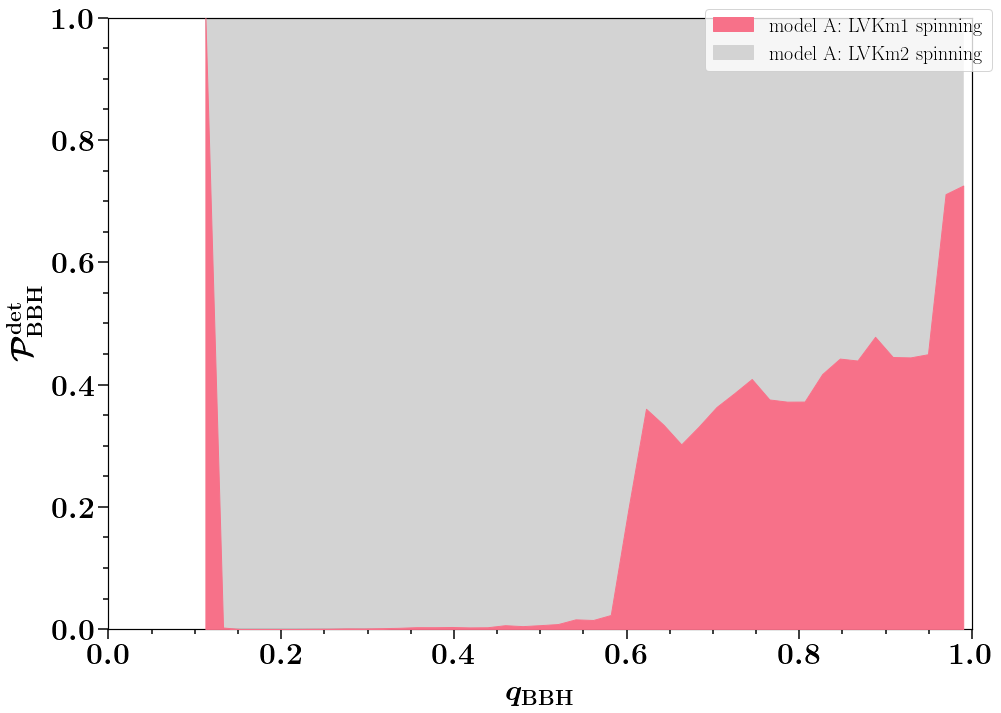

 -----   Now at model  B  -------
nr of weird reversals = 333
nr of normal reversals = 1250362

start calculating spin
8616008 8616008 8616008
done calculating spin

[0.33268279 0.22046352 0.20951969 ... 0.00703039 0.         0.        ]
0.0 0.8584652249957299
fraction of MRR = 0.5384911663504605
fraction of MassRatio MRR = 0.5384926490706751


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in true_divide


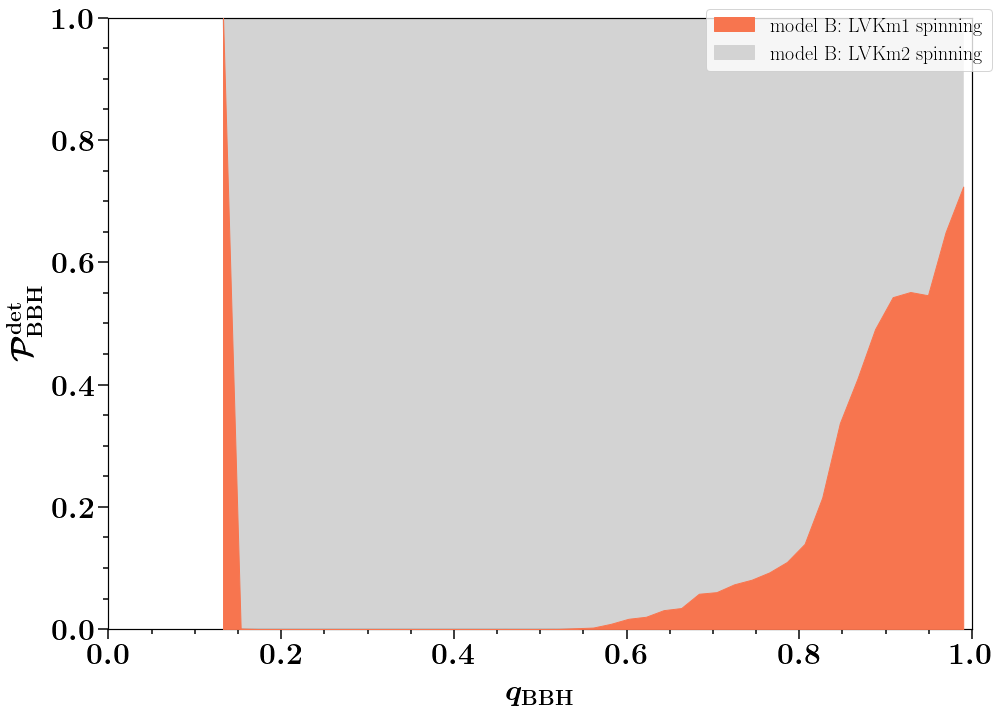

 -----   Now at model  C  -------
nr of weird reversals = 167
nr of normal reversals = 1980432

start calculating spin
6568454 6568454 6568454
done calculating spin

[0.42468494 0.41033956 0.22228283 ... 0.04697682 0.05786438 0.06436117]
0.0 0.8577311071635726
fraction of MRR = 0.6780616289362406
fraction of MassRatio MRR = 0.6780693897357979



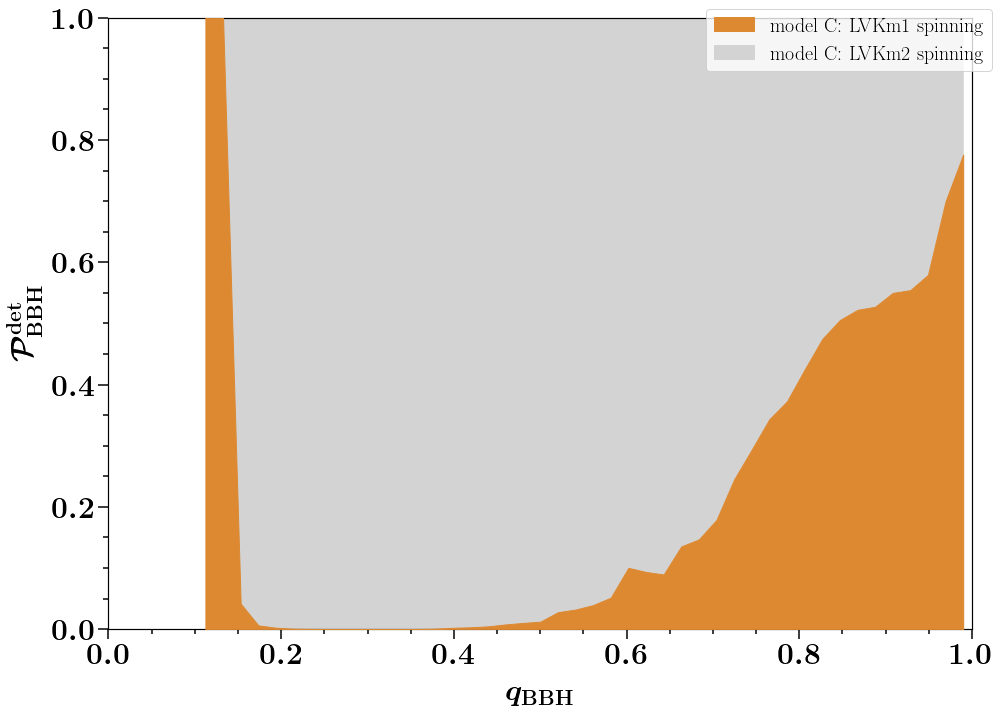

 -----   Now at model  D  -------
nr of weird reversals = 76
nr of normal reversals = 3198447

start calculating spin
6033721 6033721 6033721
done calculating spin

[0.         0.         0.30733575 ... 0.07033949 0.05202271 0.05218486]
0.0 0.9773090922771337
fraction of MRR = 0.7781348963579444
fraction of MassRatio MRR = 0.7781358402831946



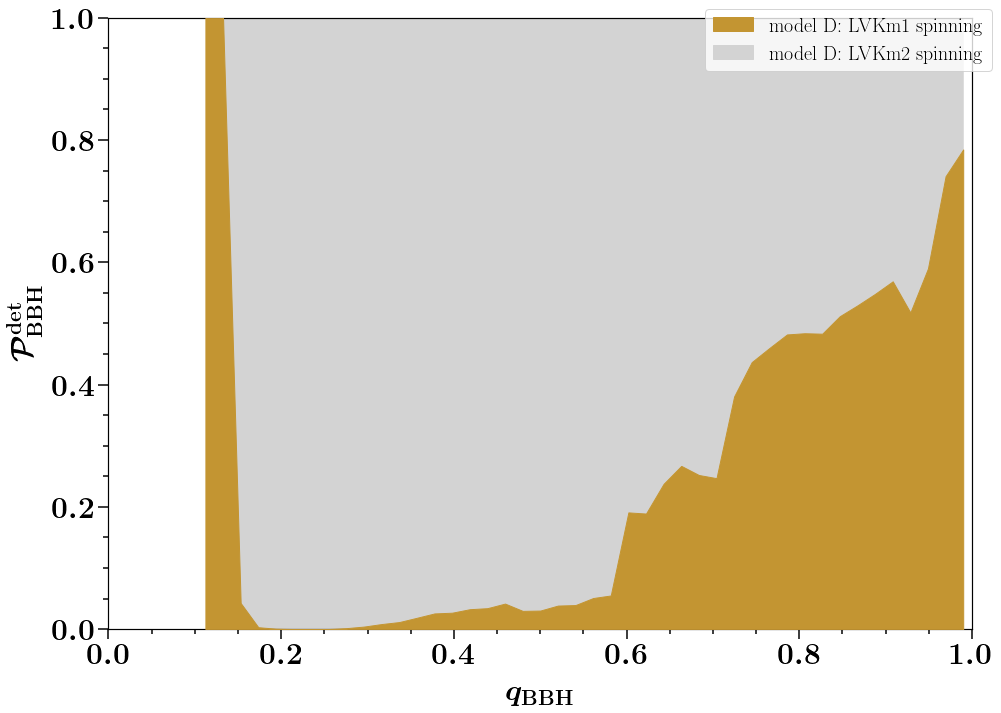

 -----   Now at model  E  -------
nr of weird reversals = 72
nr of normal reversals = 3738724

start calculating spin
9274636 9274636 9274636
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05803907 0.10130044 0.        ]
0.0 0.968960985447689
fraction of MRR = 0.7662586628934711
fraction of MassRatio MRR = 0.7662627249306307



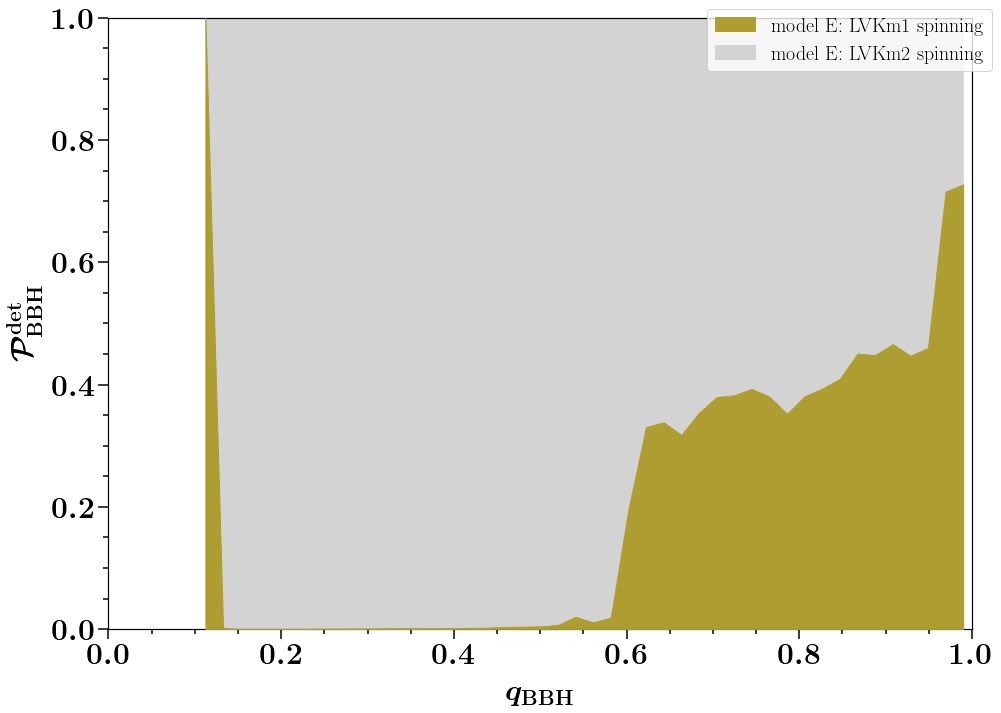

 -----   Now at model  F  -------
nr of weird reversals = 75
nr of normal reversals = 4184150

start calculating spin
9782847 9782847 9782847
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06940923 0.         0.0526679 ]
0.0 0.968960985447689
fraction of MRR = 0.8220913758165747
fraction of MassRatio MRR = 0.822094194768103



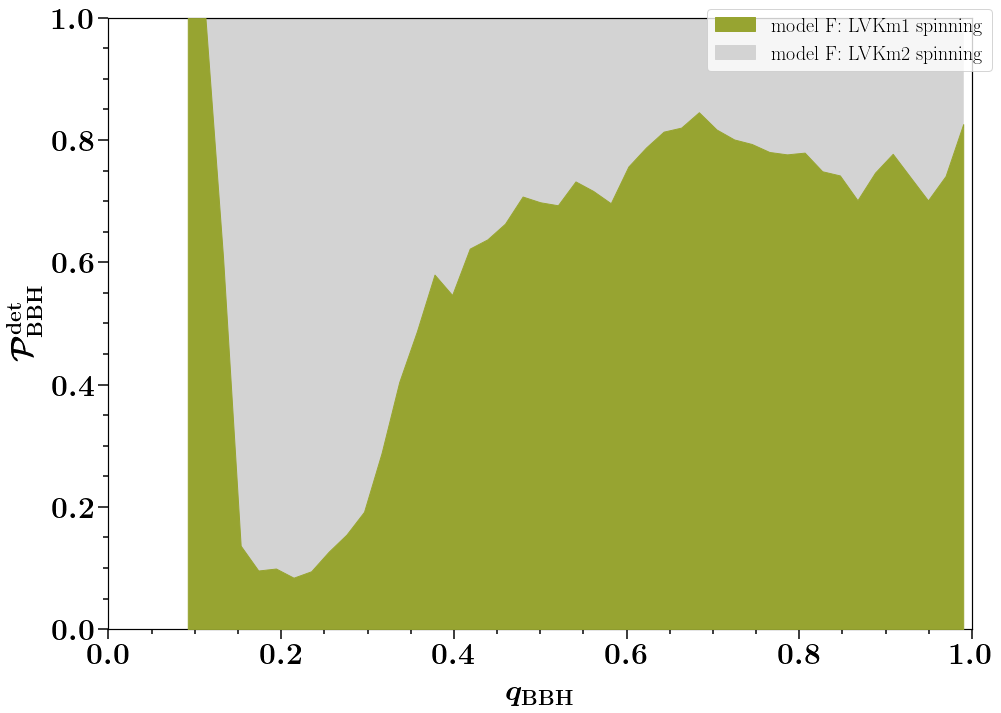

 -----   Now at model  G  -------
nr of weird reversals = 1
nr of normal reversals = 5249825

start calculating spin
6338030 6338030 6338030
done calculating spin

[0.         0.         0.12684785 ... 0.02173637 0.         0.        ]
0.0 0.8451639190519937
fraction of MRR = 0.9130534144077088
fraction of MassRatio MRR = 0.9130549512866144



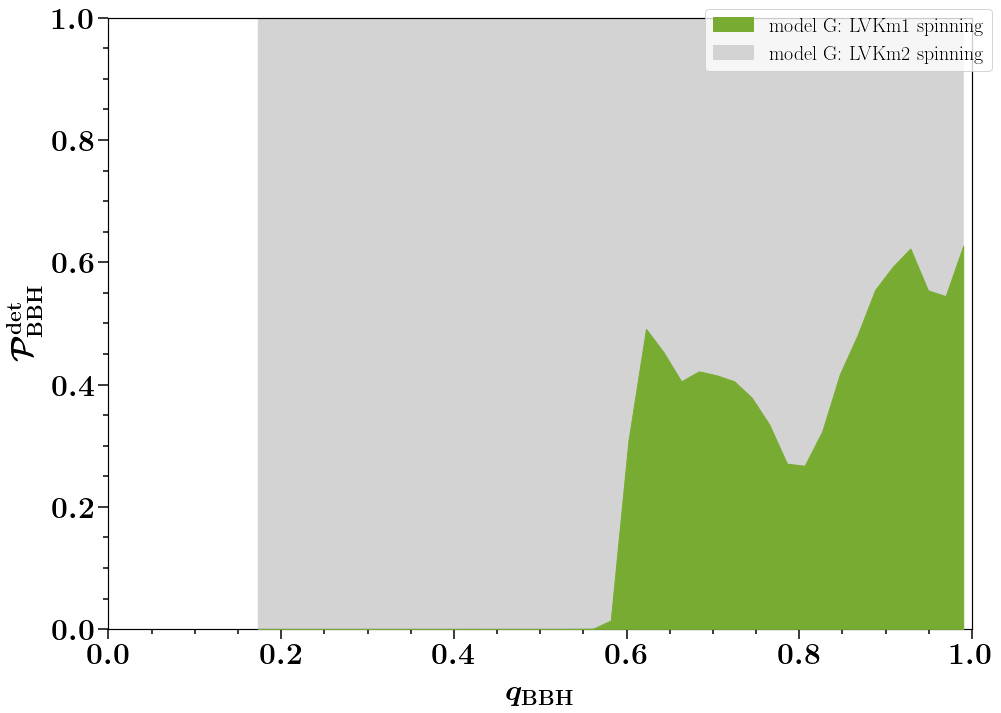

 -----   Now at model  H  -------
nr of weird reversals = 49
nr of normal reversals = 4198914

start calculating spin
7958497 7958497 7958497
done calculating spin

[0.         0.         0.12684785 ... 0.0577554  0.07906623 0.05958168]
0.0 0.9654037458389564
fraction of MRR = 0.793922106207558
fraction of MassRatio MRR = 0.7939320956919249



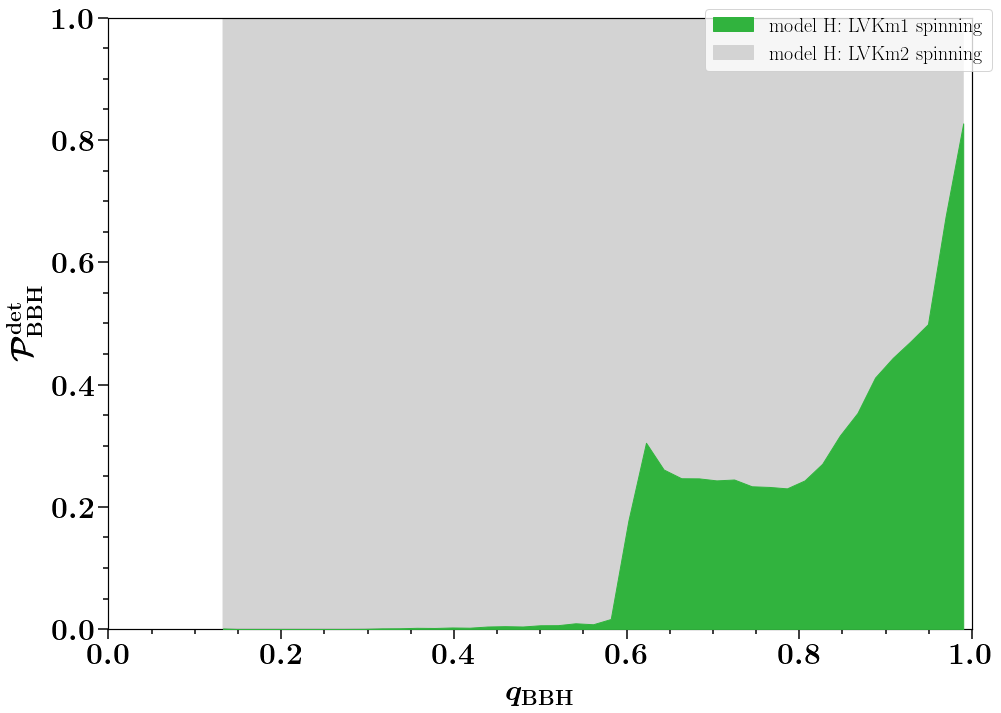

 -----   Now at model  I  -------
nr of weird reversals = 21
nr of normal reversals = 2625001

start calculating spin
6212236 6212236 6212236
done calculating spin

[0.15306977 0.24557262 0.13945493 ... 0.         0.         0.        ]
0.0 0.8463417568626156
fraction of MRR = 0.7057582408051555
fraction of MassRatio MRR = 0.705764688522422



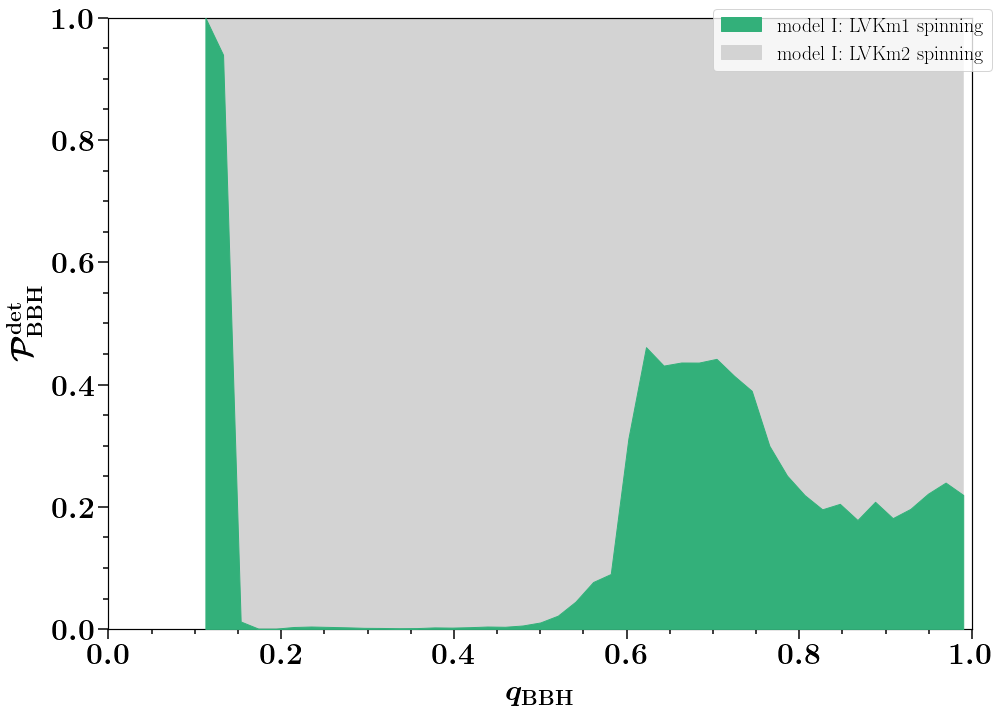

 -----   Now at model  J  -------
nr of weird reversals = 0
nr of normal reversals = 2896842

start calculating spin
3514443 3514443 3514443
done calculating spin

[0. 0. 0. ... 0. 0. 0.]
0.0 0.8251075103857082
fraction of MRR = 0.8906119154012471
fraction of MassRatio MRR = 0.8906123672635995



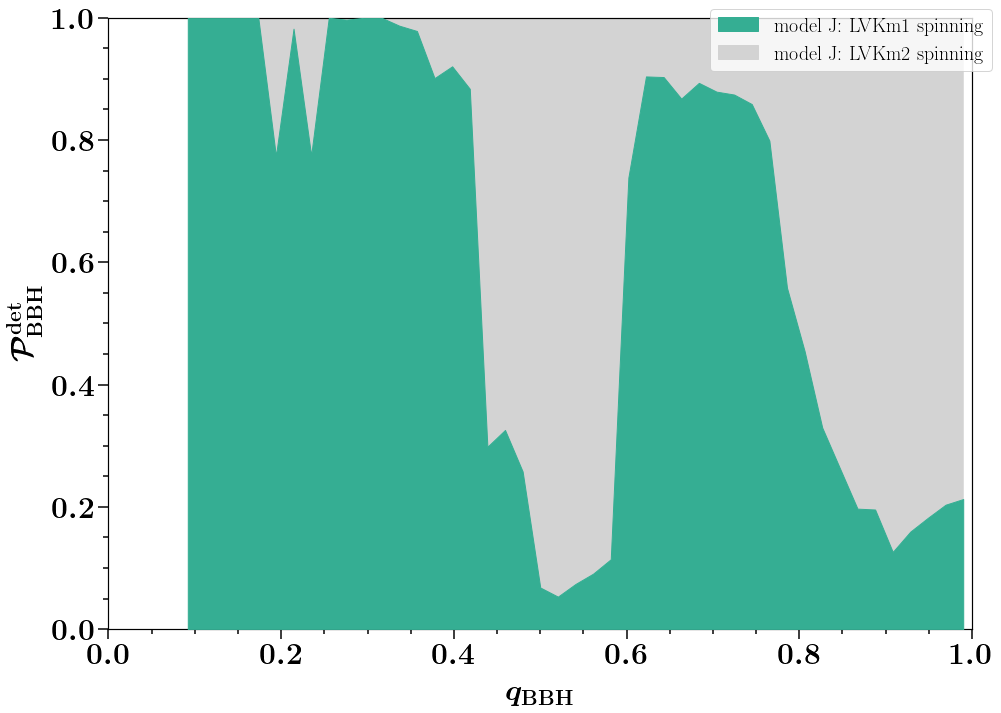

 -----   Now at model  K  -------
nr of weird reversals = 54
nr of normal reversals = 3778868

start calculating spin
8782290 8782290 8782290
done calculating spin

[0.32091348 0.22178376 0.         ... 0.0526679  0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.8210620335586227
fraction of MassRatio MRR = 0.8210645730638937



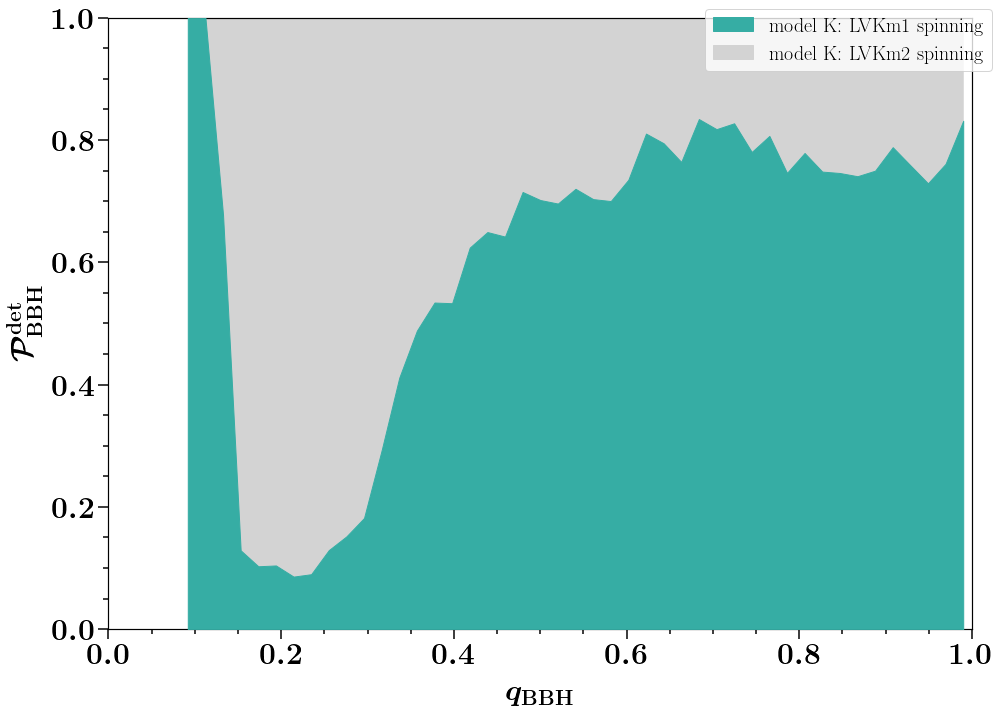

 -----   Now at model  L  -------
nr of weird reversals = 45
nr of normal reversals = 3312573

start calculating spin
7463923 7463923 7463923
done calculating spin

[0.32091348 0.21643375 0.         ... 0.         0.0242101  0.        ]
0.0 0.9656825660540831
fraction of MRR = 0.7657626706716913
fraction of MassRatio MRR = 0.7657626706716913



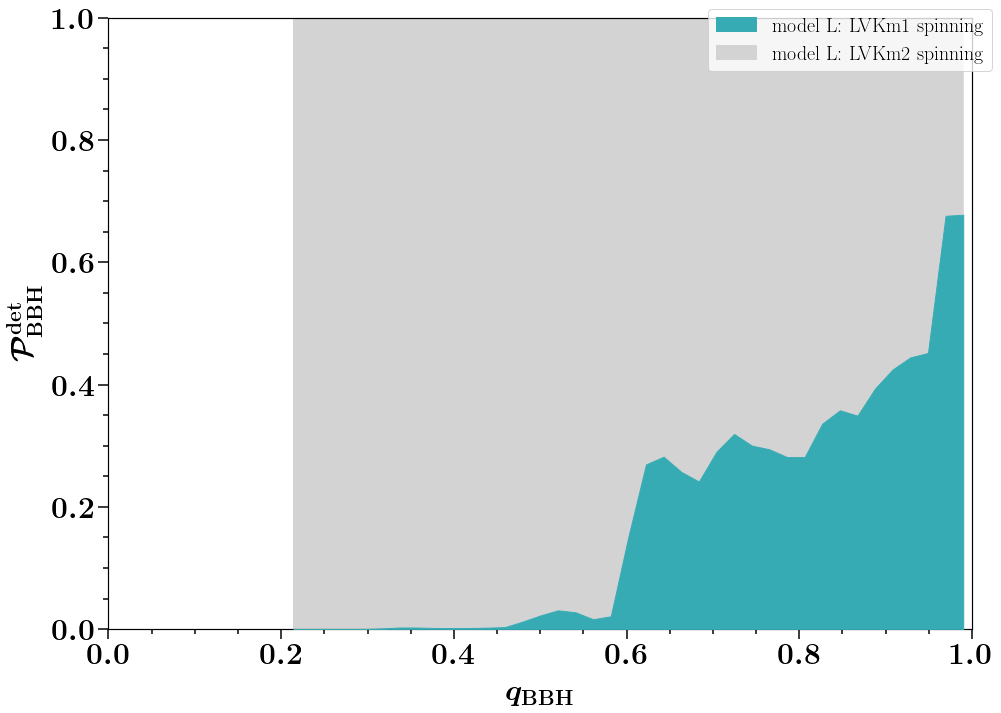

 -----   Now at model  M  -------
nr of weird reversals = 47
nr of normal reversals = 3362507

start calculating spin
8879317 8879317 8879317
done calculating spin

[0.         0.4758284  0.         ... 0.06384771 0.04543831 0.04730882]
0.0 0.9321893488847299
fraction of MRR = 0.7594608028097333
fraction of MassRatio MRR = 0.7594798268489741



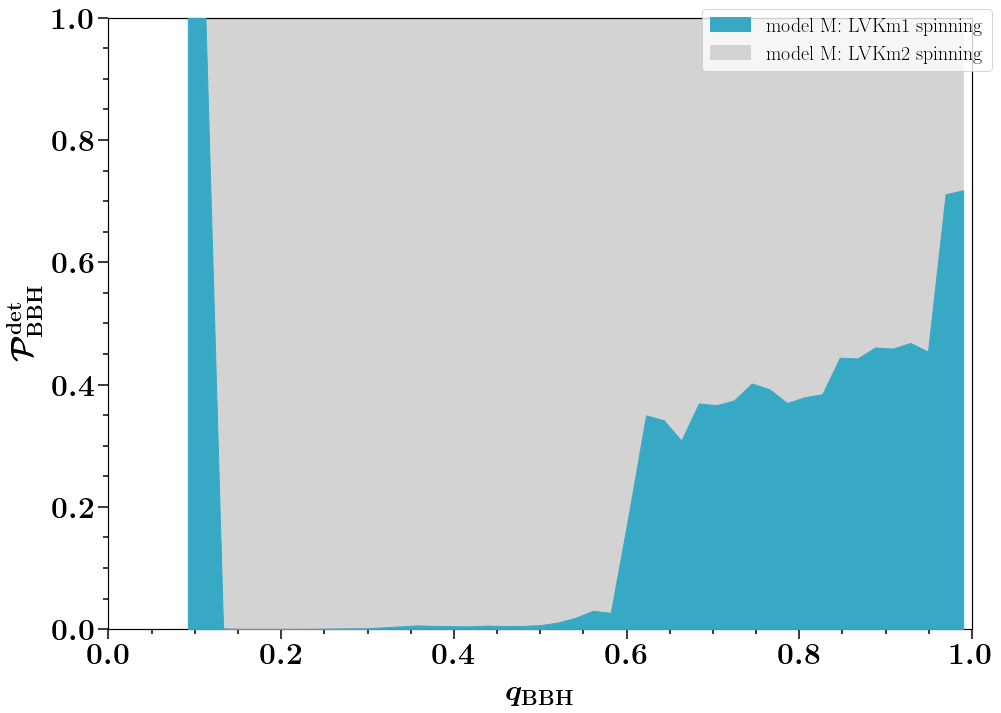

 -----   Now at model  N  -------
nr of weird reversals = 56
nr of normal reversals = 3386237

start calculating spin
7906131 7906131 7906131
done calculating spin

[0.32091348 0.22178376 0.         ... 0.10287358 0.         0.        ]
0.0 0.9618422953660551
fraction of MRR = 0.7732737249820993
fraction of MassRatio MRR = 0.7732738462753452



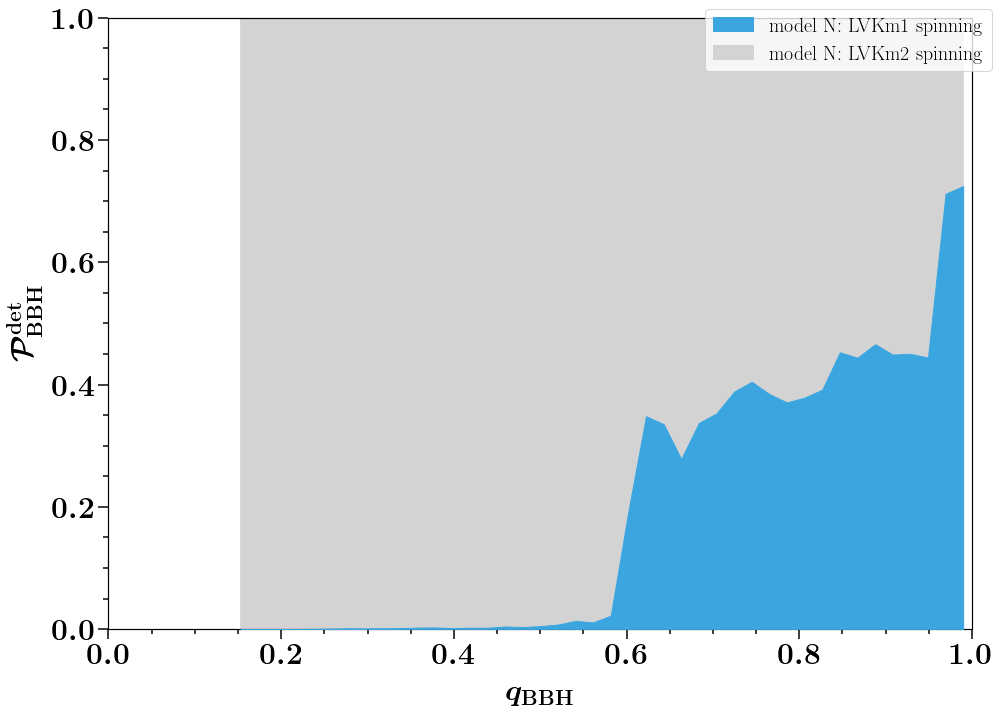

 -----   Now at model  P  -------
nr of weird reversals = 59
nr of normal reversals = 3072402

start calculating spin
8106172 8106172 8106172
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05324282 0.05005554 0.04504702]
0.0 0.9033468343947532
fraction of MRR = 0.7746021422616046
fraction of MassRatio MRR = 0.7746031820828979



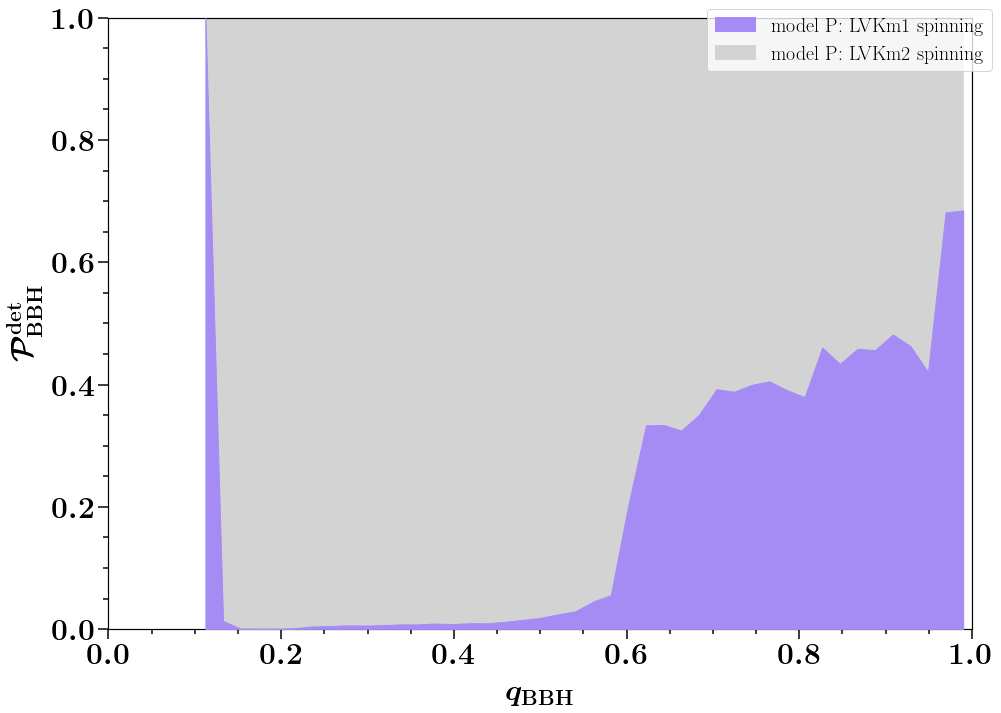

 -----   Now at model  Q  -------
nr of weird reversals = 47
nr of normal reversals = 2863591

start calculating spin
7609741 7609741 7609741
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06336806 0.04382311 0.04536733]
0.0 0.9637871581258313
fraction of MRR = 0.7798375645308337
fraction of MassRatio MRR = 0.7798375645308337



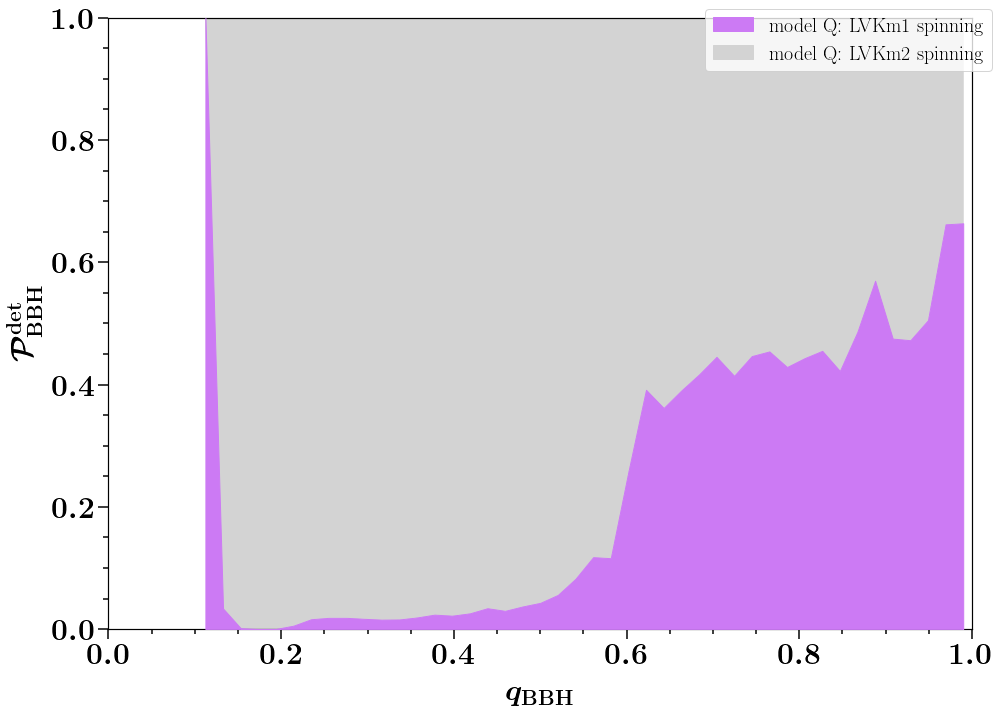

 -----   Now at model  R  -------
nr of weird reversals = 36
nr of normal reversals = 3443320

start calculating spin
8777168 8777168 8777168
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06040639 0.05861127 0.05046864]
0.0 0.9752858229779926
fraction of MRR = 0.7871570218131534
fraction of MassRatio MRR = 0.7871570218131534



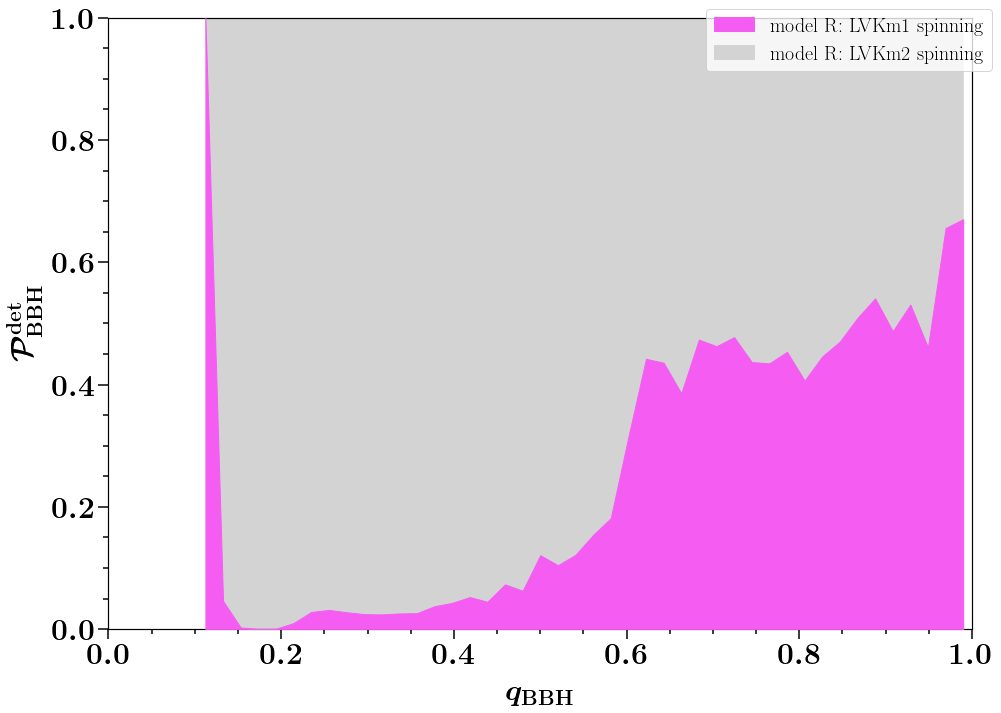

 -----   Now at model  S  -------
nr of weird reversals = 61
nr of normal reversals = 3764159

start calculating spin
8921965 8921965 8921965
done calculating spin

[0.31724994 0.30206939 0.22280807 ... 0.16134563 0.         0.25086565]
0.0 0.9675327892926453
fraction of MRR = 0.8120391674496257
fraction of MassRatio MRR = 0.8120521832939613



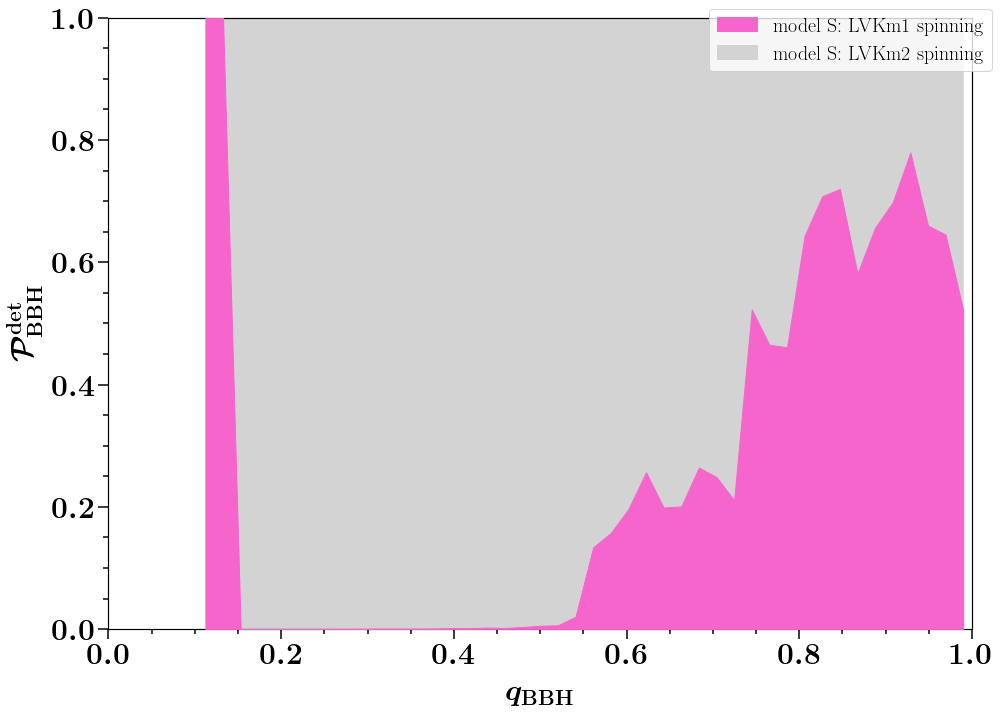

 -----   Now at model  T  -------
nr of weird reversals = 42
nr of normal reversals = 2395444

start calculating spin
6748472 6748472 6748472
done calculating spin

[0.33035537 0.21731945 0.         ... 0.         0.         0.        ]
0.0 0.8434021433330429
fraction of MRR = 0.5947169245927046
fraction of MassRatio MRR = 0.5947311235516102



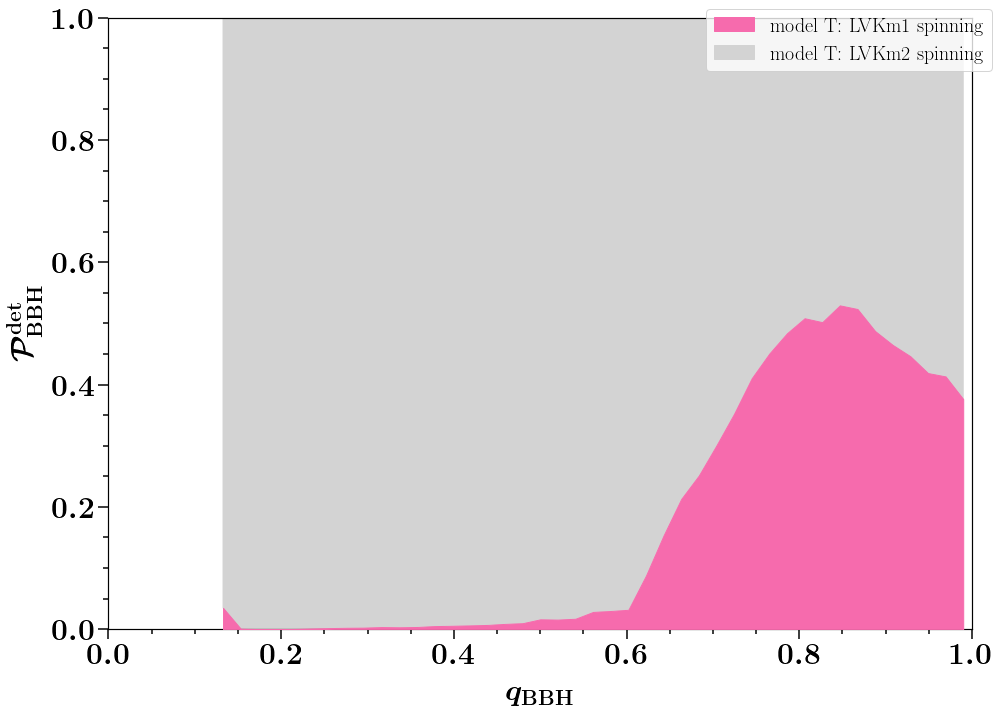

In [6]:
plotMRR_Prob(which_param = 'MassRatio')

 -----   Now at model  A  -------
nr of weird reversals = 51
nr of normal reversals = 3383143

start calculating spin
8371398 8371398 8371398
done calculating spin

[0.32091348 0.22178376 0.         ... 0.         0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.765737800239734
fraction of chirpmass MRR = 0.765737800239734


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in true_divide


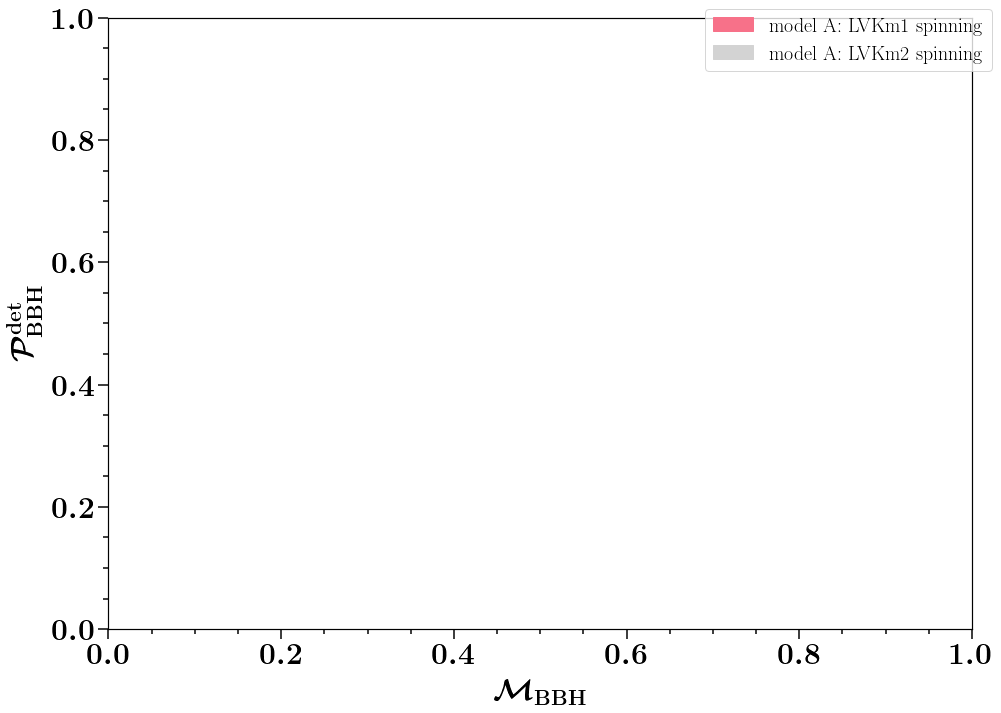

 -----   Now at model  B  -------
nr of weird reversals = 333
nr of normal reversals = 1250362

start calculating spin
8616008 8616008 8616008
done calculating spin

[0.33268279 0.22046352 0.20951969 ... 0.00703039 0.         0.        ]
0.0 0.8584652249957299
fraction of MRR = 0.5384911663504605
fraction of chirpmass MRR = 0.5384911663504605



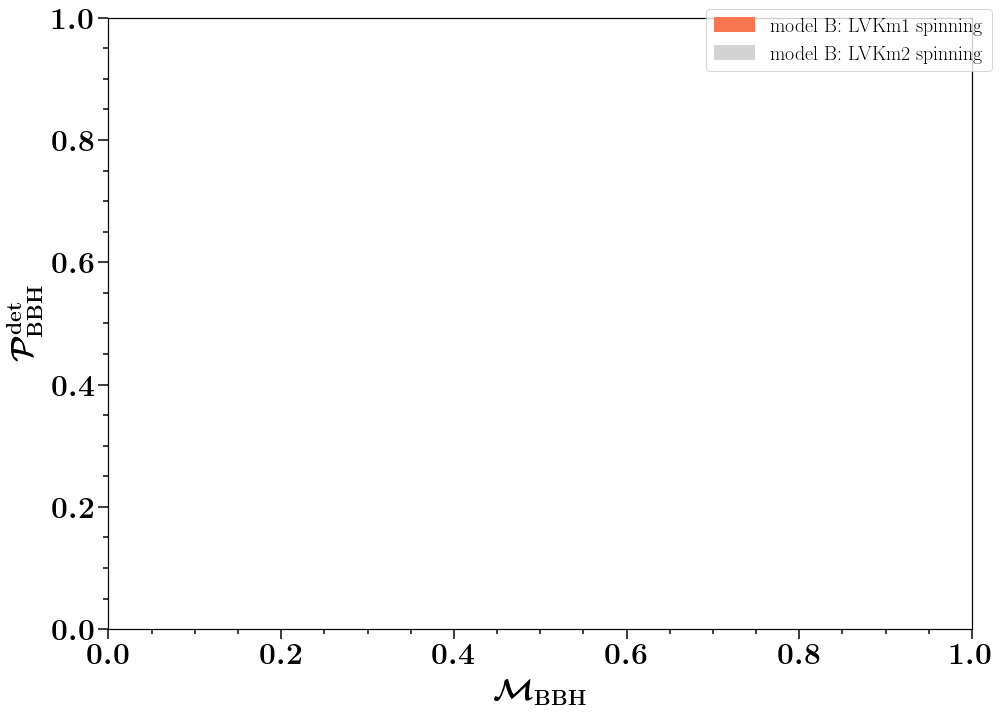

 -----   Now at model  C  -------
nr of weird reversals = 167
nr of normal reversals = 1980432

start calculating spin
6568454 6568454 6568454
done calculating spin

[0.42468494 0.41033956 0.22228283 ... 0.04697682 0.05786438 0.06436117]
0.0 0.8577311071635726
fraction of MRR = 0.6780616289362406
fraction of chirpmass MRR = 0.6780616289362406



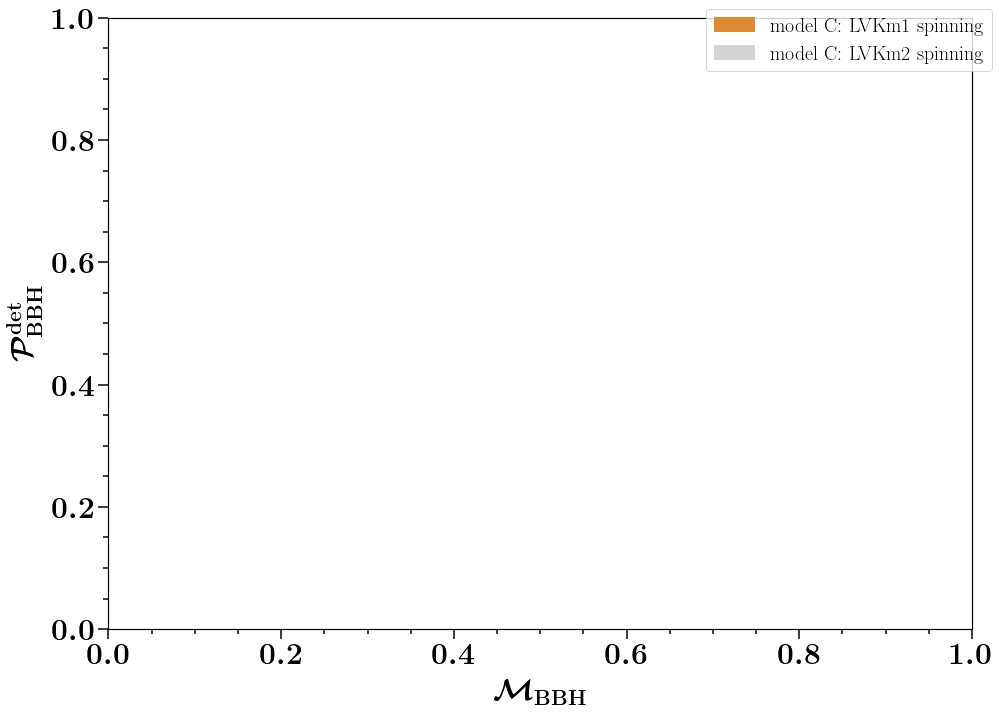

 -----   Now at model  D  -------
nr of weird reversals = 76
nr of normal reversals = 3198447

start calculating spin
6033721 6033721 6033721
done calculating spin

[0.         0.         0.30733575 ... 0.07033949 0.05202271 0.05218486]
0.0 0.9773090922771337
fraction of MRR = 0.7781348963579444
fraction of chirpmass MRR = 0.7781348963579444



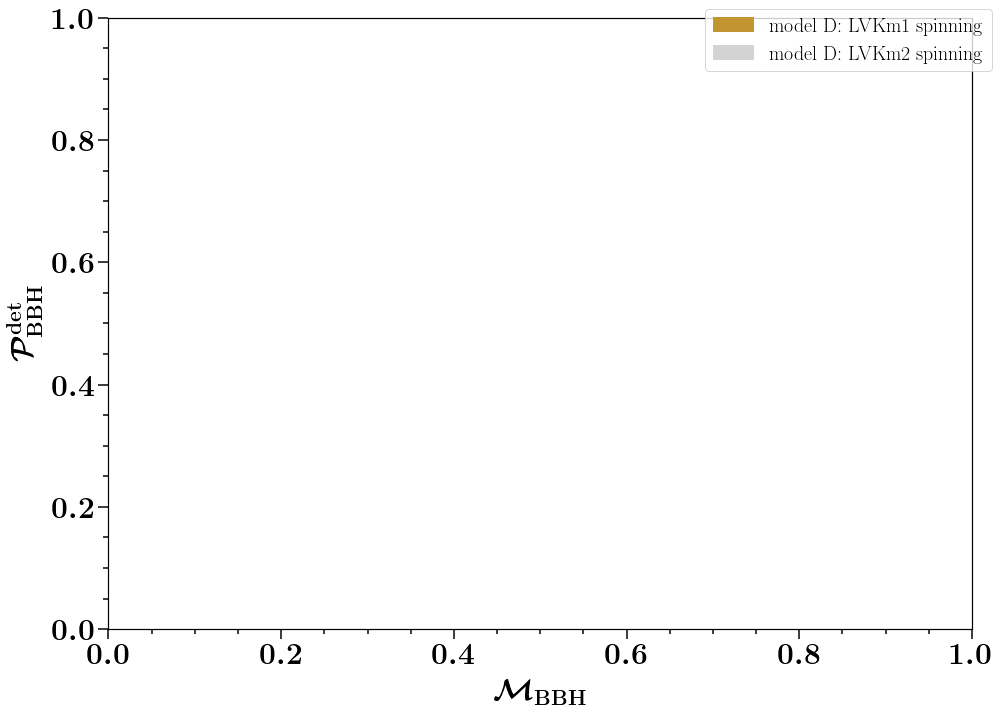

 -----   Now at model  E  -------
nr of weird reversals = 72
nr of normal reversals = 3738724

start calculating spin
9274636 9274636 9274636
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05803907 0.10130044 0.        ]
0.0 0.968960985447689
fraction of MRR = 0.7662586628934711
fraction of chirpmass MRR = 0.7662586628934711



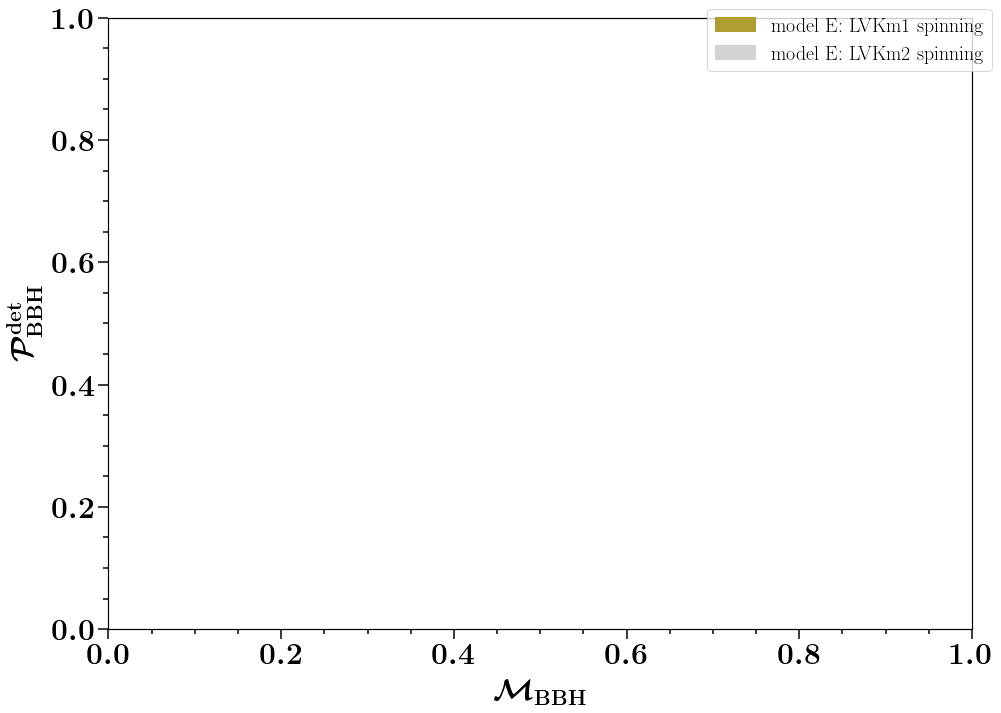

 -----   Now at model  F  -------
nr of weird reversals = 75
nr of normal reversals = 4184150

start calculating spin
9782847 9782847 9782847
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06940923 0.         0.0526679 ]
0.0 0.968960985447689
fraction of MRR = 0.8220913758165747
fraction of chirpmass MRR = 0.8220913758165747



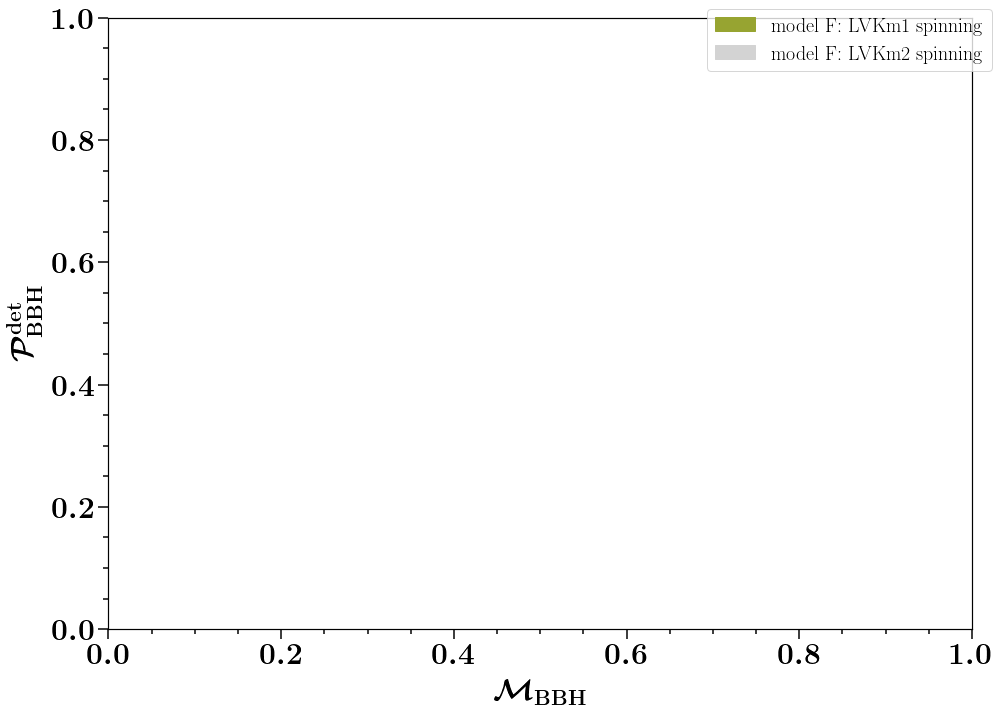

 -----   Now at model  G  -------
nr of weird reversals = 1
nr of normal reversals = 5249825

start calculating spin
6338030 6338030 6338030
done calculating spin

[0.         0.         0.12684785 ... 0.02173637 0.         0.        ]
0.0 0.8451639190519937
fraction of MRR = 0.9130534144077088
fraction of chirpmass MRR = 0.9130534144077088



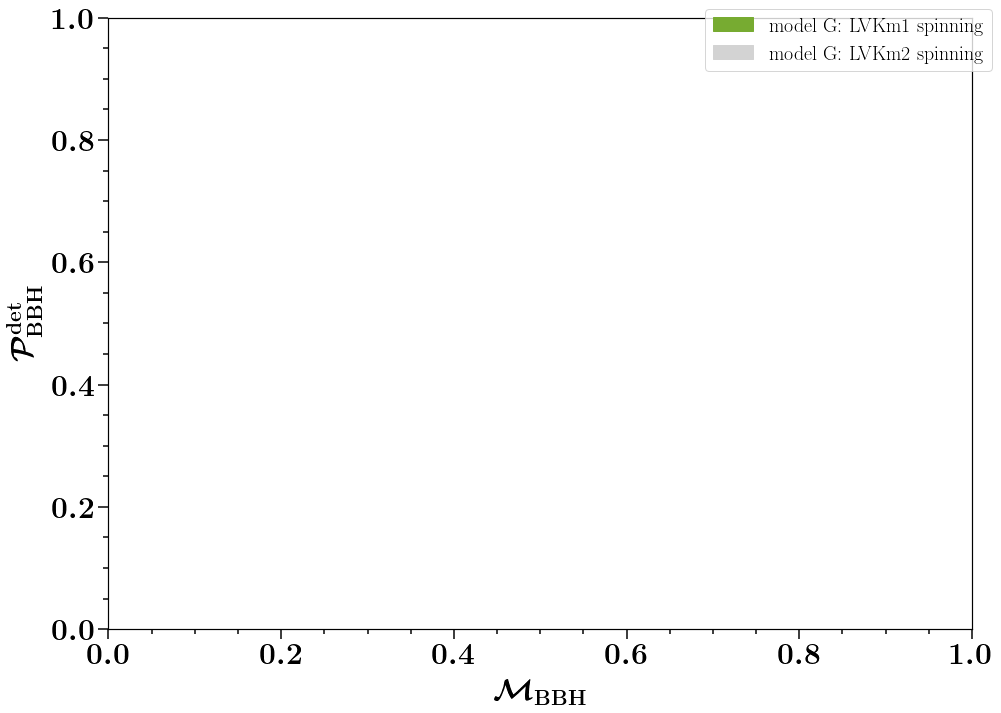

 -----   Now at model  H  -------
nr of weird reversals = 49
nr of normal reversals = 4198914

start calculating spin
7958497 7958497 7958497
done calculating spin

[0.         0.         0.12684785 ... 0.0577554  0.07906623 0.05958168]
0.0 0.9654037458389564
fraction of MRR = 0.793922106207558
fraction of chirpmass MRR = 0.793922106207558



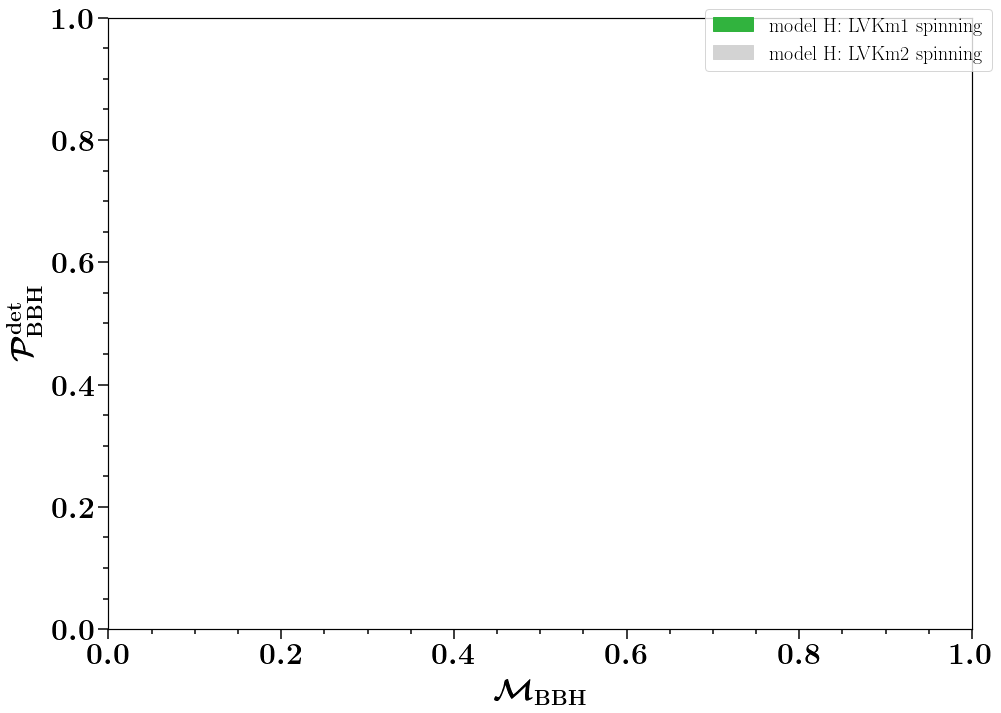

 -----   Now at model  I  -------
nr of weird reversals = 21
nr of normal reversals = 2625001

start calculating spin
6212236 6212236 6212236
done calculating spin

[0.15306977 0.24557262 0.13945493 ... 0.         0.         0.        ]
0.0 0.8463417568626156
fraction of MRR = 0.7057582408051555
fraction of chirpmass MRR = 0.7057582408051555



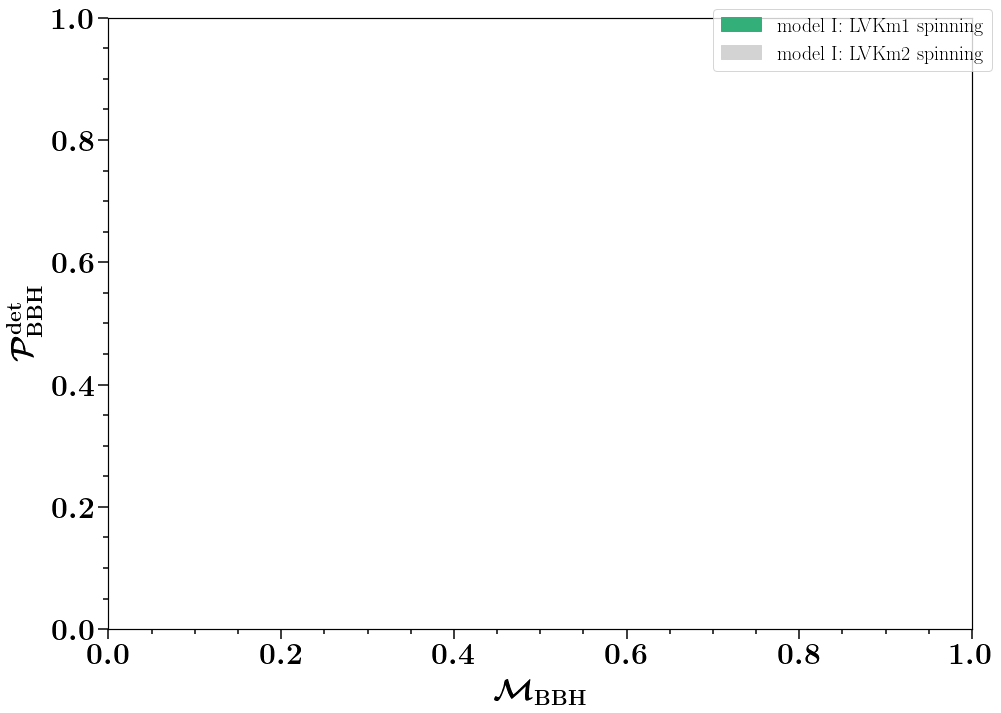

 -----   Now at model  J  -------
nr of weird reversals = 0
nr of normal reversals = 2896842

start calculating spin
3514443 3514443 3514443
done calculating spin

[0. 0. 0. ... 0. 0. 0.]
0.0 0.8251075103857082
fraction of MRR = 0.8906119154012471
fraction of chirpmass MRR = 0.8906119154012471



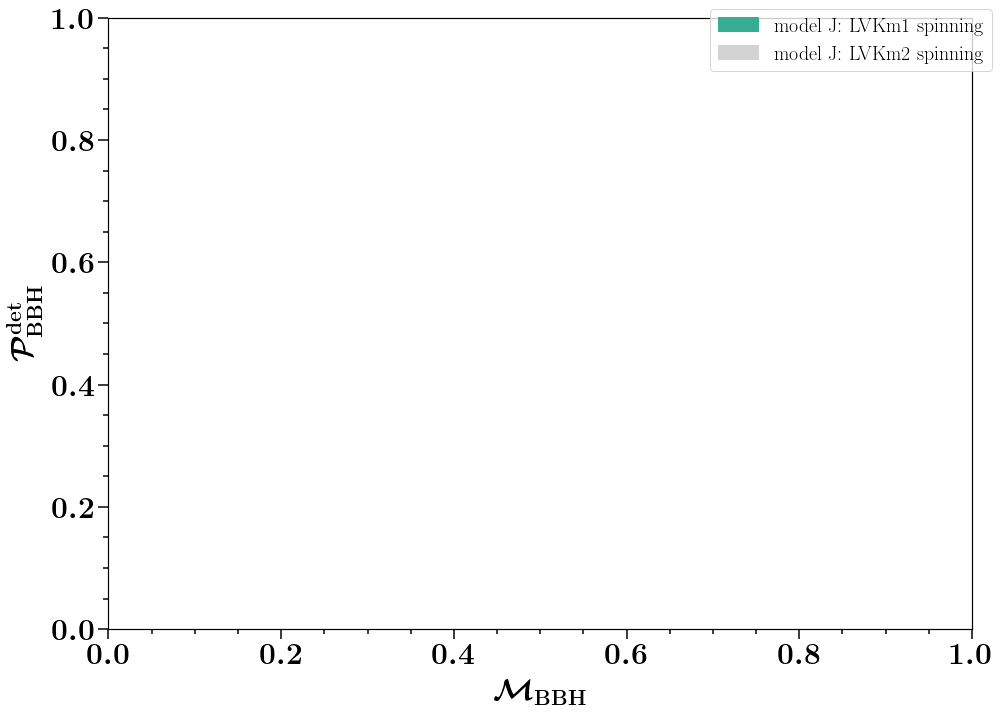

 -----   Now at model  K  -------
nr of weird reversals = 54
nr of normal reversals = 3778868

start calculating spin
8782290 8782290 8782290
done calculating spin

[0.32091348 0.22178376 0.         ... 0.0526679  0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.8210620335586227
fraction of chirpmass MRR = 0.8210620335586227



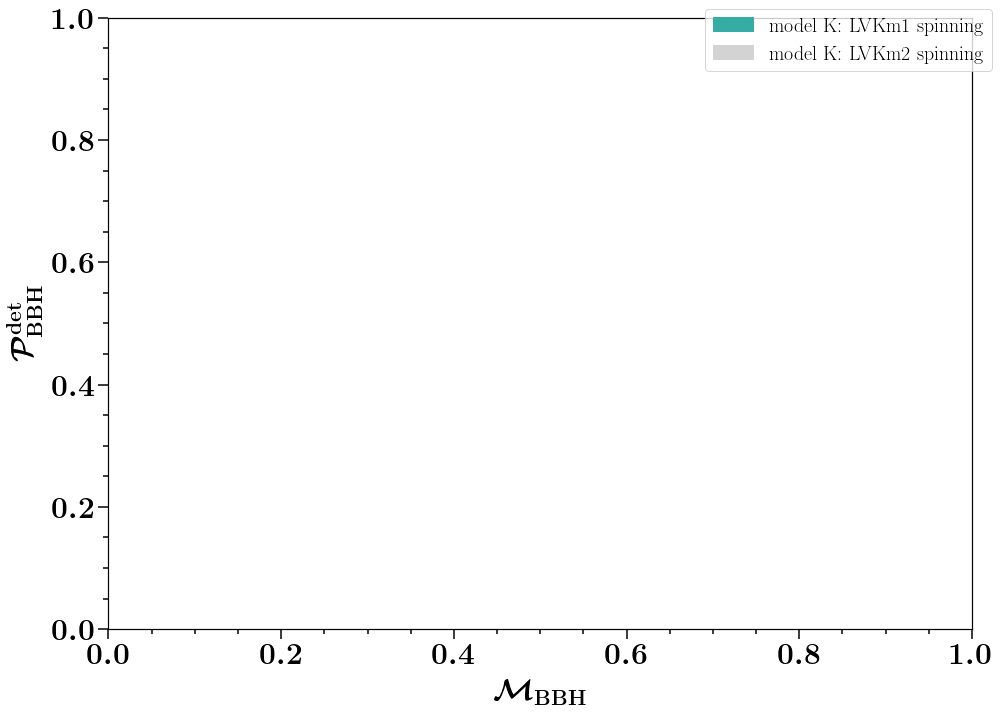

 -----   Now at model  L  -------
nr of weird reversals = 45
nr of normal reversals = 3312573

start calculating spin
7463923 7463923 7463923
done calculating spin

[0.32091348 0.21643375 0.         ... 0.         0.0242101  0.        ]
0.0 0.9656825660540831
fraction of MRR = 0.7657626706716913
fraction of chirpmass MRR = 0.7657626706716913



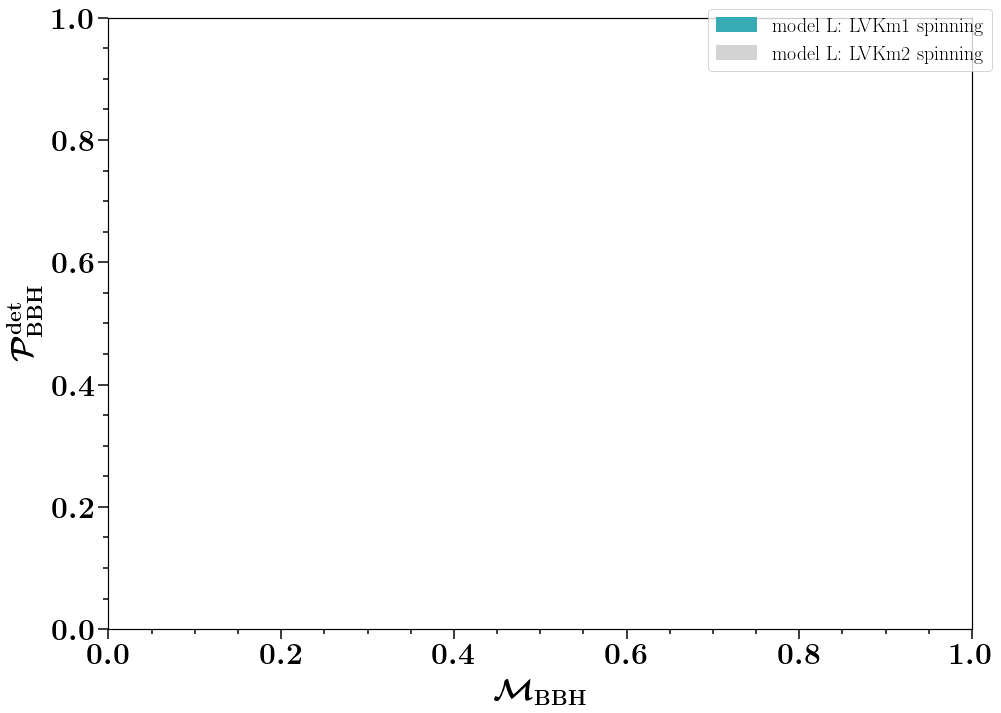

 -----   Now at model  M  -------
nr of weird reversals = 47
nr of normal reversals = 3362507

start calculating spin
8879317 8879317 8879317
done calculating spin

[0.         0.4758284  0.         ... 0.06384771 0.04543831 0.04730882]
0.0 0.9321893488847299
fraction of MRR = 0.7594608028097333
fraction of chirpmass MRR = 0.7594608028097333



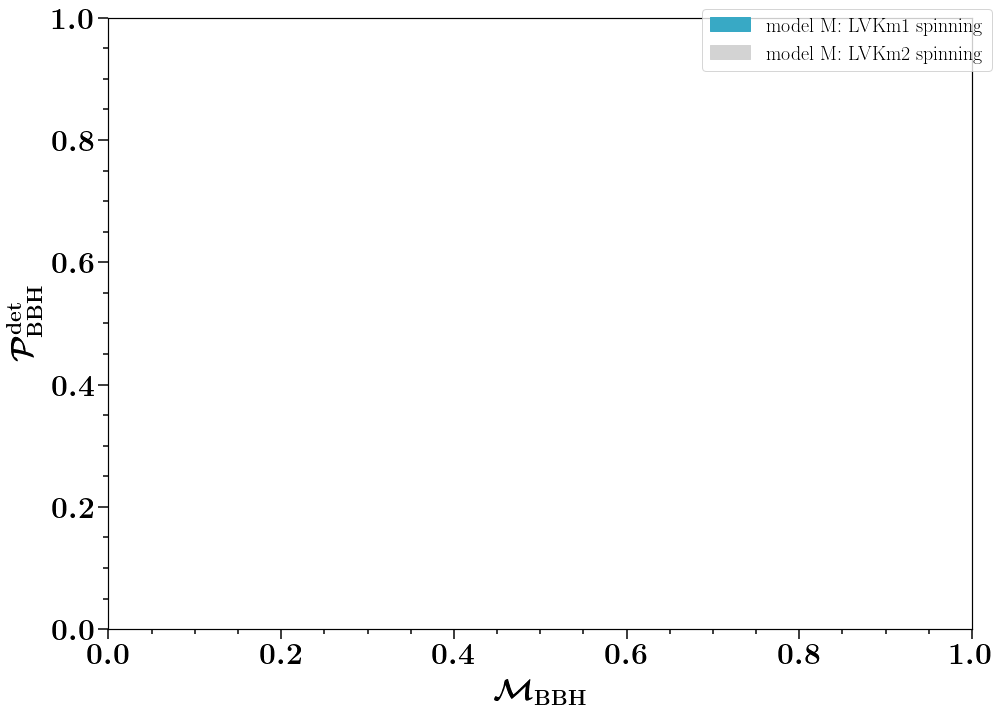

 -----   Now at model  N  -------
nr of weird reversals = 56
nr of normal reversals = 3386237

start calculating spin
7906131 7906131 7906131
done calculating spin

[0.32091348 0.22178376 0.         ... 0.10287358 0.         0.        ]
0.0 0.9618422953660551
fraction of MRR = 0.7732737249820993
fraction of chirpmass MRR = 0.7732737249820993



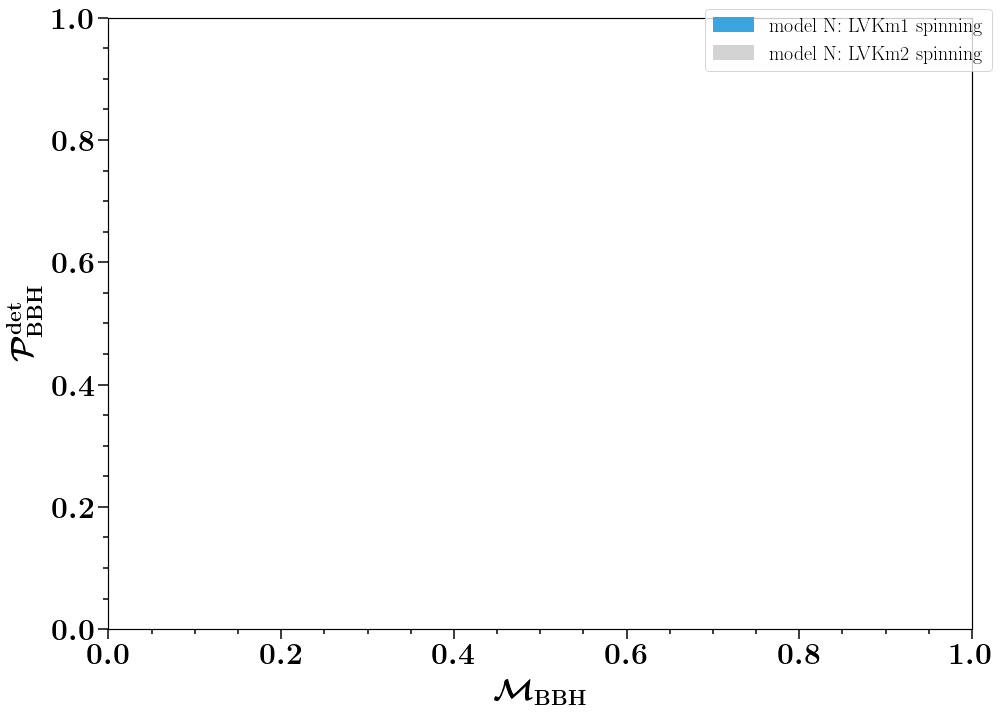

 -----   Now at model  P  -------
nr of weird reversals = 59
nr of normal reversals = 3072402

start calculating spin
8106172 8106172 8106172
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05324282 0.05005554 0.04504702]
0.0 0.9033468343947532
fraction of MRR = 0.7746021422616046
fraction of chirpmass MRR = 0.7746021422616046



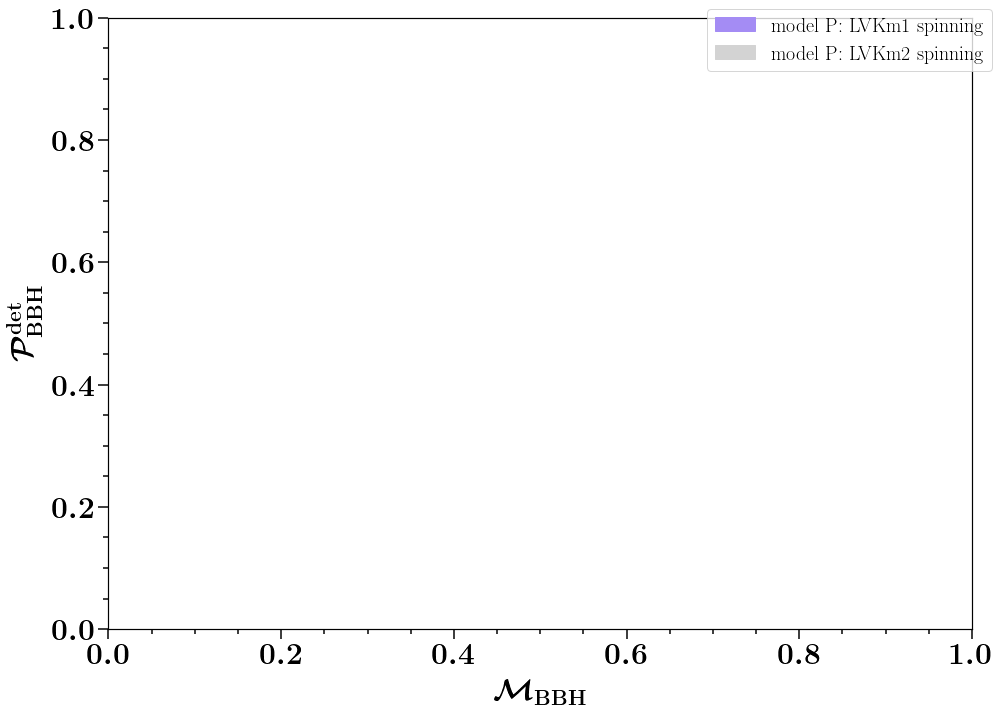

 -----   Now at model  Q  -------
nr of weird reversals = 47
nr of normal reversals = 2863591

start calculating spin


KeyboardInterrupt: 

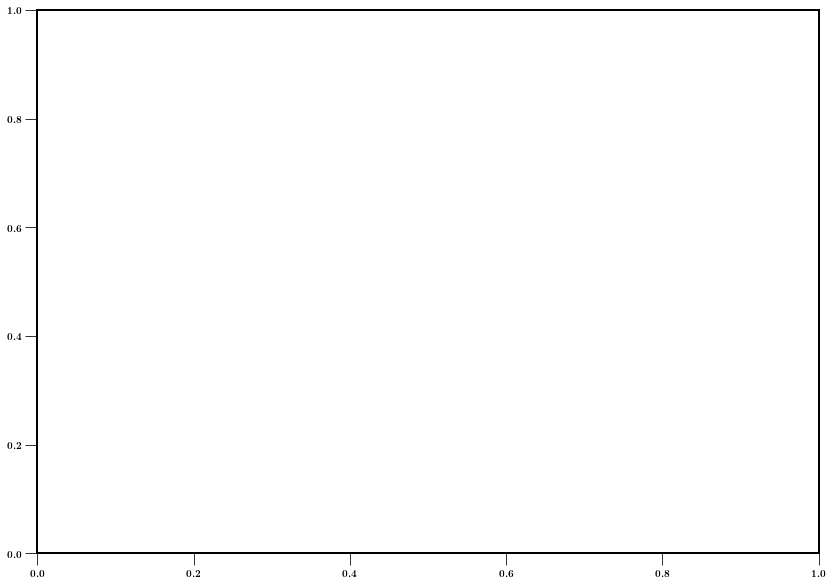

In [9]:
plotMRR_Prob(which_param = 'chirpmass')

In [ ]:
plotMRR_Prob(which_param = 'MassBH1')

In [19]:
fs=20
import math 



def plotqlines(ax, qlist, qtextvalue):
    """qlist = [5., 3.333333334, 2., 1.]"""
    ## Add constant mass ratio lines 
    x_q = np.linspace(1,50) # Msun, M1 range
    # plot a few fixed mass ratios:
#     xmin = 1 
    xmin, xmax = 1, 50 
    ymin, ymax = 1, 50
    for ind_q, qvalue in enumerate(qlist):
        y_q =  x_q / qvalue


        y_text = 28 # Msun 
        if y_text*qvalue < 50:
            x_text = y_text * qvalue 
        else: 
            x_text = 40.
            y_text = x_text / qvalue

        # I am calculating the angle theta for the text: (see notes on this)
        delta_y = ((y_text - ymin) / (ymax-ymin)) 
        delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
        ratio = delta_y / delta_x
        theta_angle = math.degrees(math.atan((ratio)))

        ax.plot(x_q, y_q, c='k', lw=2, linestyle =':', zorder=1E6)
        ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
                       horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        







def plotMRR_ProbTotal(which_param='chi_BH1'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
#     fig, axe = plt.subplots(1,1, figsize=(14,10),\
#                            gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})

    
    
    fs_l = 20 # label fontsize  
    
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
               r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      

    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
           r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']    
    
    
    

    DCOtype='BBH'
 
    for BPSmodelName in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',  'P', 'Q', 'R', 'S', 'T']:
        fig, axe = plt.subplots(1,1, figsize=(14,10),\
                               gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})   

        print(' -----   Now at model ', BPSmodelName, ' -------')

#         mssfr = '112' # mssfr that matches LIGO observed rates.
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)


        M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
        M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
        MRR_mask = (M2BH>M1BH) # THe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatioBBH = M2/M1

        ### FOR SPIN ###
        seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
        seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
        # get only SN seeds for DCOs 
        maskSNdco = np.in1d(seedsSN,  seedsDCO) 
        whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
        whichSN1 = whichSN[::2] # get whichStar for first SN 


        separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
        separationPreSN2 = separationPreSN[1::2] # in Rsun. 
        MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  

        # the second SN is the most massive BH 
        maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  

        mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
        mask_2 = ((whichSN1==1) & (M1BH<M2BH))

        print('nr of weird reversals = %s'%np.sum(mask_temp))
        print('nr of normal reversals = %s'%np.sum(mask_2))
        
        
        print()
        print('start calculating spin')
        spin = COspin(data_path=path)  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
        
        
        spinM1, spinM2 = np.zeros(len(spinMZAMS1)), np.zeros(len(spinMZAMS1))
        spinM1[MRR_mask] = spinMZAMS2[MRR_mask]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinM1[~MRR_mask] = spinMZAMS1[~MRR_mask]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinM2[MRR_mask] = spinMZAMS1[MRR_mask]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinM2[~MRR_mask] = spinMZAMS2[~MRR_mask]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     
        
        chi_eff  = ((spinM1 *M1) + spinM2*M2) / (M1+M2)
        
        print('done calculating spin')
        print()
        
        

        
        if which_param=='chi_BH1':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = '$\chi_{\rm{1}}$ (detected M1)'
            
        elif which_param=='chi_BH2':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = r'$\chi_{\rm{2}} $ (detected M2)'
            
        elif which_param=='MassRatio':
            xparam = MassRatioBBH
            x_grid = np.linspace(0,1, 50)
            xlabel = r'$q_{\rm{BBH}}$'
        elif which_param=='chi_eff':
            xparam = chi_eff
            x_grid = np.linspace(0,1, 50)
            xlabel = r'$q_{\rm{BBH}}$'
                     

        elif which_param=='chirpmass':
            xparam = Chirpmass
            x_grid = np.linspace(0,60, 50)
            xlabel = r'$\mathcal{M}_{\rm{BBH}} \ [M_{\odot}]$'  

        elif which_param=='MassBH1':
            xparam = M1
            x_grid = np.linspace(0,70, 50)
            xlabel = r'${M}_{\rm{LVKm1}} \ [M_{\odot}]$'  
    
        x_grid_centers = (x_grid[:-1] + x_grid[1:])/2
        
        mask_noSpin = (spinM2<0.1) & (spinM1<0.1)

        print(chi_eff)
        print(min(chi_eff), max(chi_eff))
        for mssfr in ['112']:
            # get detected weights
            fparam_key = 'weights_detected'
            weightheader = 'w_' + mssfr
            weights_ = fdata[fparam_key][weightheader][...].squeeze()
            w = weights_

            
        

            print('fraction of MRR = %s'%(np.sum(w[MRR_mask])/np.sum(w)))
            print('fraction of %s MRR = %s'%(which_param, (np.sum(w[MRR_mask][xparam[MRR_mask]>0.1])/np.sum(w[xparam > 0.1]))))

            
            
            
            
            hist_chiLVKm1, _ = np.histogram(xparam[spinM1>0.1], x_grid, weights=w[spinM1>0.1], density=False)
            hist_chiLVKm2, _ = np.histogram(xparam[spinM2>0.1], x_grid, weights=w[spinM2>0.1], density=False)
            hist_noSpin, _ = np.histogram(xparam[mask_noSpin], x_grid, weights=w[mask_noSpin], density=False)

#             print(hist_MRR/(hist_MRR+hist_notMRR))
#             print(200*np.ones_like(hist_MRR))
#             print(x_grid_centers)
#             print(len(hist_MRR/(hist_MRR+hist_notMRR)))
#             print(len(200*np.ones_like(hist_MRR)))
#             print(len(x_grid_centers))

            norm_ = (hist_chiLVKm1+hist_chiLVKm2+hist_noSpin) 
            axe.fill_between(x_grid_centers,  y1=np.zeros_like(norm_), y2=hist_chiLVKm1/norm_,      color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: LVKm1 spinning'%BPSmodelName)
            axe.fill_between(x_grid_centers,  y1=hist_chiLVKm1/norm_, y2=(hist_chiLVKm1+hist_chiLVKm2)/norm_, color= 'gray', zorder=1, label=r'model %s: LVKm2 spinning'%BPSmodelName)
        
            axe.fill_between(x_grid_centers,  y1=(hist_chiLVKm1+hist_chiLVKm2)/norm_, y2=(200*np.ones_like(norm_)), color= 'lightgray', zorder=1, label=r'model %s: $\chi_{\rm{BH,x}} < 0.1$'%BPSmodelName)
            
#             axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(hist_MRR+hist_notMRR), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
#             axe.plot(x_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=10, label=r'model %s: Total BBH rate '%BPSmodelName)
# #                 else:
#                     axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                     axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#             else:
#                 axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                 axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)

        print()
     

            
            
        axe.set_xlim(min(x_grid), max(x_grid))            
        
        axe.set_ylim(0, 1)
        axe = layoutAxes(axe, nameX=xlabel, nameY=r'$\mathcal{P}^{\rm{det}}_{\rm{BBH}} $ ',setMinor=True, labelpad=10, fontsize=fs_l+10)
#         axe.set_yscale('log')
        
        fig.legend(fontsize=20).set_zorder(102)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)#2)

        plt.tight_layout() 
        plt.savefig('./Prob_weight_Chi1_vs_Chi2_vs_Total_model_'+BPSmodelName+ mssfr+ '_'+ which_param +'.png', transparent=False, bbox_inches="tight", dpi=300)
        plt.show()    
    
    return 





 -----   Now at model  A  -------
nr of weird reversals = 51
nr of normal reversals = 3383143

start calculating spin
8371398 8371398 8371398
done calculating spin

[0.32091348 0.22178376 0.         ... 0.         0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.765737800239734
fraction of chirpmass MRR = 0.765737800239734


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


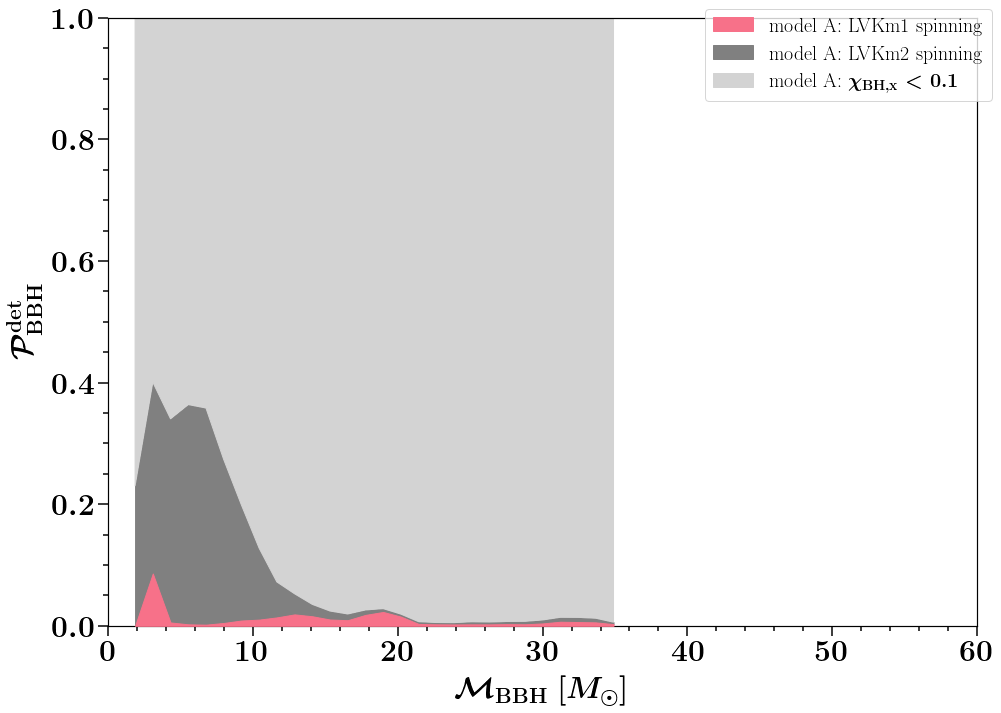

 -----   Now at model  B  -------
nr of weird reversals = 333
nr of normal reversals = 1250362

start calculating spin
8616008 8616008 8616008
done calculating spin

[0.33268279 0.22046352 0.20951969 ... 0.00703039 0.         0.        ]
0.0 0.8584652249957299
fraction of MRR = 0.5384911663504605
fraction of chirpmass MRR = 0.5384911663504605


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


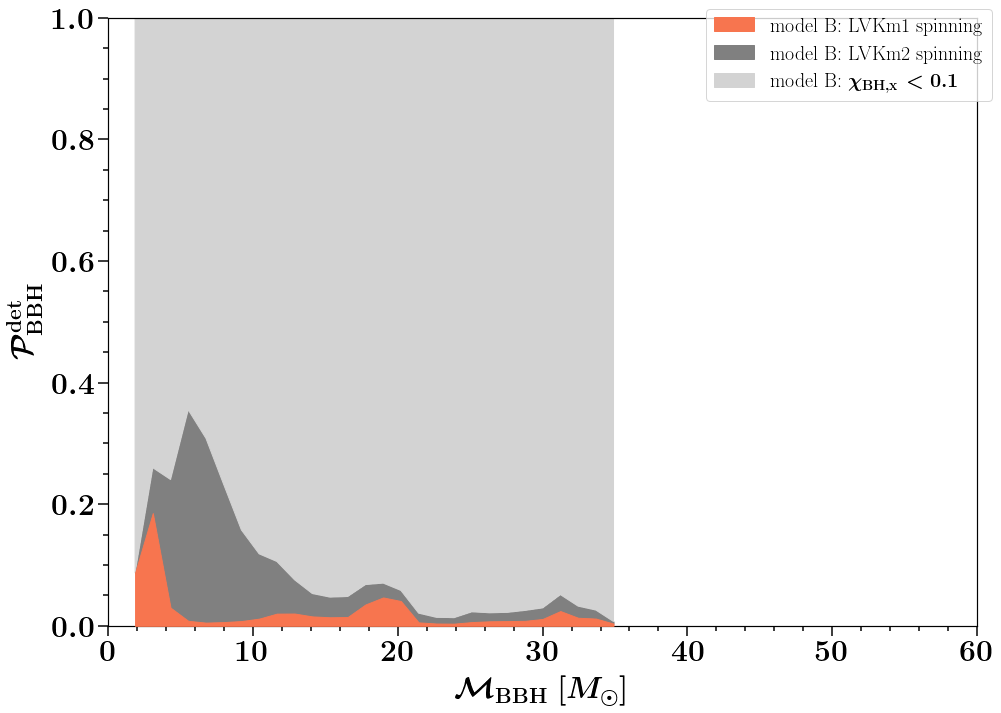

 -----   Now at model  C  -------
nr of weird reversals = 167
nr of normal reversals = 1980432

start calculating spin
6568454 6568454 6568454
done calculating spin

[0.42468494 0.41033956 0.22228283 ... 0.04697682 0.05786438 0.06436117]
0.0 0.8577311071635726
fraction of MRR = 0.6780616289362406
fraction of chirpmass MRR = 0.6780616289362406



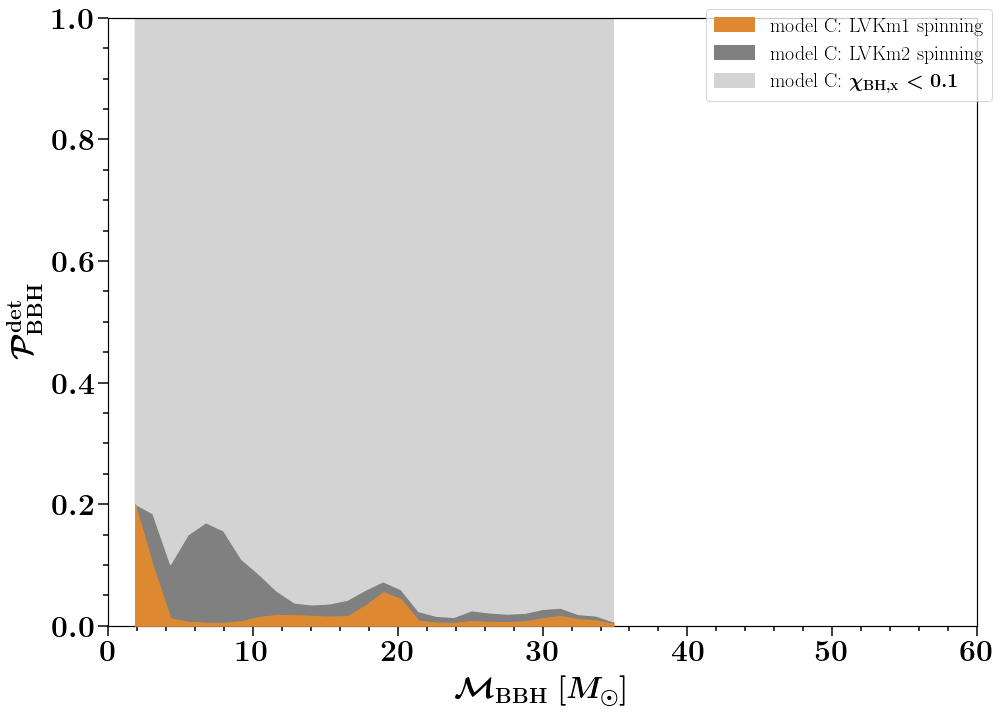

 -----   Now at model  D  -------
nr of weird reversals = 76
nr of normal reversals = 3198447

start calculating spin
6033721 6033721 6033721
done calculating spin

[0.         0.         0.30733575 ... 0.07033949 0.05202271 0.05218486]
0.0 0.9773090922771337
fraction of MRR = 0.7781348963579444
fraction of chirpmass MRR = 0.7781348963579444



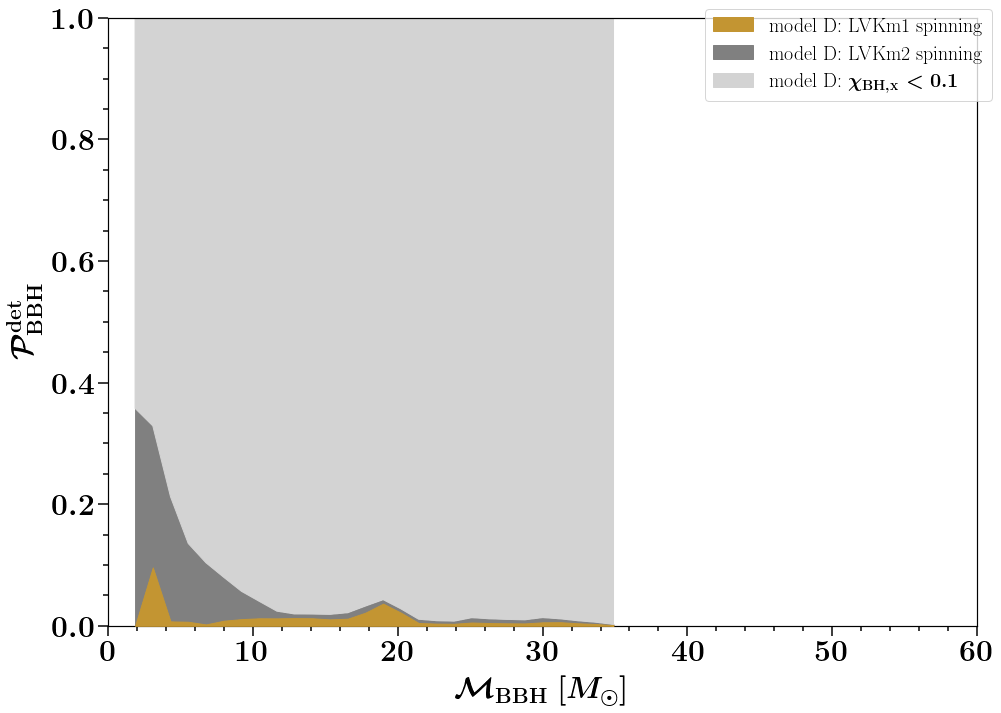

 -----   Now at model  E  -------
nr of weird reversals = 72
nr of normal reversals = 3738724

start calculating spin
9274636 9274636 9274636
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05803907 0.10130044 0.        ]
0.0 0.968960985447689
fraction of MRR = 0.7662586628934711
fraction of chirpmass MRR = 0.7662586628934711



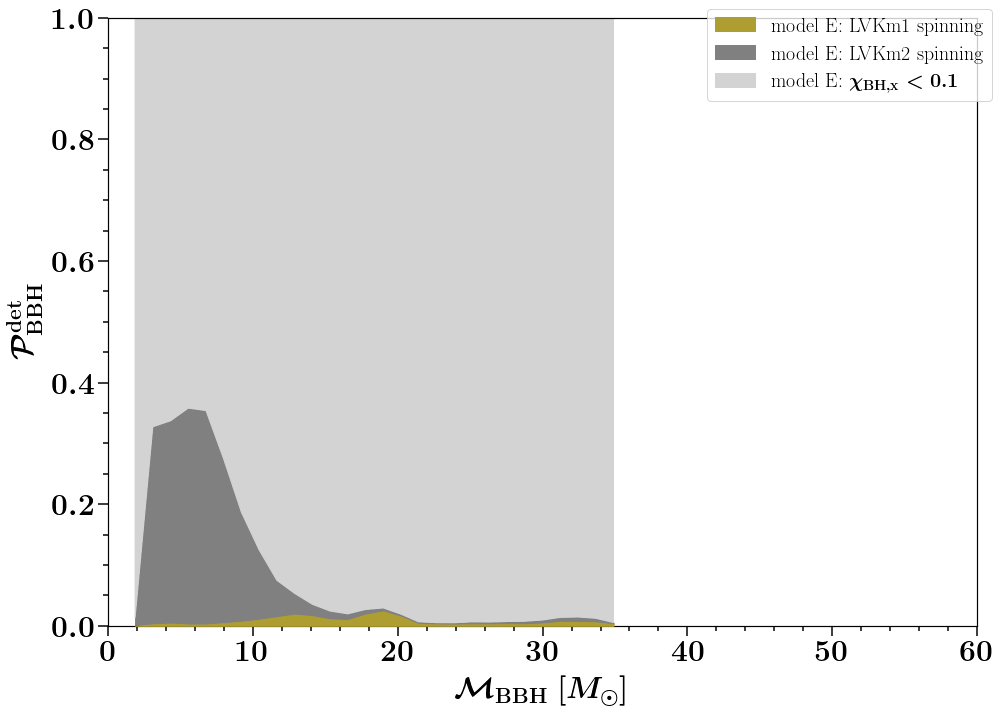

 -----   Now at model  F  -------
nr of weird reversals = 75
nr of normal reversals = 4184150

start calculating spin
9782847 9782847 9782847
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06940923 0.         0.0526679 ]
0.0 0.968960985447689
fraction of MRR = 0.8220913758165747
fraction of chirpmass MRR = 0.8220913758165747



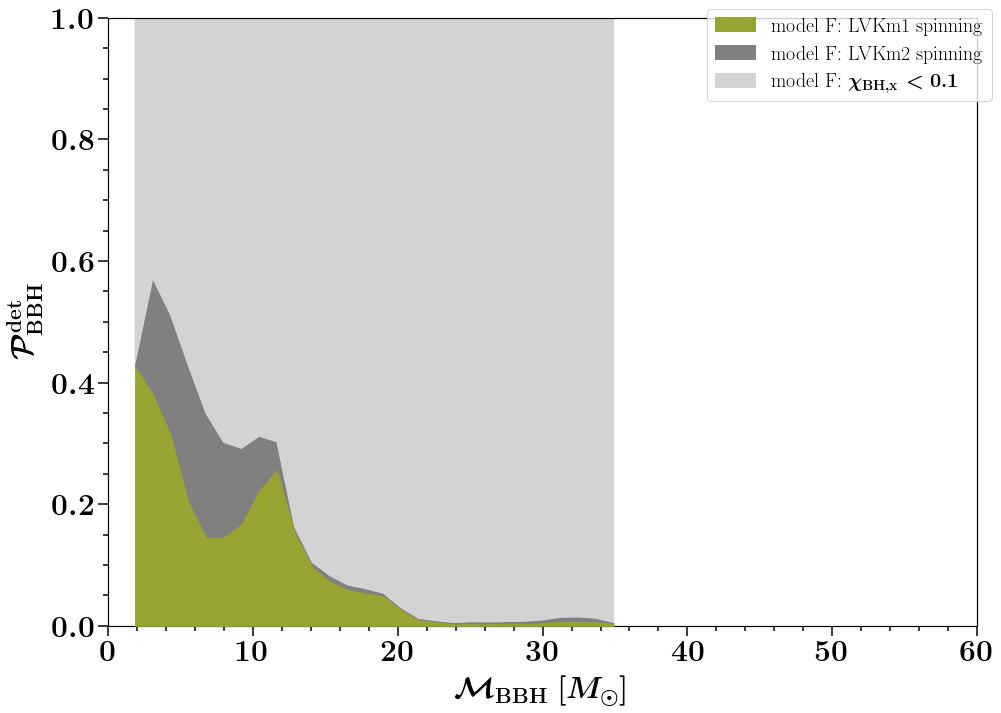

 -----   Now at model  G  -------
nr of weird reversals = 1
nr of normal reversals = 5249825

start calculating spin
6338030 6338030 6338030
done calculating spin

[0.         0.         0.12684785 ... 0.02173637 0.         0.        ]
0.0 0.8451639190519937
fraction of MRR = 0.9130534144077088
fraction of chirpmass MRR = 0.9130534144077088


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


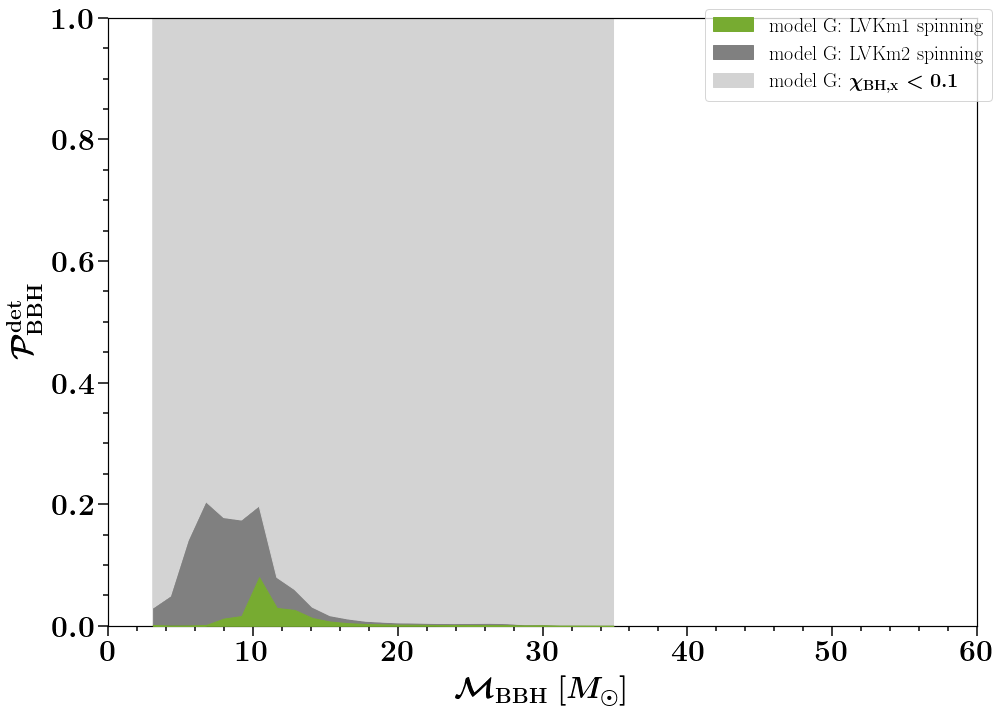

 -----   Now at model  H  -------
nr of weird reversals = 49
nr of normal reversals = 4198914

start calculating spin
7958497 7958497 7958497
done calculating spin

[0.         0.         0.12684785 ... 0.0577554  0.07906623 0.05958168]
0.0 0.9654037458389564
fraction of MRR = 0.793922106207558
fraction of chirpmass MRR = 0.793922106207558


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


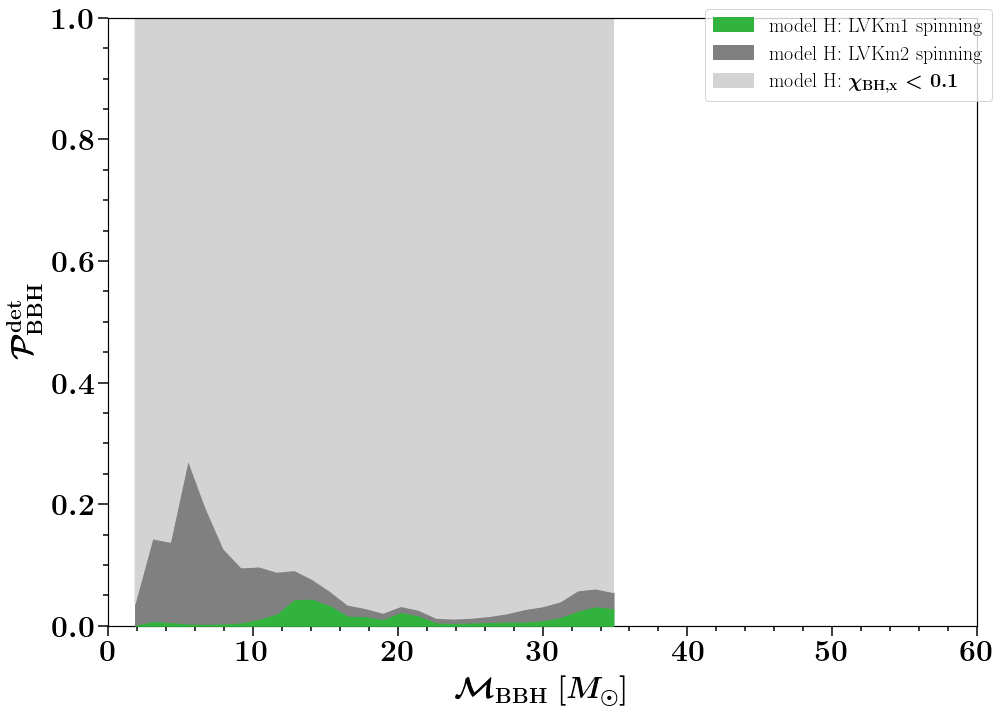

 -----   Now at model  I  -------
nr of weird reversals = 21
nr of normal reversals = 2625001

start calculating spin
6212236 6212236 6212236
done calculating spin

[0.15306977 0.24557262 0.13945493 ... 0.         0.         0.        ]
0.0 0.8463417568626156
fraction of MRR = 0.7057582408051555
fraction of chirpmass MRR = 0.7057582408051555


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


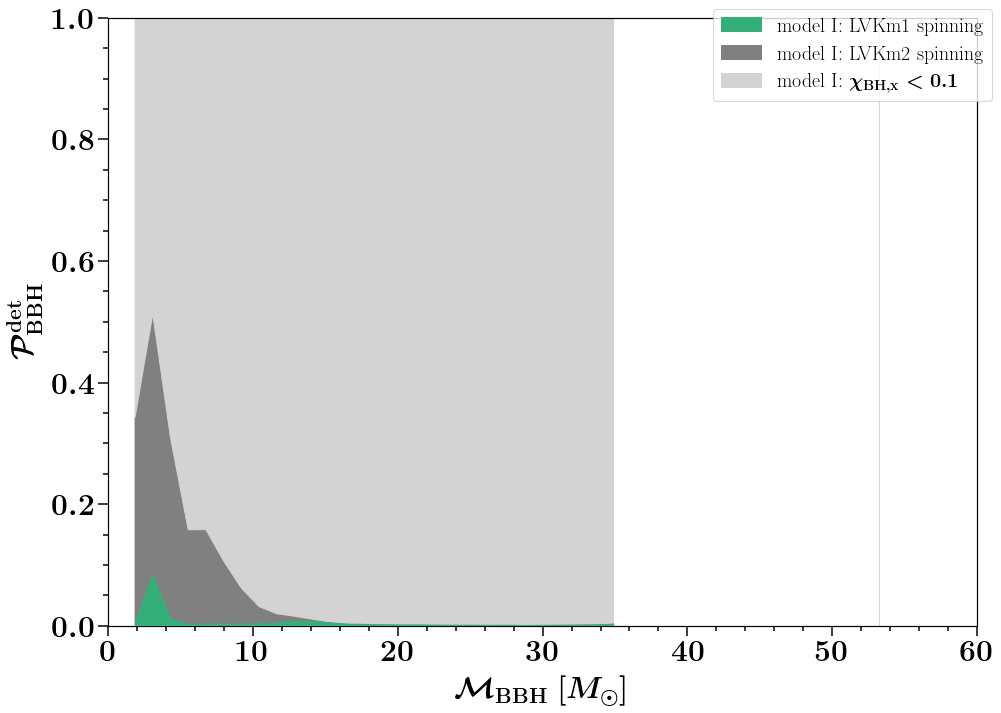

 -----   Now at model  J  -------
nr of weird reversals = 0
nr of normal reversals = 2896842

start calculating spin
3514443 3514443 3514443
done calculating spin

[0. 0. 0. ... 0. 0. 0.]
0.0 0.8251075103857082
fraction of MRR = 0.8906119154012471
fraction of chirpmass MRR = 0.8906119154012471


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


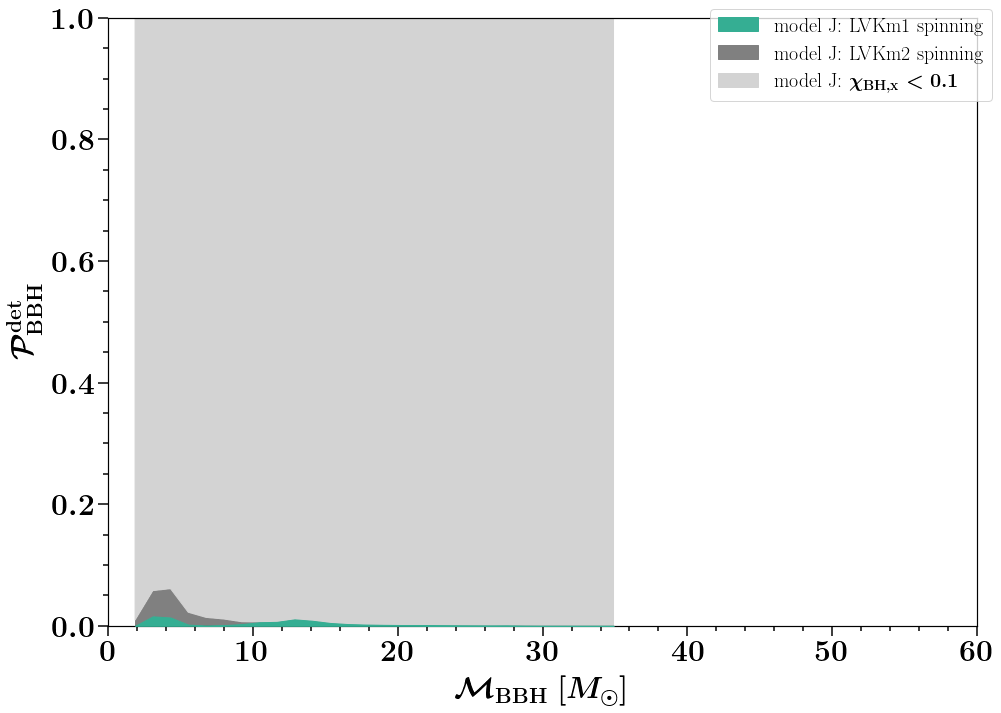

 -----   Now at model  K  -------
nr of weird reversals = 54
nr of normal reversals = 3778868

start calculating spin
8782290 8782290 8782290
done calculating spin

[0.32091348 0.22178376 0.         ... 0.0526679  0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.8210620335586227
fraction of chirpmass MRR = 0.8210620335586227


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


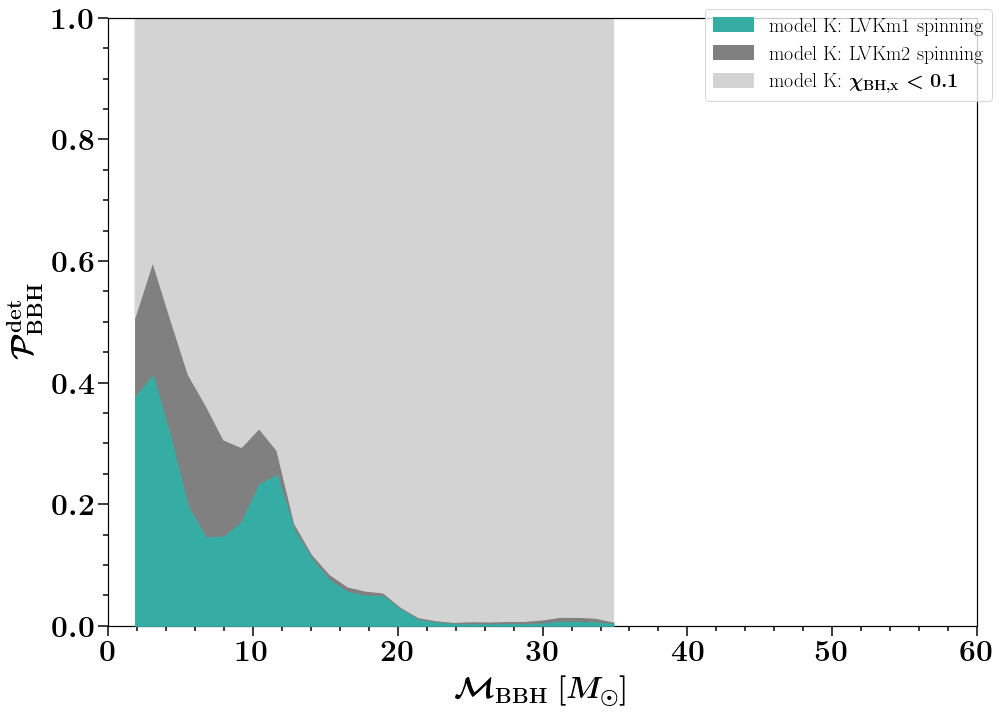

 -----   Now at model  L  -------
nr of weird reversals = 45
nr of normal reversals = 3312573

start calculating spin
7463923 7463923 7463923
done calculating spin

[0.32091348 0.21643375 0.         ... 0.         0.0242101  0.        ]
0.0 0.9656825660540831
fraction of MRR = 0.7657626706716913
fraction of chirpmass MRR = 0.7657626706716913


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


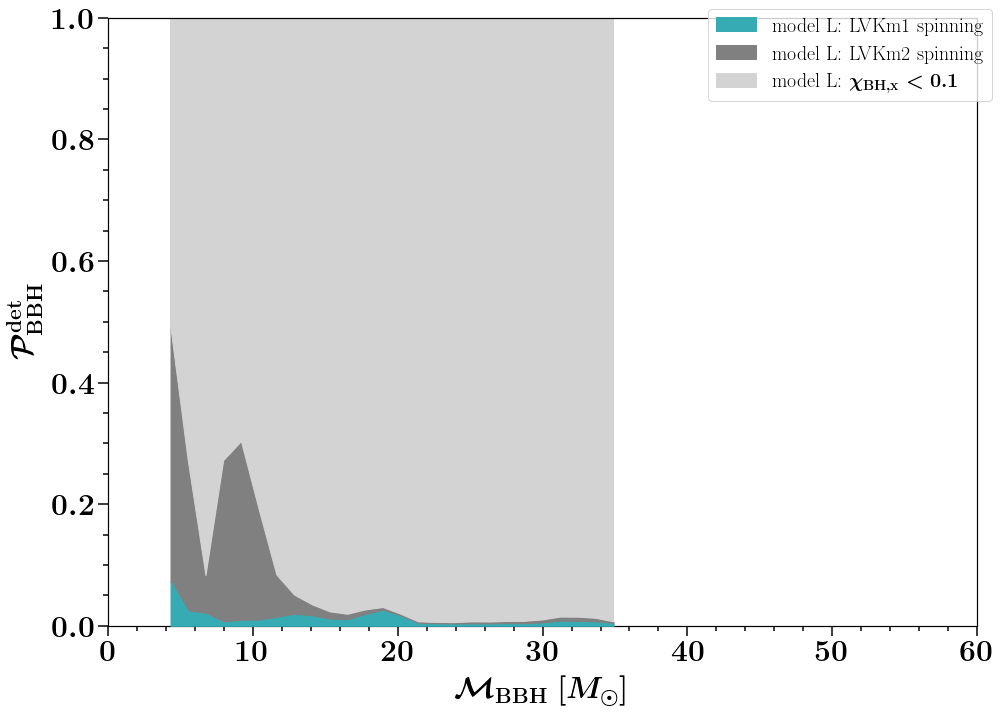

 -----   Now at model  M  -------
nr of weird reversals = 47
nr of normal reversals = 3362507

start calculating spin
8879317 8879317 8879317
done calculating spin

[0.         0.4758284  0.         ... 0.06384771 0.04543831 0.04730882]
0.0 0.9321893488847299
fraction of MRR = 0.7594608028097333
fraction of chirpmass MRR = 0.7594608028097333


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


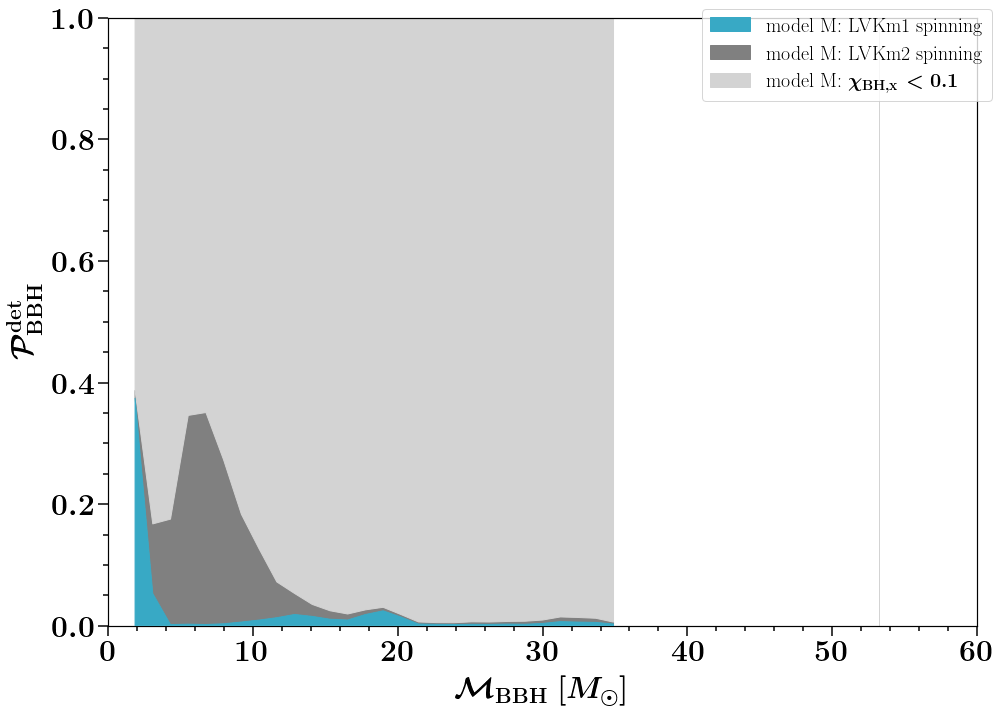

 -----   Now at model  N  -------
nr of weird reversals = 56
nr of normal reversals = 3386237

start calculating spin
7906131 7906131 7906131
done calculating spin

[0.32091348 0.22178376 0.         ... 0.10287358 0.         0.        ]
0.0 0.9618422953660551
fraction of MRR = 0.7732737249820993
fraction of chirpmass MRR = 0.7732737249820993


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


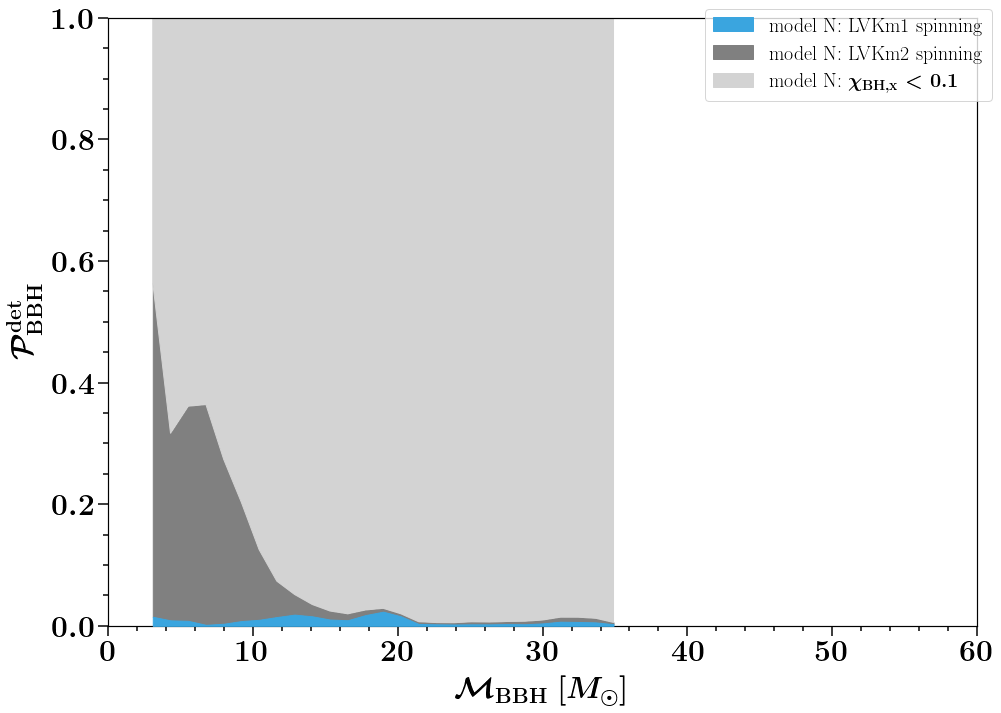

 -----   Now at model  P  -------
nr of weird reversals = 59
nr of normal reversals = 3072402

start calculating spin
8106172 8106172 8106172
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05324282 0.05005554 0.04504702]
0.0 0.9033468343947532
fraction of MRR = 0.7746021422616046
fraction of chirpmass MRR = 0.7746021422616046


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


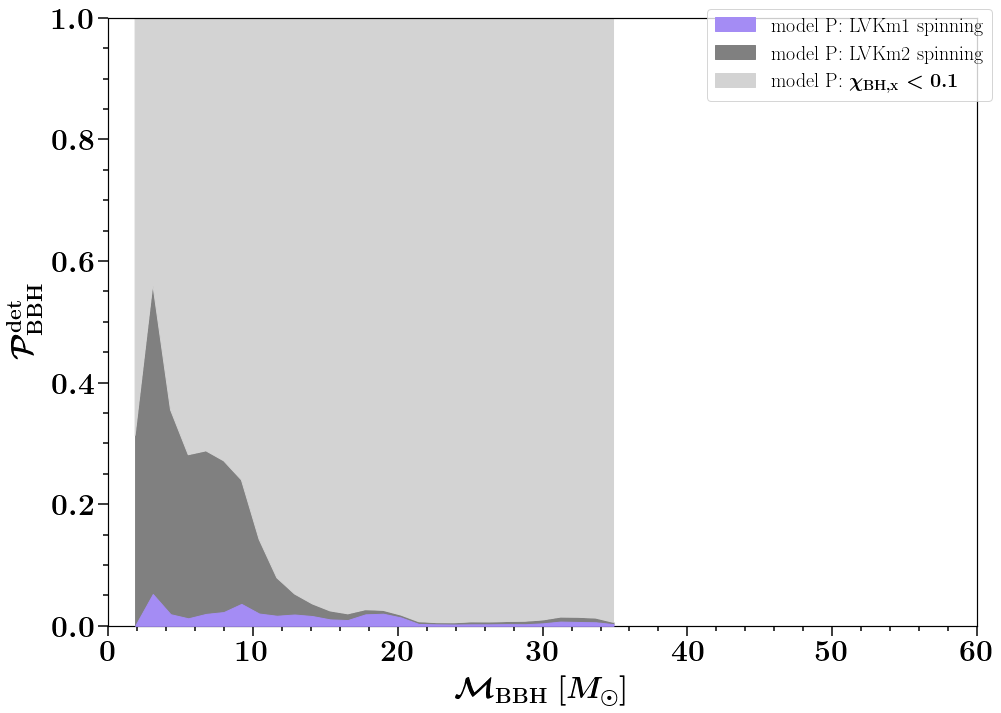

 -----   Now at model  Q  -------
nr of weird reversals = 47
nr of normal reversals = 2863591

start calculating spin
7609741 7609741 7609741
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06336806 0.04382311 0.04536733]
0.0 0.9637871581258313
fraction of MRR = 0.7798375645308337
fraction of chirpmass MRR = 0.7798375645308337


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


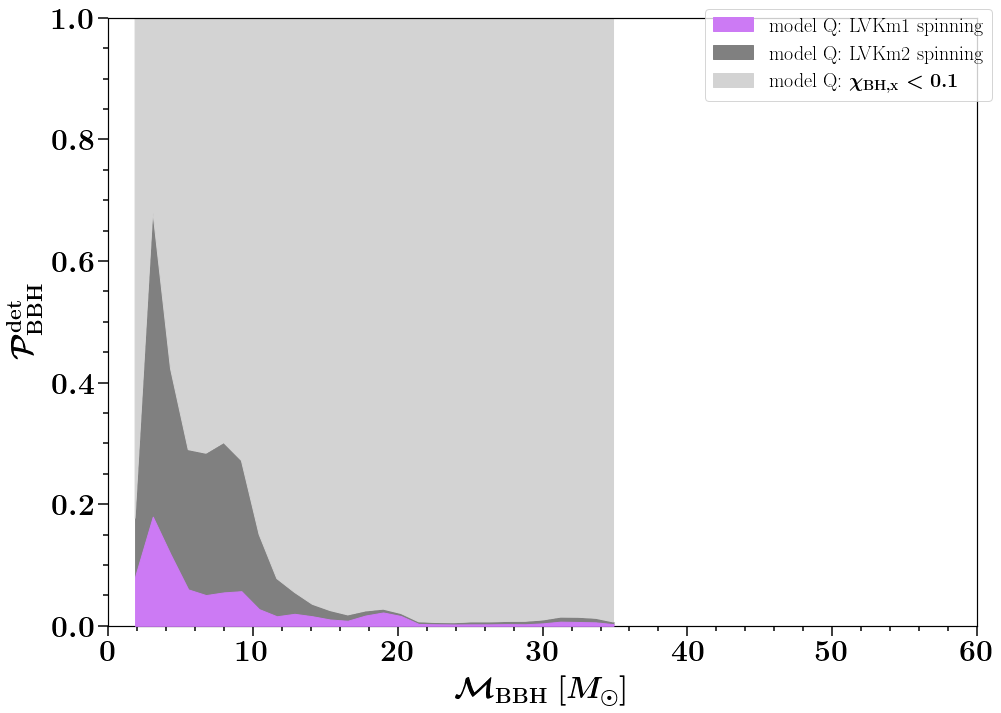

 -----   Now at model  R  -------
nr of weird reversals = 36
nr of normal reversals = 3443320

start calculating spin
8777168 8777168 8777168
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06040639 0.05861127 0.05046864]
0.0 0.9752858229779926
fraction of MRR = 0.7871570218131534
fraction of chirpmass MRR = 0.7871570218131534


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


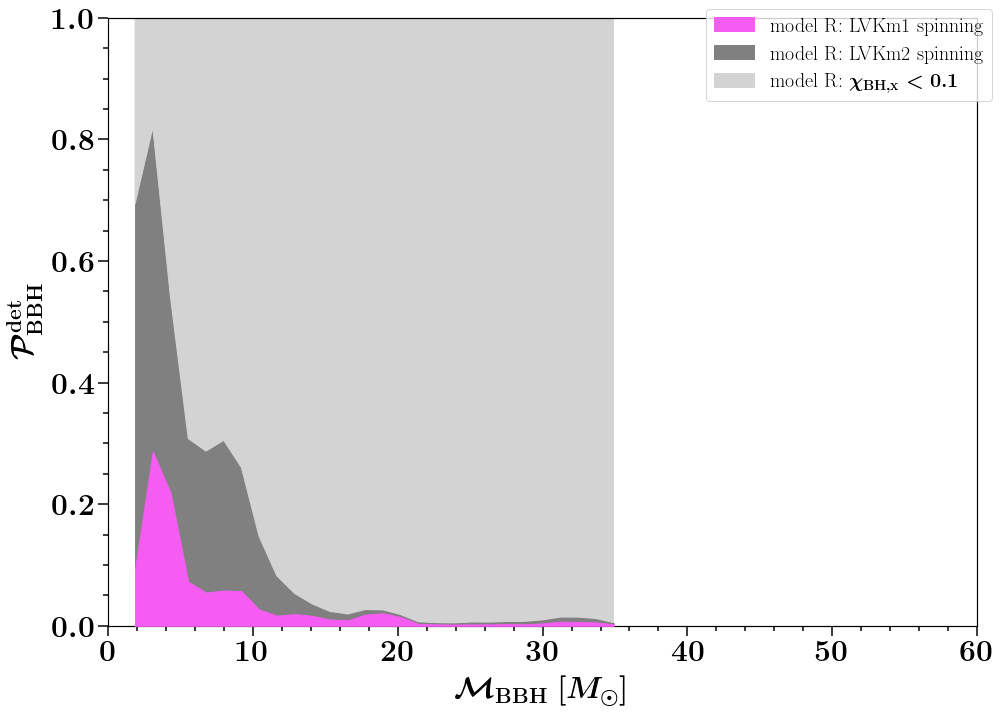

 -----   Now at model  S  -------
nr of weird reversals = 61
nr of normal reversals = 3764159

start calculating spin
8921965 8921965 8921965
done calculating spin

[0.31724994 0.30206939 0.22280807 ... 0.16134563 0.         0.25086565]
0.0 0.9675327892926453
fraction of MRR = 0.8120391674496257
fraction of chirpmass MRR = 0.8120391674496257


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


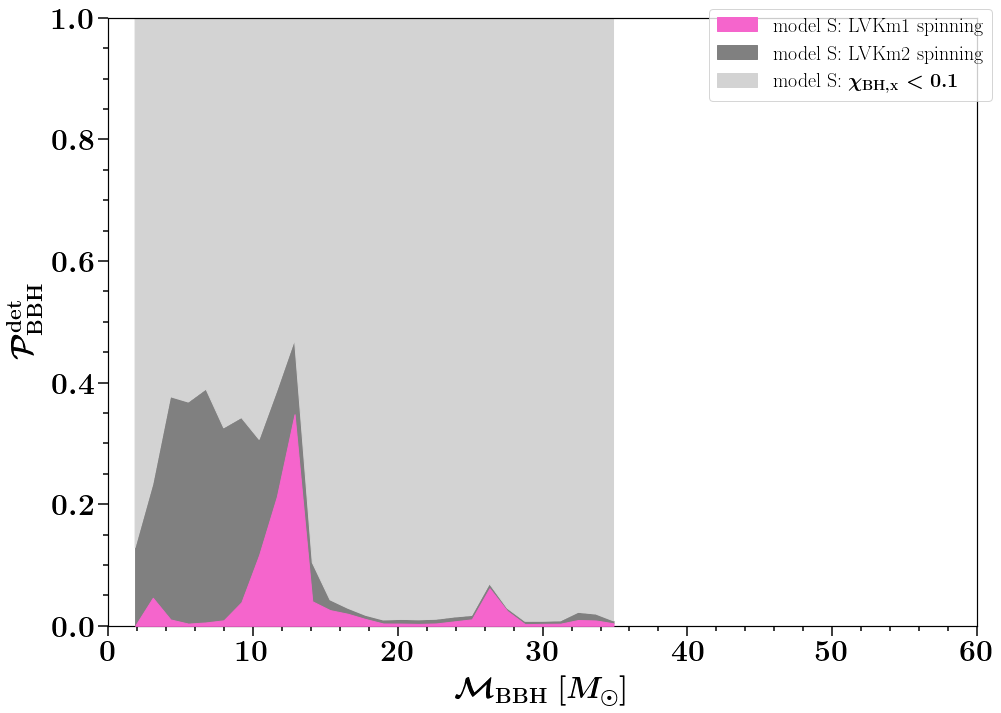

 -----   Now at model  T  -------
nr of weird reversals = 42
nr of normal reversals = 2395444

start calculating spin
6748472 6748472 6748472
done calculating spin

[0.33035537 0.21731945 0.         ... 0.         0.         0.        ]
0.0 0.8434021433330429
fraction of MRR = 0.5947169245927046
fraction of chirpmass MRR = 0.5947169245927046


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


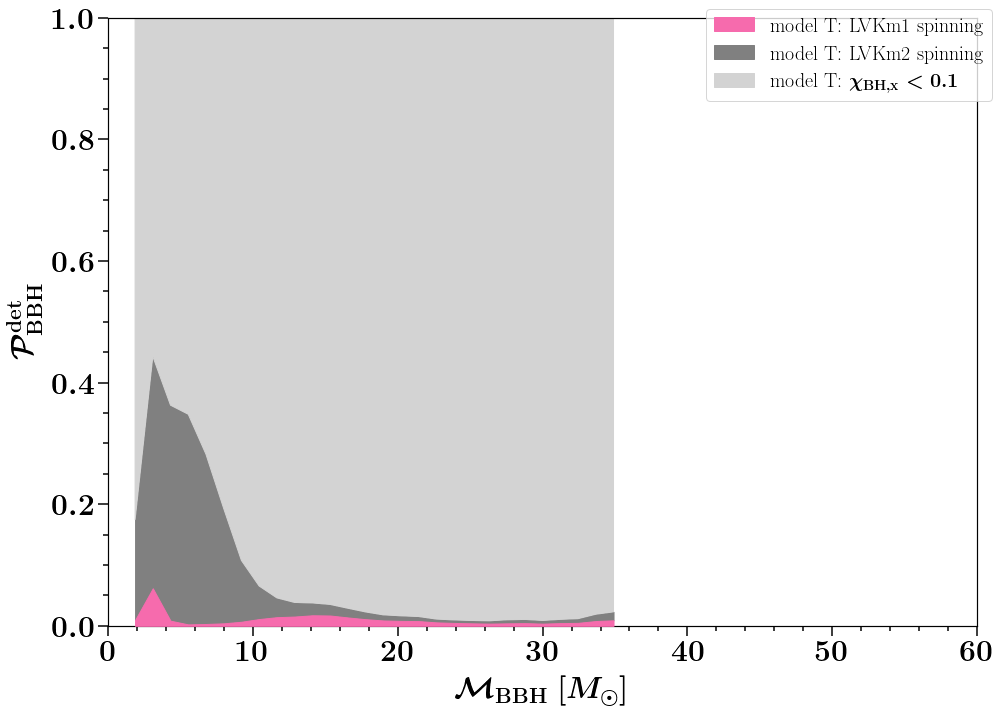

 -----   Now at model  A  -------
nr of weird reversals = 51
nr of normal reversals = 3383143

start calculating spin
8371398 8371398 8371398
done calculating spin

[0.32091348 0.22178376 0.         ... 0.         0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.765737800239734
fraction of MassBH1 MRR = 0.765737800239734


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


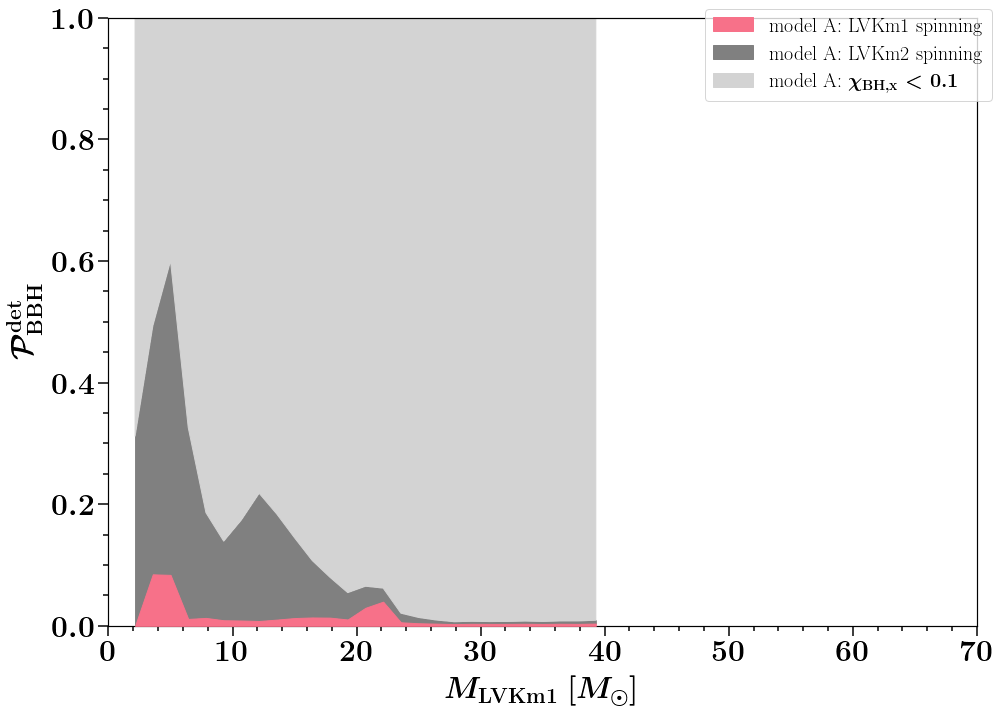

 -----   Now at model  B  -------
nr of weird reversals = 333
nr of normal reversals = 1250362

start calculating spin
8616008 8616008 8616008
done calculating spin

[0.33268279 0.22046352 0.20951969 ... 0.00703039 0.         0.        ]
0.0 0.8584652249957299
fraction of MRR = 0.5384911663504605
fraction of MassBH1 MRR = 0.5384911663504605


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide


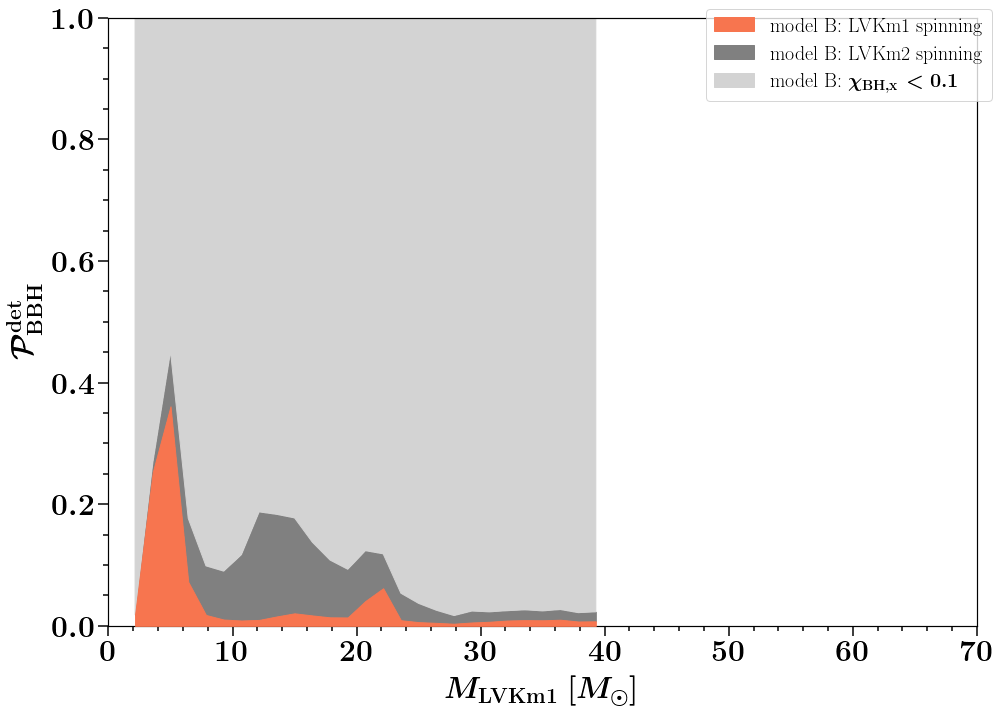

 -----   Now at model  C  -------
nr of weird reversals = 167
nr of normal reversals = 1980432

start calculating spin
6568454 6568454 6568454
done calculating spin

[0.42468494 0.41033956 0.22228283 ... 0.04697682 0.05786438 0.06436117]
0.0 0.8577311071635726
fraction of MRR = 0.6780616289362406
fraction of MassBH1 MRR = 0.6780616289362406



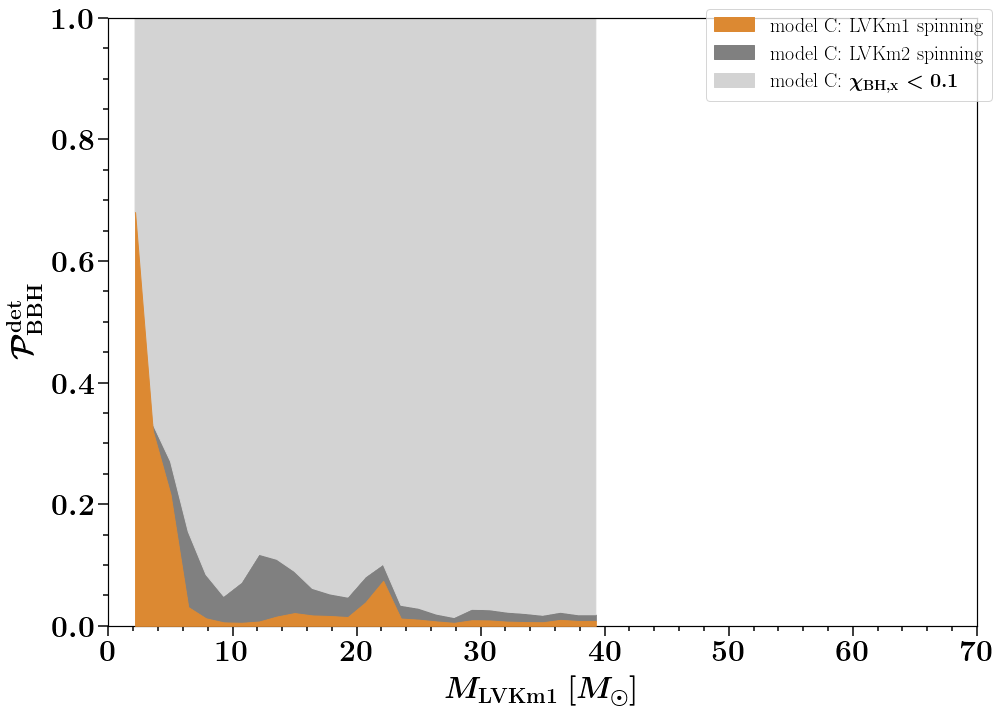

 -----   Now at model  D  -------
nr of weird reversals = 76
nr of normal reversals = 3198447

start calculating spin
6033721 6033721 6033721
done calculating spin

[0.         0.         0.30733575 ... 0.07033949 0.05202271 0.05218486]
0.0 0.9773090922771337
fraction of MRR = 0.7781348963579444
fraction of MassBH1 MRR = 0.7781348963579444



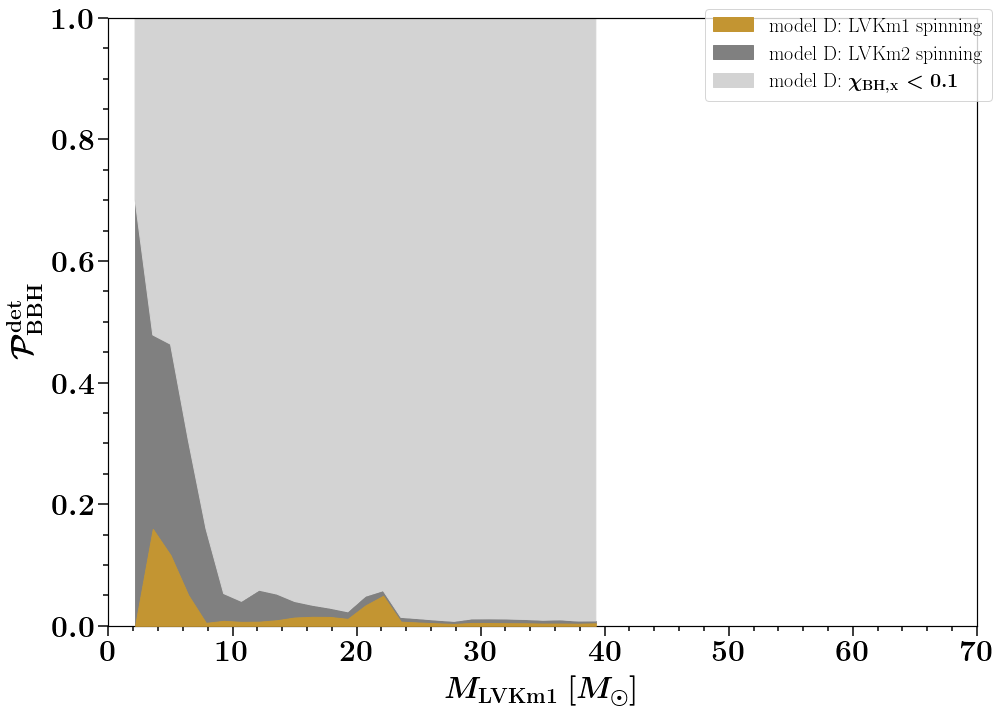

 -----   Now at model  E  -------
nr of weird reversals = 72
nr of normal reversals = 3738724

start calculating spin
9274636 9274636 9274636
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05803907 0.10130044 0.        ]
0.0 0.968960985447689
fraction of MRR = 0.7662586628934711
fraction of MassBH1 MRR = 0.7662586628934711



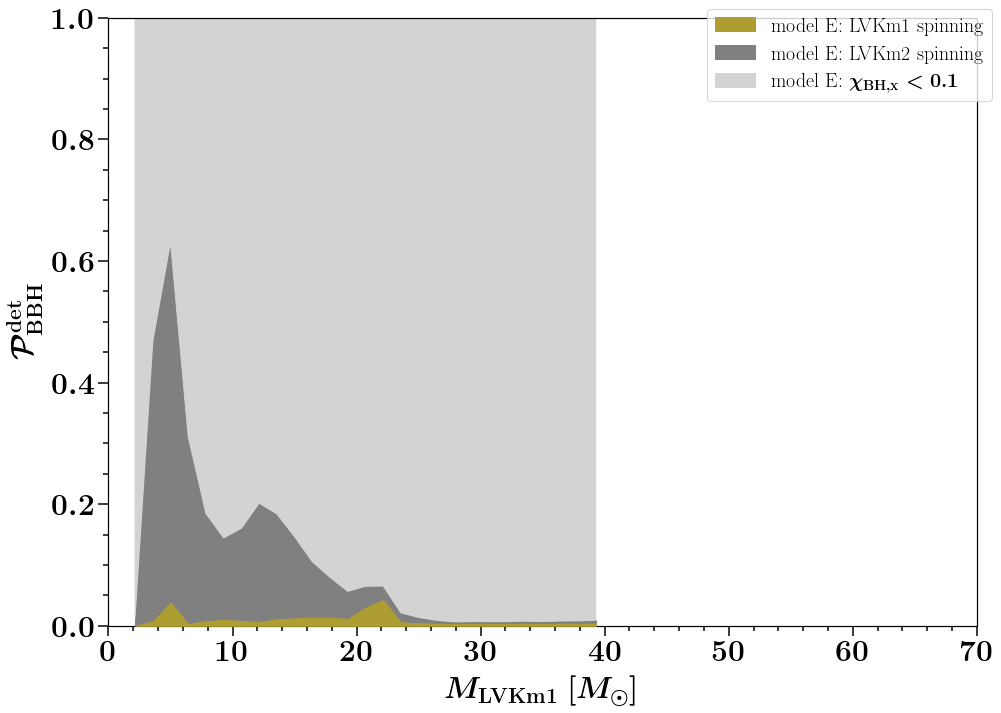

 -----   Now at model  F  -------
nr of weird reversals = 75
nr of normal reversals = 4184150

start calculating spin
9782847 9782847 9782847
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06940923 0.         0.0526679 ]
0.0 0.968960985447689
fraction of MRR = 0.8220913758165747
fraction of MassBH1 MRR = 0.8220913758165747



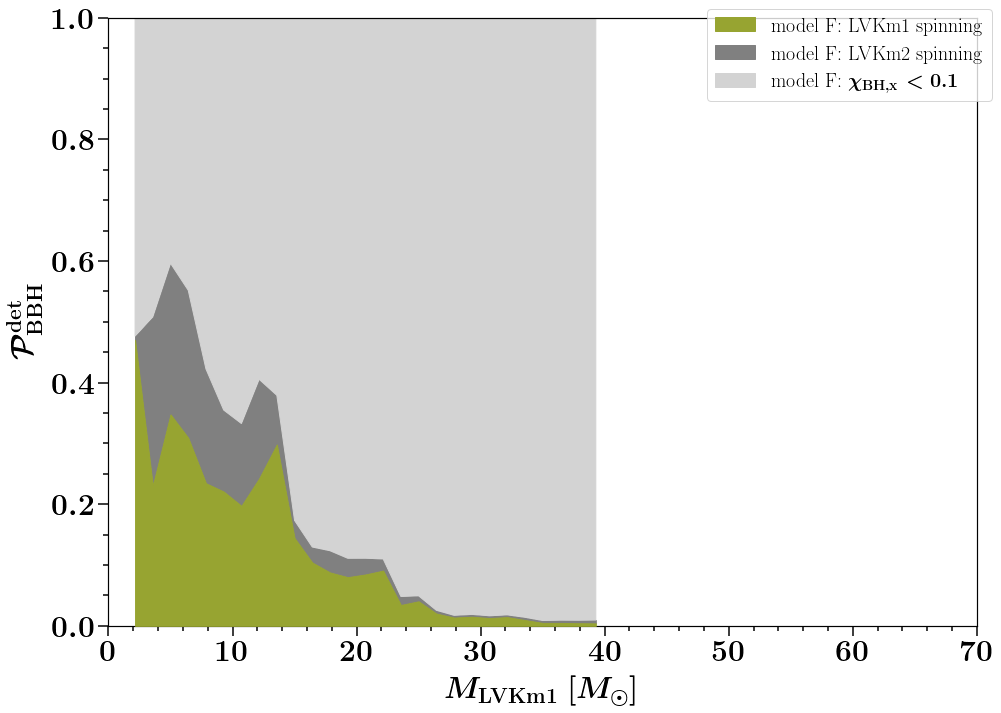

 -----   Now at model  G  -------
nr of weird reversals = 1
nr of normal reversals = 5249825

start calculating spin
6338030 6338030 6338030
done calculating spin

[0.         0.         0.12684785 ... 0.02173637 0.         0.        ]
0.0 0.8451639190519937
fraction of MRR = 0.9130534144077088
fraction of MassBH1 MRR = 0.9130534144077088



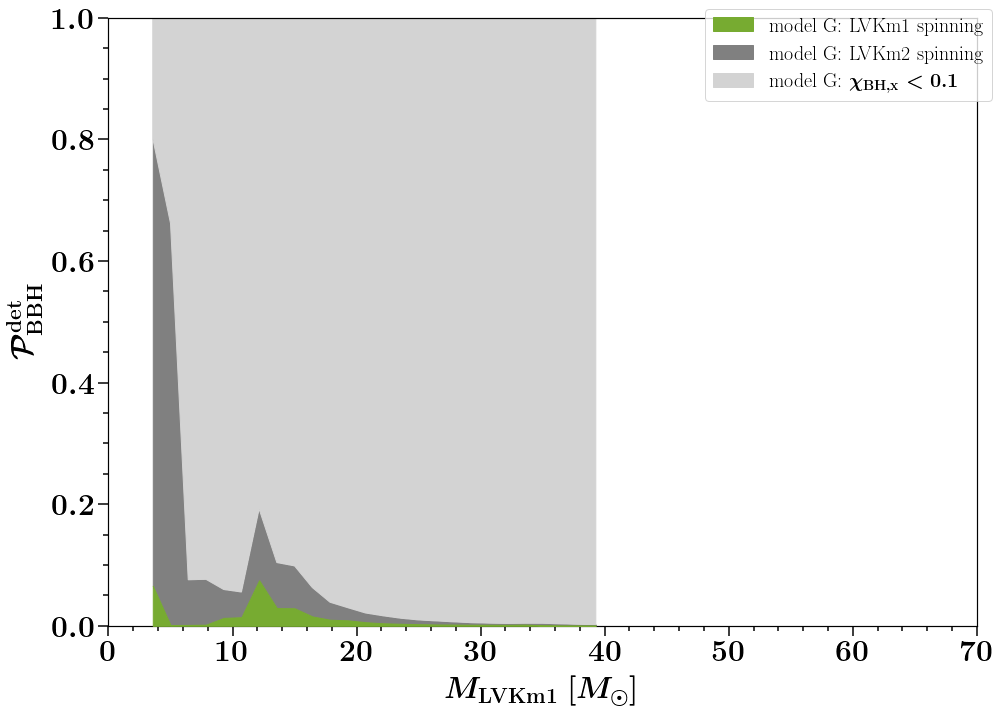

 -----   Now at model  H  -------
nr of weird reversals = 49
nr of normal reversals = 4198914

start calculating spin
7958497 7958497 7958497
done calculating spin

[0.         0.         0.12684785 ... 0.0577554  0.07906623 0.05958168]
0.0 0.9654037458389564
fraction of MRR = 0.793922106207558
fraction of MassBH1 MRR = 0.793922106207558



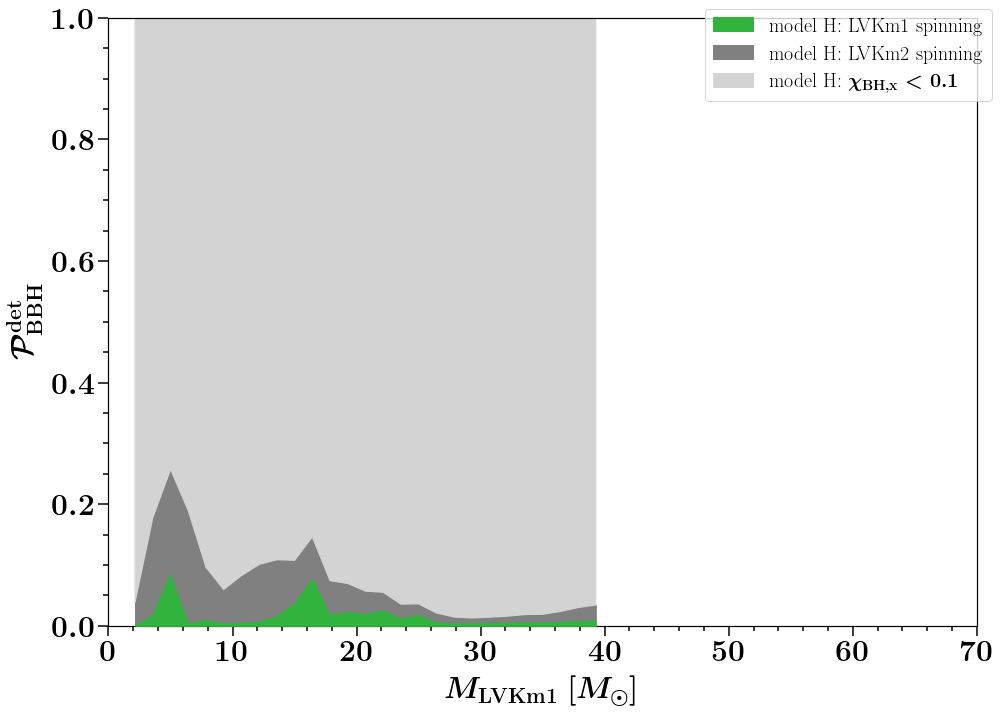

 -----   Now at model  I  -------
nr of weird reversals = 21
nr of normal reversals = 2625001

start calculating spin
6212236 6212236 6212236
done calculating spin

[0.15306977 0.24557262 0.13945493 ... 0.         0.         0.        ]
0.0 0.8463417568626156
fraction of MRR = 0.7057582408051555
fraction of MassBH1 MRR = 0.7057582408051555



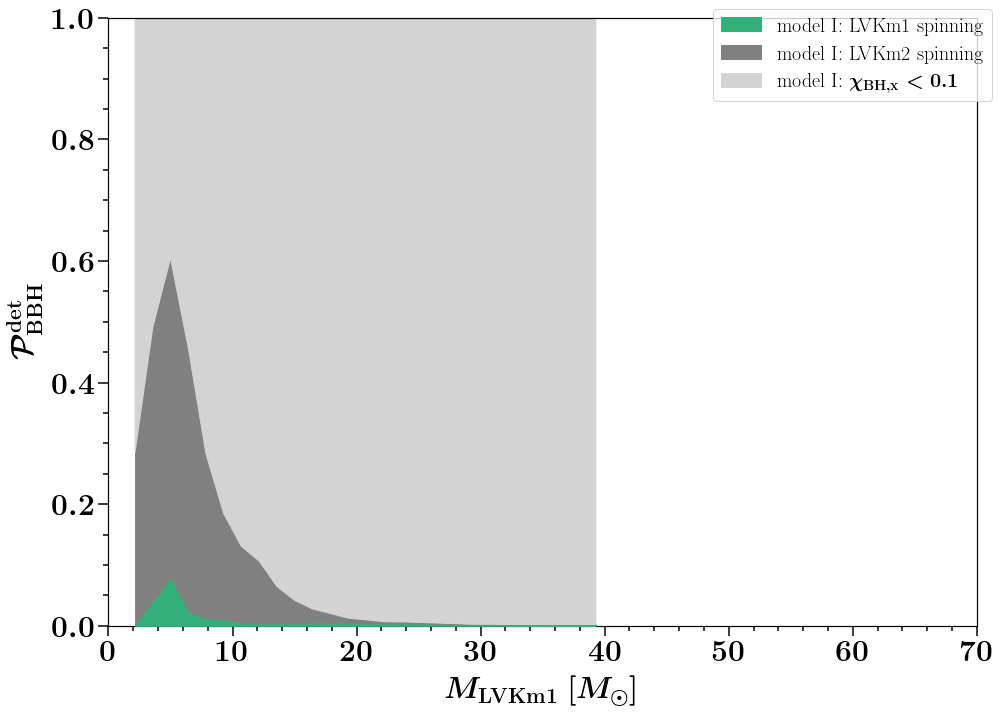

 -----   Now at model  J  -------
nr of weird reversals = 0
nr of normal reversals = 2896842

start calculating spin
3514443 3514443 3514443
done calculating spin

[0. 0. 0. ... 0. 0. 0.]
0.0 0.8251075103857082
fraction of MRR = 0.8906119154012471
fraction of MassBH1 MRR = 0.8906119154012471



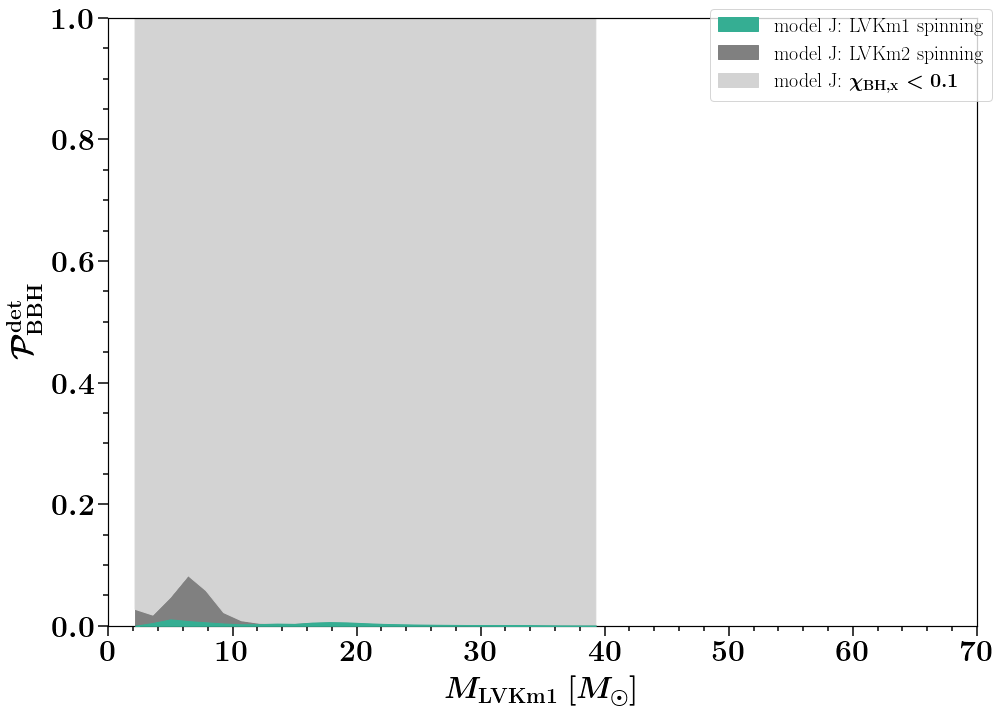

 -----   Now at model  K  -------
nr of weird reversals = 54
nr of normal reversals = 3778868

start calculating spin
8782290 8782290 8782290
done calculating spin

[0.32091348 0.22178376 0.         ... 0.0526679  0.         0.        ]
0.0 0.9617830212550728
fraction of MRR = 0.8210620335586227
fraction of MassBH1 MRR = 0.8210620335586227



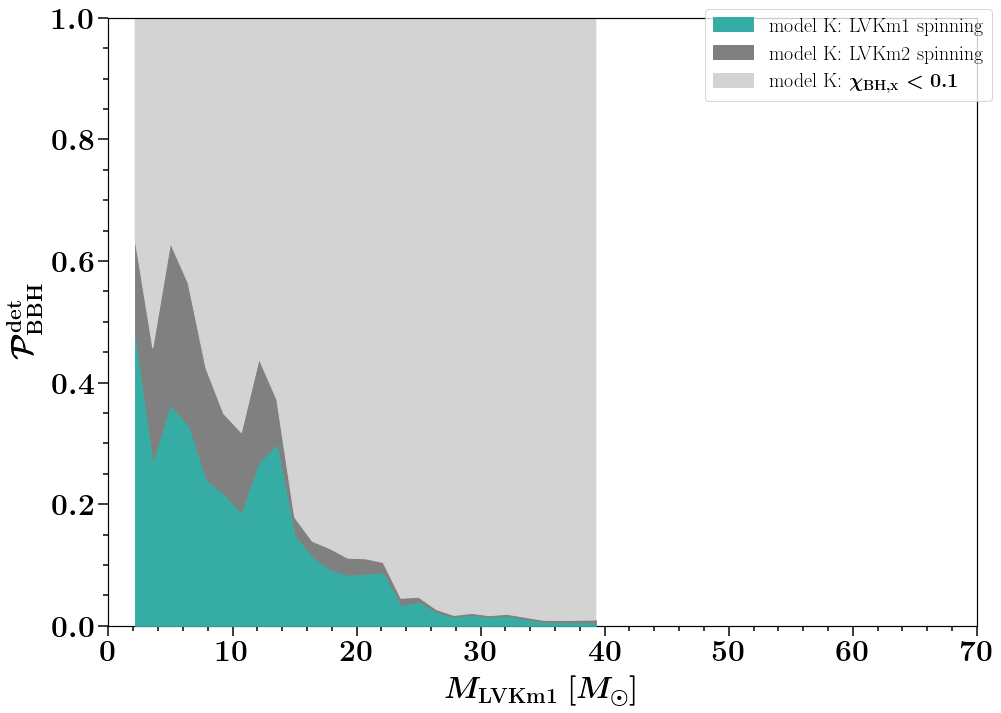

 -----   Now at model  L  -------
nr of weird reversals = 45
nr of normal reversals = 3312573

start calculating spin
7463923 7463923 7463923
done calculating spin

[0.32091348 0.21643375 0.         ... 0.         0.0242101  0.        ]
0.0 0.9656825660540831
fraction of MRR = 0.7657626706716913
fraction of MassBH1 MRR = 0.7657626706716913



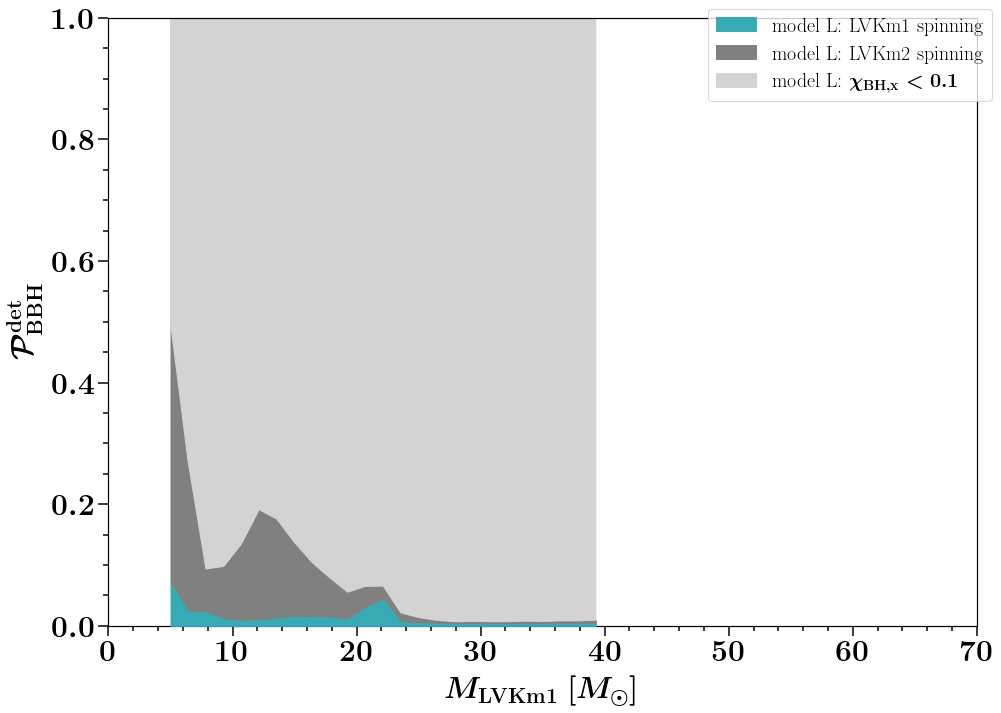

 -----   Now at model  M  -------
nr of weird reversals = 47
nr of normal reversals = 3362507

start calculating spin
8879317 8879317 8879317
done calculating spin

[0.         0.4758284  0.         ... 0.06384771 0.04543831 0.04730882]
0.0 0.9321893488847299
fraction of MRR = 0.7594608028097333
fraction of MassBH1 MRR = 0.7594608028097333



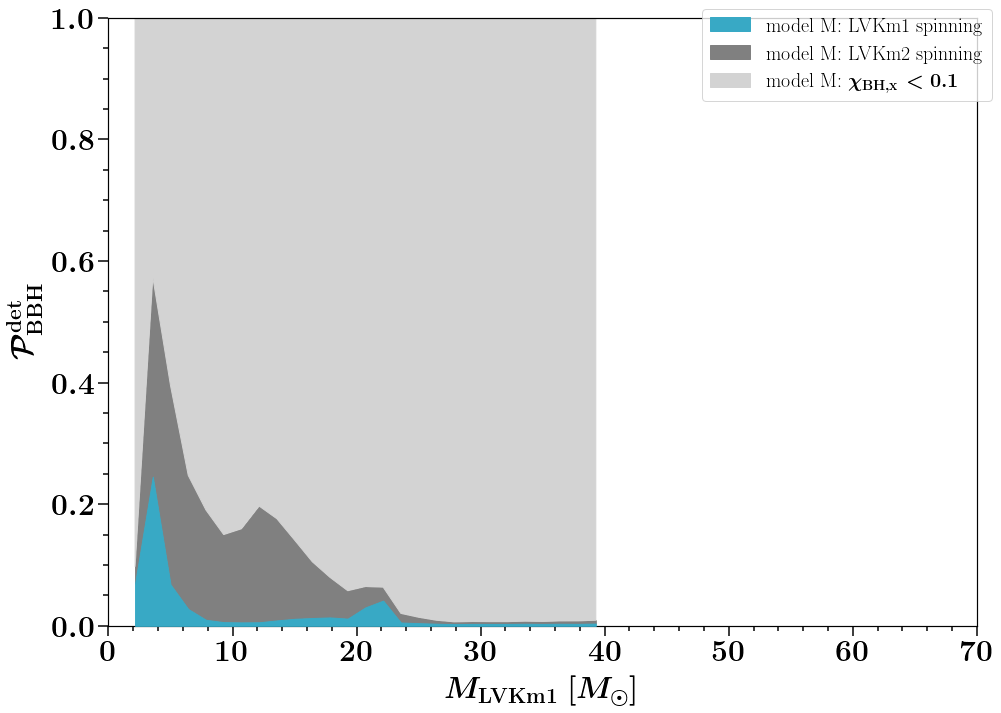

 -----   Now at model  N  -------
nr of weird reversals = 56
nr of normal reversals = 3386237

start calculating spin
7906131 7906131 7906131
done calculating spin

[0.32091348 0.22178376 0.         ... 0.10287358 0.         0.        ]
0.0 0.9618422953660551
fraction of MRR = 0.7732737249820993
fraction of MassBH1 MRR = 0.7732737249820993



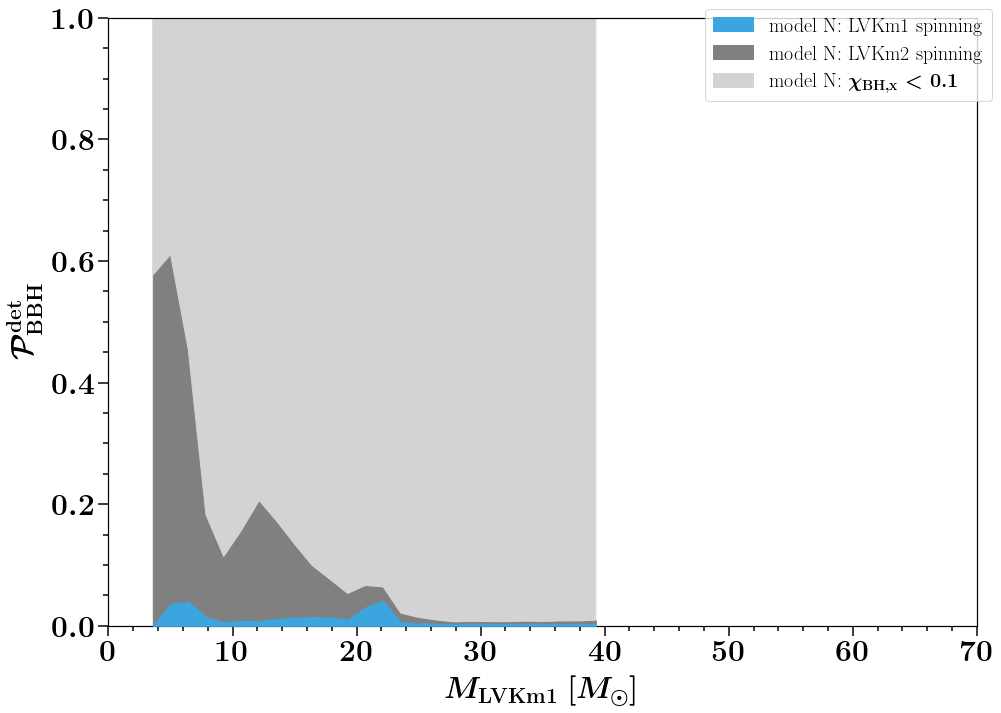

 -----   Now at model  P  -------
nr of weird reversals = 59
nr of normal reversals = 3072402

start calculating spin
8106172 8106172 8106172
done calculating spin

[0.32091348 0.22178376 0.         ... 0.05324282 0.05005554 0.04504702]
0.0 0.9033468343947532
fraction of MRR = 0.7746021422616046
fraction of MassBH1 MRR = 0.7746021422616046



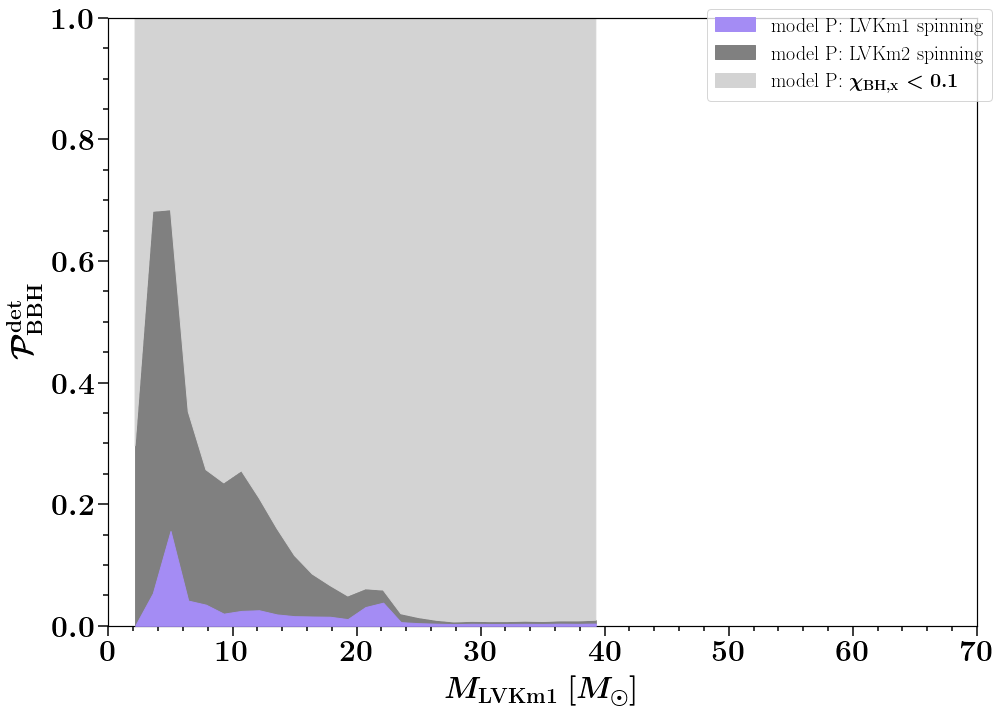

 -----   Now at model  Q  -------
nr of weird reversals = 47
nr of normal reversals = 2863591

start calculating spin
7609741 7609741 7609741
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06336806 0.04382311 0.04536733]
0.0 0.9637871581258313
fraction of MRR = 0.7798375645308337
fraction of MassBH1 MRR = 0.7798375645308337



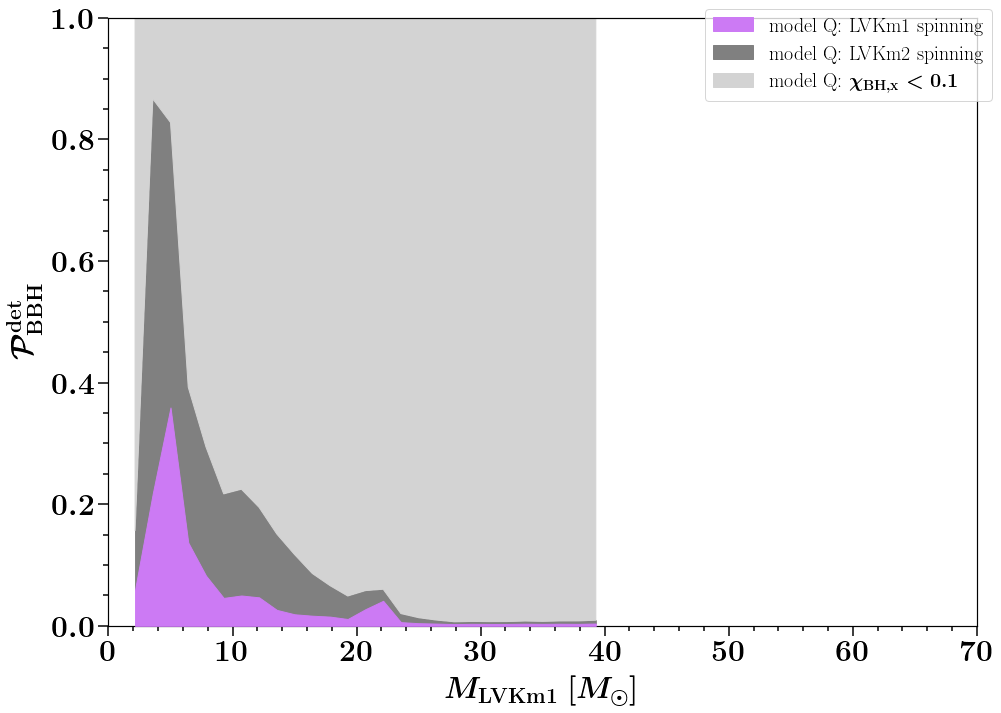

 -----   Now at model  R  -------
nr of weird reversals = 36
nr of normal reversals = 3443320

start calculating spin
8777168 8777168 8777168
done calculating spin

[0.32091348 0.22178376 0.         ... 0.06040639 0.05861127 0.05046864]
0.0 0.9752858229779926
fraction of MRR = 0.7871570218131534
fraction of MassBH1 MRR = 0.7871570218131534



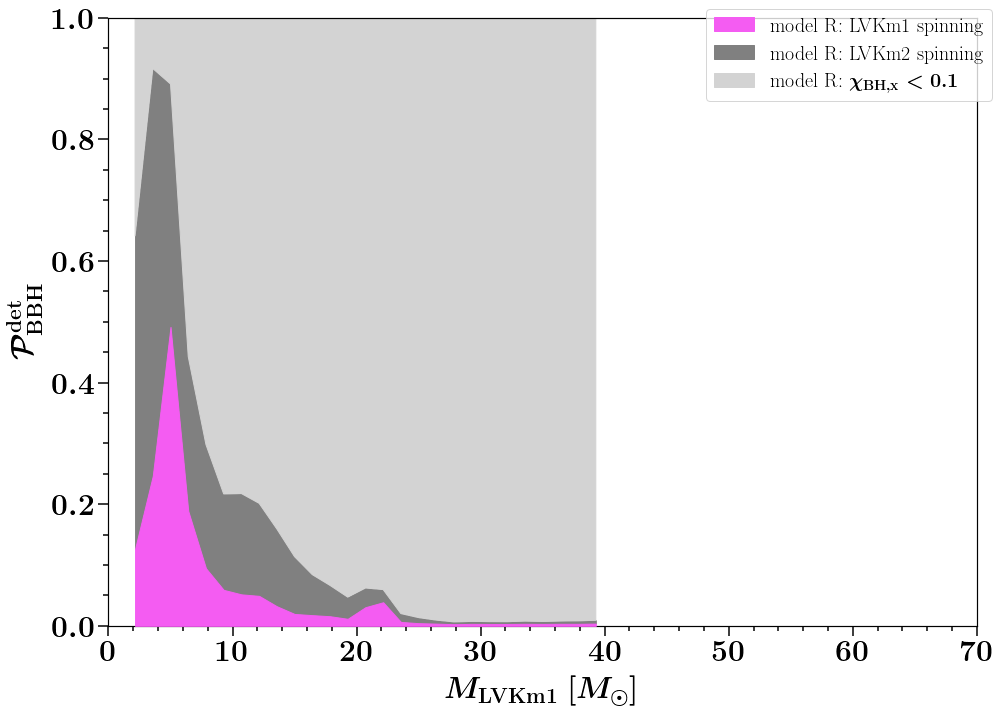

 -----   Now at model  S  -------
nr of weird reversals = 61
nr of normal reversals = 3764159

start calculating spin
8921965 8921965 8921965
done calculating spin

[0.31724994 0.30206939 0.22280807 ... 0.16134563 0.         0.25086565]
0.0 0.9675327892926453
fraction of MRR = 0.8120391674496257
fraction of MassBH1 MRR = 0.8120391674496257



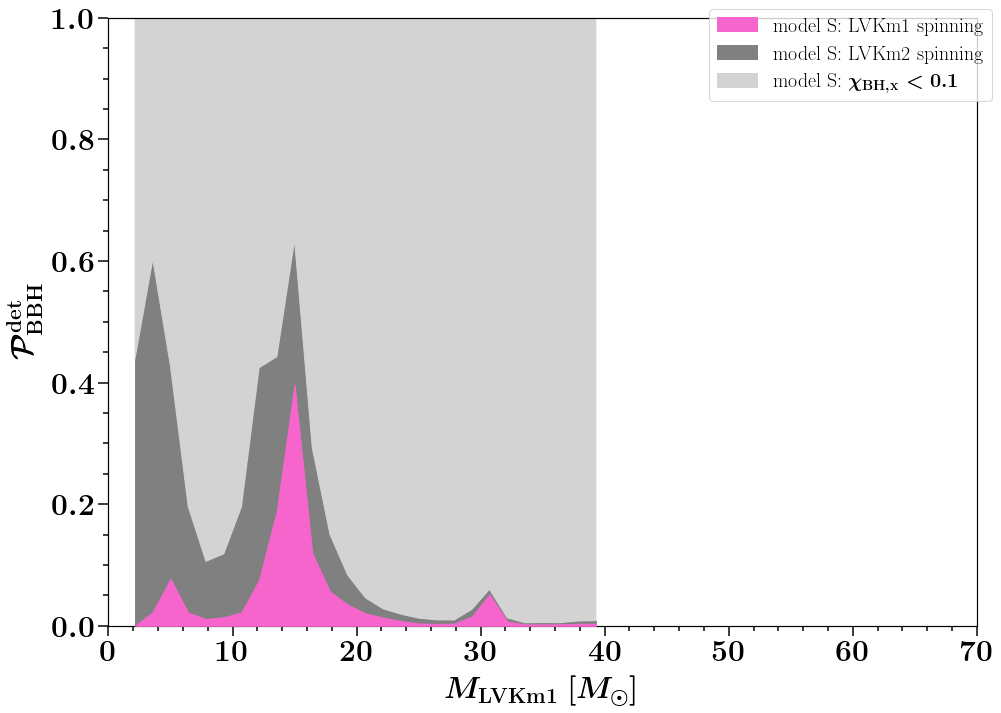

 -----   Now at model  T  -------
nr of weird reversals = 42
nr of normal reversals = 2395444

start calculating spin
6748472 6748472 6748472
done calculating spin

[0.33035537 0.21731945 0.         ... 0.         0.         0.        ]
0.0 0.8434021433330429
fraction of MRR = 0.5947169245927046
fraction of MassBH1 MRR = 0.5947169245927046



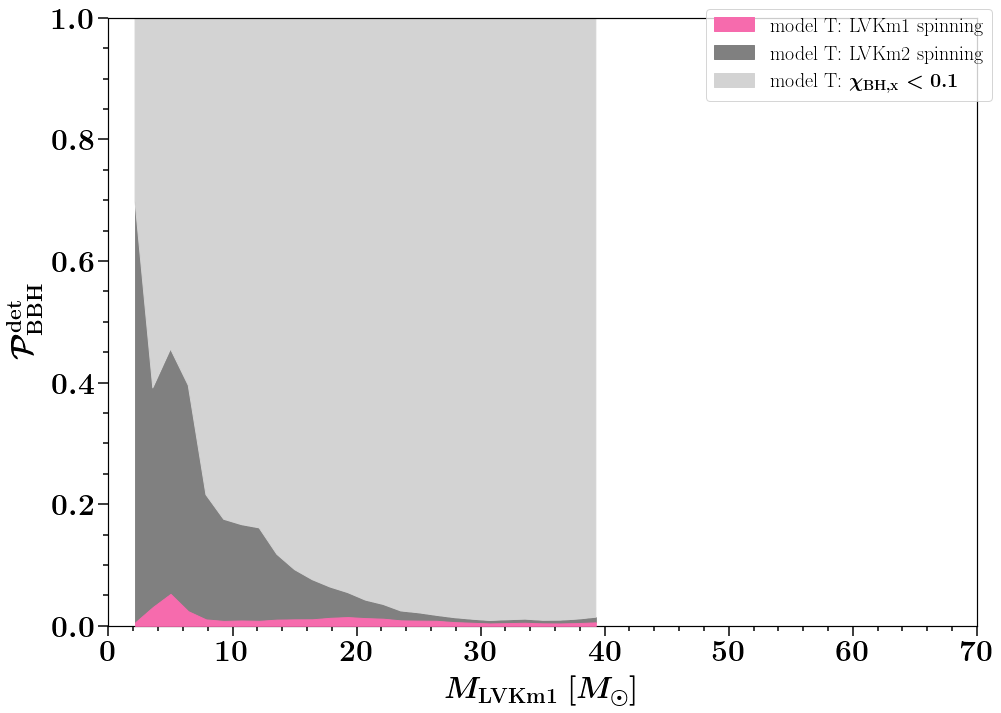

In [20]:
plotMRR_ProbTotal(which_param = 'chirpmass')
plotMRR_ProbTotal(which_param = 'MassBH1')

# MRR PLOTS 

In [ ]:
fs=20
import math 



def plotqlines(ax, qlist, qtextvalue):
    """qlist = [5., 3.333333334, 2., 1.]"""
    ## Add constant mass ratio lines 
    x_q = np.linspace(1,50) # Msun, M1 range
    # plot a few fixed mass ratios:
#     xmin = 1 
    xmin, xmax = 1, 50 
    ymin, ymax = 1, 50
    for ind_q, qvalue in enumerate(qlist):
        y_q =  x_q / qvalue


        y_text = 28 # Msun 
        if y_text*qvalue < 50:
            x_text = y_text * qvalue 
        else: 
            x_text = 40.
            y_text = x_text / qvalue

        # I am calculating the angle theta for the text: (see notes on this)
        delta_y = ((y_text - ymin) / (ymax-ymin)) 
        delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
        ratio = delta_y / delta_x
        theta_angle = math.degrees(math.atan((ratio)))

        ax.plot(x_q, y_q, c='k', lw=2, linestyle =':', zorder=1E6)
        ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
                       horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        







def plotMRR_Prob(which_param='chi_BH1'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
#     fig, axe = plt.subplots(1,1, figsize=(14,10),\
#                            gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})

    
    
    fs_l = 20 # label fontsize  
    
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
               r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      

    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
           r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']    
    
    
    

    DCOtype='BBH'
 
    for BPSmodelName in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',  'P', 'Q', 'R', 'S', 'T']:
        fig, axe = plt.subplots(1,1, figsize=(14,10),\
                               gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})   

        print(' -----   Now at model ', BPSmodelName, ' -------')

#         mssfr = '112' # mssfr that matches LIGO observed rates.
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)


        M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
        M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
        MRR_mask = (M2BH>M1BH) # THe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatioBBH = M2/M1

        ### FOR SPIN ###
        seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
        seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
        # get only SN seeds for DCOs 
        maskSNdco = np.in1d(seedsSN,  seedsDCO) 
        whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
        whichSN1 = whichSN[::2] # get whichStar for first SN 


        separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
        separationPreSN2 = separationPreSN[1::2] # in Rsun. 
        MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  

        # the second SN is the most massive BH 
        maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  

        mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
        mask_2 = ((whichSN1==1) & (M1BH<M2BH))

        print('nr of weird reversals = %s'%np.sum(mask_temp))
        print('nr of normal reversals = %s'%np.sum(mask_2))
        
        
        print()
        print('start calculating spin')
        spin = COspin(data_path=path)  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
        
        
        spinM1, spinM2 = np.zeros(len(spinMZAMS1)), np.zeros(len(spinMZAMS1))
        spinM1[MRR_mask] = spinMZAMS2[MRR_mask]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinM1[~MRR_mask] = spinMZAMS1[~MRR_mask]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinM2[MRR_mask] = spinMZAMS1[MRR_mask]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinM2[~MRR_mask] = spinMZAMS2[~MRR_mask]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     
        
        
        print('done calculating spin')
        print()
        
        if which_param=='chi_BH1':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = '$\chi_{\rm{1}}$ (detected M1)'
            
        if which_param=='chi_BH2':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = r'$\chi_{\rm{2}} $ (detected M2)'
            
        elif which_param=='MassRatio':
            xparam = MassRatioBBH
            x_grid = np.linspace(0,1, 50)
            xlabel = r'$q_{\rm{BBH}}$'
        
        x_grid_centers = (x_grid[:-1] + x_grid[1:])/2
        
        for mssfr in ['112']:
            # get detected weights
            fparam_key = 'weights_detected'
            weightheader = 'w_' + mssfr
            weights_ = fdata[fparam_key][weightheader][...].squeeze()
            w = weights_

            
            

            print('fraction of MRR = %s'%(np.sum(w[MRR_mask])/np.sum(w)))
            print('fraction of %s MRR = %s'%(which_param, (np.sum(w[MRR_mask][xparam[MRR_mask]>0.1])/np.sum(w[xparam > 0.1]))))


            hist_MRR, _ = np.histogram(xparam[MRR_mask], x_grid, weights=w[MRR_mask], density=False)
            hist_notMRR, _ = np.histogram(xparam[~MRR_mask], x_grid, weights=w[~MRR_mask], density=False)

#             print(hist_MRR/(hist_MRR+hist_notMRR))
#             print(200*np.ones_like(hist_MRR))
#             print(x_grid_centers)
#             print(len(hist_MRR/(hist_MRR+hist_notMRR)))
#             print(len(200*np.ones_like(hist_MRR)))
#             print(len(x_grid_centers))
            axe.fill_between(x_grid_centers,  y1=np.zeros_like(hist_MRR), y2=hist_MRR/(hist_MRR+hist_notMRR),      color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
            axe.fill_between(x_grid_centers,  y1=hist_MRR/(hist_MRR+hist_notMRR), y2=(200*np.ones_like(hist_MRR)), color= 'lightgray', zorder=1, label=r'model %s: Total BBH rate'%BPSmodelName)

            
#             axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(hist_MRR+hist_notMRR), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
#             axe.plot(x_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=10, label=r'model %s: Total BBH rate '%BPSmodelName)
# #                 else:
#                     axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                     axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#             else:
#                 axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                 axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)

        print()
     

            
            
            
        axe.set_xlim(0, 1)
        axe.set_ylim(0, 1)
        axe = layoutAxes(axe, nameX=xlabel, nameY=r'$\mathcal{P}^{\rm{det}}_{\rm{BBH}} $ ',setMinor=True, labelpad=10, fontsize=fs_l+10)
#         axe.set_yscale('log')
        plt.legend(fontsize=20)

        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)#2)

        plt.tight_layout() 
        plt.savefig('./Prob_weight_Chi1_vs_Chi2_model_'+BPSmodelName+ mssfr+ '_'+ which_param +'.png', transparent=False, bbox_inches="tight", dpi=300)
        plt.show()    
    
    return 


plotMRR_Prob(which_param = 'chi_BH1')


In [ ]:
plotMRR_Prob(which_param = 'chi_BH2')

In [ ]:
fs=20
import math 



def plotqlines(ax, qlist, qtextvalue):
    """qlist = [5., 3.333333334, 2., 1.]"""
    ## Add constant mass ratio lines 
    x_q = np.linspace(1,50) # Msun, M1 range
    # plot a few fixed mass ratios:
#     xmin = 1 
    xmin, xmax = 1, 50 
    ymin, ymax = 1, 50
    for ind_q, qvalue in enumerate(qlist):
        y_q =  x_q / qvalue


        y_text = 28 # Msun 
        if y_text*qvalue < 50:
            x_text = y_text * qvalue 
        else: 
            x_text = 40.
            y_text = x_text / qvalue

        # I am calculating the angle theta for the text: (see notes on this)
        delta_y = ((y_text - ymin) / (ymax-ymin)) 
        delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
        ratio = delta_y / delta_x
        theta_angle = math.degrees(math.atan((ratio)))

        ax.plot(x_q, y_q, c='k', lw=2, linestyle =':', zorder=1E6)
        ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
                       horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        







def plotMRR_TotalWeight(which_param='chi_BH1'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
#     fig, axe = plt.subplots(1,1, figsize=(14,10),\
#                            gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})

    
    
    fs_l = 20 # label fontsize  
    
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
               r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      

    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
           r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']    
    
    
    

    DCOtype='BBH'
 
    for BPSmodelName in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',  'P', 'Q', 'R', 'S', 'T']:
        fig, axe = plt.subplots(1,1, figsize=(14,10),\
                               gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})   

        print(' -----   Now at model ', BPSmodelName, ' -------')

#         mssfr = '112' # mssfr that matches LIGO observed rates.
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)


        M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
        M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatioBBH = M2/M1

        ### FOR SPIN ###
        seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
        seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
        # get only SN seeds for DCOs 
        maskSNdco = np.in1d(seedsSN,  seedsDCO) 
        whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
        whichSN1 = whichSN[::2] # get whichStar for first SN 


        separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
        separationPreSN2 = separationPreSN[1::2] # in Rsun. 
        MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  

        # the second SN is the most massive BH 
        maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  

        mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
        mask_2 = ((whichSN1==1) & (M1BH<M2BH))

        print('nr of weird reversals = %s'%np.sum(mask_temp))
        print('nr of normal reversals = %s'%np.sum(mask_2))
        MRR_mask = (M2BH>M1BH)
        
        print()
        print('start calculating spin')
        spin = COspin(data_path=path)  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
        
        
        spinM1, spinM2 = np.zeros(len(spinMZAMS1)), np.zeros(len(spinMZAMS1))
        spinM1[MRR_mask] = spinMZAMS2[MRR_mask]
        spinM1[~MRR_mask] = spinMZAMS1[~MRR_mask]
        spinM2[MRR_mask] = spinMZAMS1[MRR_mask]
        spinM2[~MRR_mask] = spinMZAMS2[~MRR_mask]       
        
        
        print('done calculating spin')
        print()
        
        if which_param=='chi_BH1':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = '$\chi_{\rm{1}}$ (detected M1)'
            
        if which_param=='chi_BH2':
            xparam = spinM1
            x_grid = np.linspace(0,1, 20)
            xlabel = r'$\chi_{\rm{2}} $ (detected M2)'
            
        elif which_param=='MassRatio':
            xparam = MassRatioBBH
            x_grid = np.linspace(0,1, 50)
            xlabel = r'$q_{\rm{BBH}}$'
        
        x_grid_centers = (x_grid[:-1] + x_grid[1:])/2
        
        for mssfr in ['112']:
            # get detected weights
            fparam_key = 'weights_detected'
            weightheader = 'w_' + mssfr
            weights_ = fdata[fparam_key][weightheader][...].squeeze()
            w = weights_

            
            

            print('fraction of MRR = %s'%(np.sum(w[MRR_mask])/np.sum(w)))
            print('fraction of %s MRR = %s'%(which_param, (np.sum(w[MRR_mask][xparam[MRR_mask]>0.1])/np.sum(w[xparam > 0.1]))))


            hist_MRR, _ = np.histogram(xparam[MRR_mask], x_grid, weights=w[MRR_mask], density=False)
            hist_notMRR, _ = np.histogram(xparam[~MRR_mask], x_grid, weights=w[~MRR_mask], density=False)

            
            axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(hist_MRR+hist_notMRR), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
            axe.fill_between(x_grid_centers, hist_MRR/(hist_MRR+hist_notMRR). np.ones_like(hist_MRR), 'lightgray', zorder=1, label=r'model %s: Total BBH rate'%BPSmodelName)

            
#             axe.fill_between(x_grid_centers, np.zeros_like(hist_MRR), hist_MRR/(hist_MRR+hist_notMRR), color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
#             axe.plot(x_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=10, label=r'model %s: Total BBH rate '%BPSmodelName)
# #                 else:
#                     axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                     axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#             else:
#                 axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
#                 axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)

        print()
     

            
            
            
        axe.set_xlim(0, 1)
        axe.set_ylim(1E-3, 1E3)
        axe = layoutAxes(axe, nameX=xlabel, nameY=r'$\mathcal{R}^{\rm{det}}_{\rm{BBH}} \, [\rm{yr}^{-1}]$ ',setMinor=True, labelpad=10, fontsize=fs_l+10)
        axe.set_yscale('log')
        plt.legend(fontsize=20)

        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)#2)

        plt.tight_layout() 
        plt.savefig('./Fraction_weight_MRR_vs_q_model_log_'+BPSmodelName+ mssfr+ '_'+ which_param +'.png', transparent=False, bbox_inches="tight", dpi=300)
        plt.show()    
    
    return 


plotMRR_TotalWeight(which_param = 'chi_BH1')


In [ ]:
plotMRR_TotalWeight(which_param = 'chi_BH2')

In [ ]:
# fs=20
# import math 



# def plotqlines(ax, qlist, qtextvalue):
#     """qlist = [5., 3.333333334, 2., 1.]"""
#     ## Add constant mass ratio lines 
#     x_q = np.linspace(1,50) # Msun, M1 range
#     # plot a few fixed mass ratios:
# #     xmin = 1 
#     xmin, xmax = 1, 50 
#     ymin, ymax = 1, 50
#     for ind_q, qvalue in enumerate(qlist):
#         y_q =  x_q / qvalue


#         y_text = 28 # Msun 
#         if y_text*qvalue < 50:
#             x_text = y_text * qvalue 
#         else: 
#             x_text = 40.
#             y_text = x_text / qvalue

#         # I am calculating the angle theta for the text: (see notes on this)
#         delta_y = ((y_text - ymin) / (ymax-ymin)) 
#         delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
#         ratio = delta_y / delta_x
#         theta_angle = math.degrees(math.atan((ratio)))

#         ax.plot(x_q, y_q, c='k', lw=2, linestyle =':', zorder=1E6)
#         ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
#                        horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        







# def plotMRR_TotalWeight():
    
#     labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
# #     fig, axe = plt.subplots(1,1, figsize=(14,10),\
# #                            gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})

    
    
#     fs_l = 20 # label fontsize  
    
#     labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
#                r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      

#     labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
#            r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']    
    
    
    

#     DCOtype='BBH'
 
#     for BPSmodelName in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',  'P', 'Q', 'R', 'S', 'T']:
#         fig, axe = plt.subplots(1,1, figsize=(14,10),\
#                                gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1]})   

#         print(' -----   Now at model ', BPSmodelName, ' -------')

# #         mssfr = '112' # mssfr that matches LIGO observed rates.
#         # path for files 
#         path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
#         path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

#         # read in data 
#         fdata = h5.File(path)


#         M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
#         M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
#         # M1 will be the most massive, M2 the least massive compact object. 
#         M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
#         Chirpmass = chirpmass(M1, M2)
#         MassRatioBBH = M2/M1

#         ### FOR SPIN ###
#         seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
#         seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
#         # get only SN seeds for DCOs 
#         maskSNdco = np.in1d(seedsSN,  seedsDCO) 
#         whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
#         whichSN1 = whichSN[::2] # get whichStar for first SN 


#         separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
#         separationPreSN2 = separationPreSN[1::2] # in Rsun. 
#         MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  

#         # the second SN is the most massive BH 
#         maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  

#         mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
#         mask_2 = ((whichSN1==1) & (M1BH<M2BH))

#         print('nr of weird reversals = %s'%np.sum(mask_temp))
#         print('nr of normal reversals = %s'%np.sum(mask_2))
#         MRR_mask = (M2BH>M1BH)
        
#         for mssfr in ['112']:
            
#             # get detected weights
#             fparam_key = 'weights_detected'
#             weightheader = 'w_' + mssfr
#             weights_ = fdata[fparam_key][weightheader][...].squeeze()
#             w = weights_


            

#             print('fraction of MRR = %s'%(np.sum(w[MRR_mask])/np.sum(w)))

#             q_grid = np.linspace(0,1, 50)
#             q_grid_centers = (q_grid[:-1] + q_grid[1:])/2

#             hist_MRR, _ = np.histogram(MassRatioBBH[MRR_mask], q_grid, weights=w[MRR_mask], density=False)
#             hist_notMRR, _ = np.histogram(MassRatioBBH[~MRR_mask], q_grid, weights=w[~MRR_mask], density=False)
# #             hist_all, _ = np.histogram(MassRatioBBH, q_grid, weights=w, density=False)

# #             print(np.sum(hist_all)==(np.sum(hist_MRR)+np.sum(hist_notMRR)), np.sum(hist_all), (np.sum(hist_MRR)+np.sum(hist_notMRR)))
# #             if BPSmodelName in ['A', 'B', 'D', 'K']:
# #                 if mssfr=='112':
#             axe.fill_between(q_grid_centers, np.zeros_like(hist_MRR), hist_MRR, color=colorDirDict[BPSmodelName], zorder=10, label=r'model %s: MRR BBH rate'%BPSmodelName)
#             axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=10, label=r'model %s: Total BBH rate '%BPSmodelName)
# #                 else:
# #                     axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
# #                     axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
# #             else:
# #                 axe.plot(q_grid_centers, hist_MRR, lw=5, c=colorDirDict[BPSmodelName], zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)
# #                 axe.plot(q_grid_centers, hist_MRR+hist_notMRR, lw=5, c='gray', zorder=9)#, label=r'model %s MRR + no MRR'%BPSmodelName)

#         print()
     

            
            
            
#         axe.set_xlim(0, 1)
# #         axe.set_ylim(0, 1)
#         axe = layoutAxes(axe, nameX=r'$q_{\rm{GW}}$', nameY=r'$\mathcal{R}_{\rm{BBH}} \, [\rm{yr}^{-1}]$ ', setMinor=True, labelpad=10, fontsize=fs_l+10)
#         axe.set_yscale('log')
#         plt.legend(fontsize=20)

#         plt.tight_layout()
#         plt.subplots_adjust(wspace=0, hspace=0)#2)

#         plt.tight_layout() 
#         plt.savefig('./Fraction_weight_MRR_vs_q_model_'+BPSmodelName+ mssfr+'.png', transparent=False, bbox_inches="tight", dpi=300)
#         plt.show()    
    
#     return 


# plotMRR_TotalWeight()


# SPIN BAVERA

In [ ]:
fs=20
import math 



def plotqlines(ax, qlist, qtextvalue):
    """qlist = [5., 3.333333334, 2., 1.]"""
    ## Add constant mass ratio lines 
    x_q = np.linspace(1,50) # Msun, M1 range
    # plot a few fixed mass ratios:
#     xmin = 1 
    xmin, xmax = 1, 50 
    ymin, ymax = 1, 50
    for ind_q, qvalue in enumerate(qlist):
        y_q =  x_q / qvalue


        y_text = 28 # Msun 
        if y_text*qvalue < 50:
            x_text = y_text * qvalue 
        else: 
            x_text = 40.
            y_text = x_text / qvalue

        # I am calculating the angle theta for the text: (see notes on this)
        delta_y = ((y_text - ymin) / (ymax-ymin)) 
        delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
        ratio = delta_y / delta_x
        theta_angle = math.degrees(math.atan((ratio)))

        ax.plot(x_q, y_q, c='k', lw=2, linestyle =':')
        ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
                       horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        




def plot2DdistributionScatter_ZOOM(BPSmodelName='A', mssfr='112'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
    fig, ax = plt.subplots(1,2, figsize=(16,16),\
                           gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1,0.04]})

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    
    
    M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
    M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1

    ### FOR SPIN ###
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 
    

    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 
    MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  
    
    # the second SN is the most massive BH 
    maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  
    
    mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
    mask_2 = ((whichSN1==1) & (M1BH<M2BH))
    
    print('nr of weird reversals = %s'%np.sum(mask_temp))
    print('nr of normal reversals = %s'%np.sum(mask_2))
    
    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, np.ones_like(M1))    
    

        
        
        
    spin = COspin(data_path=path)  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinM1, spinM2  = spin.BaveraSpin()
    
    maxSpinBBH = np.maximum(spinM1,spinM2)
    mask_ = (maxSpinBBH >0)
    print('non-zero spin:', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
    
    COLOR_ =  maxSpinBBH


    ### read in MSSFR weights: ###
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    weights_ = fdata[fparam_key][weightheader][...].squeeze()
        
        
        
        
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 

    
    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
           r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']         
    
#     labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \$ (from ZAMS primary) $\[\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \$ (from ZAMS secondary)  $\[\rm{M}_{\odot}]$',\
#            r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']              
    varlist = [Chirpmass, M1BH, M2BH, MassRatio,   np.log10(separationPreSN2)]
    w = weights_
    

    fs_l = 20 # label fontsize
    

    LEGEND = True 
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]
    param_x = M1BH
    param_y = M2BH 
    
    
    ### PLOT PLOT ### 
    axe = ax[0]

    plotqlines(ax=axe, qlist=[0.2, 0.5, 1,2,5], qtextvalue=['5', '2', '1', '0.5', '0.2'])
#     axe.set_xlim(min(param_x), max(param_x))
#     axe.set_ylim(min(param_y), max(param_y))      
    axe.set_xlim(1, 50)
    axe.set_ylim(1, 50)  
    NN_ = 1000

#     axe.scatter(param_x[:NN_], param_y[:NN_], s=440*w[:NN_], color='lightgray', zorder=1)
    axe.scatter(param_x, param_y, s=800*w, color='gray', zorder=1)
    
    axe = layoutAxes(axe, nameX=labellist[1], nameY=labellist[2], setMinor=True, labelpad=10, fontsize=fs_l+10)



    cm = plt.cm.get_cmap('viridis_r')
#     sc = ax[0].scatter(param_x[mask_][0:100], param_y[mask_][0:100], s=440*w[mask_][0:100], c=COLOR_[mask_][0:100], zorder=10, vmin=0, vmax=1,cmap=cm)
    sc = ax[0].scatter(param_x[mask_], param_y[mask_], s=800*w[mask_], c=COLOR_[mask_], zorder=10, vmin=0, vmax=1,cmap=cm)
    cbar = f.colorbar(sc, cax=ax[1], orientation='vertical' , format="%.2f")#, boundaries=np.logspace(np.log10(min(center)),max(np.log10(center)),5))#orientation="horizontal", pad=0.2)
    cbar.ax.tick_params(labelsize=20, labeltop=True, labelbottom=False, bottom=False, top=True)
    cbar.set_label(r'$\textbf{spin}$', fontsize=fs+15)
    
    
    ax[0].text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=ax[0].transAxes, zorder=100)#, weight = 'bold')
    

    
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    
    f.tight_layout() 
    plt.savefig('./Scatter_Final_BaveraSpin_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show()    
    
    return 




In [ ]:

for model in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:


    mssfr = '112' # mssfr that matches LIGO observed rates.



    plot2DdistributionScatter_ZOOM(BPSmodelName=model, mssfr=mssfr)


In [ ]:
fs=20
import math 



def plotqlines(ax, qlist, qtextvalue):
    """qlist = [5., 3.333333334, 2., 1.]"""
    ## Add constant mass ratio lines 
    x_q = np.linspace(1,50) # Msun, M1 range
    # plot a few fixed mass ratios:
#     xmin = 1 
    xmin, xmax = 1, 50 
    ymin, ymax = 1, 50
    for ind_q, qvalue in enumerate(qlist):
        y_q =  x_q / qvalue


        y_text = 28 # Msun 
        if y_text*qvalue < 50:
            x_text = y_text * qvalue 
        else: 
            x_text = 40.
            y_text = x_text / qvalue

        # I am calculating the angle theta for the text: (see notes on this)
        delta_y = ((y_text - ymin) / (ymax-ymin)) 
        delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
        ratio = delta_y / delta_x
        theta_angle = math.degrees(math.atan((ratio)))

        ax.plot(x_q, y_q, c='k', lw=2, linestyle =':')
        ax.text(x_text, y_text, s=r'$q_{\rm{f}} =$ %s '%qtextvalue[ind_q], fontsize=24, \
                       horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   

        
        




def plot2DdistributionScatter_ZOOM(BPSmodelName='A', mssfr='112'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
    fig, ax = plt.subplots(1,2, figsize=(16,16),\
                           gridspec_kw={"height_ratios":1*[1], "width_ratios":1*[1,0.04]})

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    
    
    M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
    M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1

    ### FOR SPIN ###
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 
    

    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 
    MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]  
    
    # the second SN is the most massive BH 
    maskSN2isM1 = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  
    
    mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
    mask_2 = ((whichSN1==1) & (M1BH<M2BH))
    
    print('nr of weird reversals = %s'%np.sum(mask_temp))
    print('nr of normal reversals = %s'%np.sum(mask_2))
    
    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, np.ones_like(M1))    
    

        
        
        
    spin = COspin(data_path=path)  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinM1, spinM2  = spin.BaveraSpin()
    
    maxSpinBBH = np.maximum(spinM1,spinM2)
    mask_ = (maxSpinBBH >0)
    print('non-zero spin:', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
    
    COLOR_ =  maxSpinBBH


    ### read in MSSFR weights: ###
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    weights_ = fdata[fparam_key][weightheader][...].squeeze()
        
        
        
        
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$ ',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 

    
    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS primary', r'${m}_{\rm{BH}} \, [\rm{M}_{\odot}]$ from ZAMS secondary',\
           r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']         
    
#     labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \$ (from ZAMS primary) $\[\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \$ (from ZAMS secondary)  $\[\rm{M}_{\odot}]$',\
#            r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $']              
    varlist = [Chirpmass, M1BH, M2BH, MassRatio,   np.log10(separationPreSN2)]
    w = weights_
    

    fs_l = 20 # label fontsize
    

    LEGEND = True 
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]
    param_x = M1BH
    param_y = M2BH 
    
    
    ### PLOT PLOT ### 
    axe = ax[0]

    plotqlines(ax=axe, qlist=[0.2, 0.5, 1,2,5], qtextvalue=['5', '2', '1', '0.5', '0.2'])
#     axe.set_xlim(min(param_x), max(param_x))
#     axe.set_ylim(min(param_y), max(param_y))      
    axe.set_xlim(1, 50)
    axe.set_ylim(1, 50)  
    NN_ = 1000

#     axe.scatter(param_x[:NN_], param_y[:NN_], s=440*w[:NN_], color='lightgray', zorder=1)
    axe.scatter(param_x, param_y, s=800*w, color='gray', zorder=1)
    
    axe = layoutAxes(axe, nameX=labellist[1], nameY=labellist[2], setMinor=True, labelpad=10, fontsize=fs_l+10)



    cm = plt.cm.get_cmap('viridis_r')
#     sc = ax[0].scatter(param_x[mask_][0:100], param_y[mask_][0:100], s=440*w[mask_][0:100], c=COLOR_[mask_][0:100], zorder=10, vmin=0, vmax=1,cmap=cm)
    sc = ax[0].scatter(param_x[mask_], param_y[mask_], s=800*w[mask_], c=COLOR_[mask_], zorder=10, vmin=0, vmax=1,cmap=cm)
    cbar = f.colorbar(sc, cax=ax[1], orientation='vertical' , format="%.2f")#, boundaries=np.logspace(np.log10(min(center)),max(np.log10(center)),5))#orientation="horizontal", pad=0.2)
    cbar.ax.tick_params(labelsize=20, labeltop=True, labelbottom=False, bottom=False, top=True)
    cbar.set_label(r'$\textbf{spin}$', fontsize=fs+15)
    
    
    ax[0].text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=ax[0].transAxes, zorder=100)#, weight = 'bold')
    

    
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    
    f.tight_layout() 
    plt.savefig('./Scatter_Final_BaveraSpin_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show()    
    
    return 




In [ ]:


labellist= np.ones(5) #,  r'$\log_{10}(t) $']                                 
f, ax= plt.subplots(ncols=1,nrows=1,figsize=(16,16))
mssfr = '112' # mssfr that matches LIGO observed rates.
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'

plot2DdistributionScatter_ZOOM(axe=ax, var=labellist, BPSmodelName=model, maskDCOs='BaveraSpin0_5')
plt.savefig('./Scatter_Final_BaveraSpin0_5_ZOOM_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()




In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A', maskDCOs=None):
    
    
    
    
    
    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    
    
    M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
    M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1

    ### FOR SPIN ###
    
    
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 

    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 


    maskNSBH = ((whichSN1==2) & (M1BH>M2BH) ) | ((whichSN1==1) & (M1BH<M2BH) )  
    
    mask_temp = ((whichSN1==2) & (M1BH>M2BH) )
    mask_2 = ((whichSN1==1) & (M1BH<M2BH))
    
    print('nr of weird reversals = %s'%np.sum(mask_temp))
    print('nr of normal reversals = %s'%np.sum(mask_2))
    
    # BH1 is the most massive BH in the binary
    if maskDCOs==None:
        mask_ = np.ones_like(M1BH)
        COLOR='lightgray'
    elif maskDCOs=='BH1formedFirst':
        mask_ = (maskNSBH==0)
        COLOR_ = 'orange'
    elif maskDCOs=='BH1formedSecond':
        mask_ = (maskNSBH==1)
        COLOR_ = 'lightskyblue' 
       
    
    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
    
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    weights_ = fdata[fparam_key][weightheader][...].squeeze()
        
        
        

    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 
    
#     varlist = [M1ZAMS[mask_], M2ZAMS[mask_], separationInitial[mask_], massRatio[mask_],]
#     w = weights_[mask_]
    
    


    
    
#     labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH from ZAMS M1}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH from ZAMS M2}} \ [\rm{M}_{\odot}]$',\
#            r'$q $',  r'$\log(\rm{separationPreSN}) \, [\rm{R}_{\odot}]$' ] #,  r'$\log_{10}(t) $'] 
    
    
        
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  'separationPreSN [Rsun]' ] # r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      
    
    varlist = varlist = [M1ZAMS, M2ZAMS, separationInitial, massRatio,    np.log10(separationPreSN2)]
    w = weights_
    
    maskSpin = (spinBH >= 0.1)
#     maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
#     maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 
    
    fs_l = 20 # label fontsize
    

    LEGEND = True 
    levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 80)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
                
#                 print(len(varlist[jj][maskSpin]), len(varlist[ii][maskSpin]), w[maskSpin])
                hist, bin_edges = np.histogram(varlist[jj][mask_], bins=nrbins, weights=w[mask_])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=COLOR_, lw=2, zorder=3)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=COLOR_, zorder=2, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
                
                
                # LEGEND inside panel 
#                 if param_x==r'$q $':
#                     xx = [-100, -50]
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
# #                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = r'$\chi > 0.1$')
# #                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
# #                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
#                     ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.7, 0.9), frameon=False)
                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY='PDF', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
#                 if (ii ==4) | (jj==0):
#                     ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
#                     ax[ii,jj].scatter(varlist[jj][maskSpin], varlist[ii][maskSpin], s=4400*w[maskSpin], color='orange', zorder=10)
# #                     ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=4400*w[maskGW200115], color='lightskyblue', zorder=10)
                
                NN_ = 100000
        
#                 print(len(varlist[jj][maskSpin]), len(varlist[ii][maskSpin]), w[maskSpin])
#                 ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
#                 ax[ii,jj].scatter(varlist[jj][maskSpin], varlist[ii][maskSpin], s=140*w[maskSpin], color='orange', zorder=10)
#                 sns.kdeplot(x=varlist[jj][0:NN_], y=varlist[ii][0:NN_], ax=ax[ii, jj],  color=COLOR, linewidth=3, shade=True, levels=levels, bw_method=0.3, zorder=11)
#                      ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)

                if (ii==(len(var)-1)):
                    print(ii)
#                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
#                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 

    cmap = cmap_from_colour(COLOR_)
    scatter = axe[0,0].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = axe[1,2].inset_axes([0.25, 0.5, 1.5, 0.18])
    cbar = f.colorbar(scatter, ax=axe[0,1], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=26)                    

    axe[1,2].annotate('BBH', xy=(1.0, 0.72), xycoords="axes fraction",
                     fontsize=fs+10, color="black", ha="center", va="bottom")  
                    
## ALL 
# labellist= np.ones(5) #,  r'$\log_{10}(t) $']                                      
# f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
#                   gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

# mssfr = '112' # mssfr that matches LIGO observed rates.

# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)#2)
# model='P'

# plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
# plt.savefig('./Scatter_ZAMS_BH1_from_ALL_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
# plt.show()




## BH1s from Primart 

labellist= np.ones(5) #,  r'$\log_{10}(t) $']                                      
f, ax= plt.subplots(ncols=1,nrows=1,figsize=(16,16))

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'

plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model, maskDCOs='BH1formedFirst')
plt.savefig('./Scatter_ZAMS_BH1_formed_first_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()



############
## BH1s from Secondary

labellist= np.ones(5) #,  r'$\log_{10}(t) $']                                      
f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'

plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model, maskDCOs='BH1formedSecond')
plt.savefig('./Scatter_ZAMS_BH1_formed_second_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
# fs=20
# def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
#     DCOtype='BBH'
#     # path for files 
#     path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
#     path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

#     # read in data 
#     fdata = h5.File(path)
#     print(fdata.keys())
    
#     # M1 will be the most massive, M2 the least massive compact object. 
#     M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
#     Chirpmass = chirpmass(M1, M2)
#     MassRatio = M2/M1
        
#     ### read in MSSFR weights: ###
#     mssfr = '112' # mssfr that matches LIGO observed rates.
#     # get detected weights
#     fparam_key = 'weights_detected'
#     weightheader = 'w_' + mssfr
#     w = fdata[fparam_key][weightheader][...].squeeze()
        
#     labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
#            r'$q $'] #,  r'$\log_{10}(t) $']              
#     varlist = [Chirpmass, M1, M2, MassRatio]
    
    
#     levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
#     level_labels = [r"$98\%$", r"$90\%$", r"$75\%$", r"$50\%$", r"$25\%$", r"$10\%$", r"$0\%$"]

    
    
#     maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(10.9-1.2)) & ((M2+M1)<=(10.9+1.1)))
#     maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(7.1 -1.4)) & ((M2+M1)<=(7.1 +1.5)))
    
#     fs_l = 20 # label fontsize
    
#     cGW1 = 'lightskyblue' 
#     cGW0 = 'orange'
#     LEGEND = True 
#     for jj, param_x in enumerate(var):
#         jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

#         for ii, param_y in enumerate(var):

#             ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
#             if ii==jj:
#                 nrbins=np.linspace(jj_minn, jj_maxx, 75)
#                 hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color='lightgray', lw=3, zorder=2)
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=cGW0, lw=3, zorder=3)   
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=cGW1, lw=3, zorder=3)  
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
#                 ylabel='PDF'
#                 print('ii,jj=', ii, jj)
#                 axe[ii,jj].set_xlim(jj_minn, jj_maxx)
#                 axe[ii,jj].set_ylim(0,1)
#                 if param_x== r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x==  r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
                    
                    
                    
#                 if param_x==r'$q $':
#                     xx = [-100, -50]
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
#                     ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)
                    

#                 if jj==(len(var)-1):
#                     ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

#                 if ii!=0:
#                     axe[ii,jj].set_yticks([])
#                     axe[ii,jj].set_yticklabels( () ) 
                    
#                 if ii==0:
#                     ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

#             elif jj>ii:
#                 ax[ii,jj].set_axis_off()                    

#             else:
#                 print('ii,jj=', ii, jj)
#                 axe[ii,jj].set_xlim(jj_minn, jj_maxx)
#                 axe[ii,jj].set_ylim(ii_minn, ii_maxx)
#                 # cut axes for chirp and MBH mass 
#                 if param_x==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 27)
#                 if param_x== r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_xlim(jj_minn, 6.2)
#                 if param_y==  r'$m_{\rm{BH}} \ [M_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 27)
#                 if param_y==r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
#                     axe[ii,jj].set_ylim(ii_minn, 6.2)                
                
#                 x = varlist[jj] #np.linspace(0,1,100)
#                 y = np.ones_like(varlist[jj])
#                 print(np.shape(varlist[jj]))
#                 print(np.shape(x))
#                 N = 1000#  len(varlist[jj])


#                 sns.kdeplot(x=varlist[jj][0:N], y=varlist[ii][0:N], weights=w[0:N], ax=ax[ii, jj],  color='gray', shade=True, levels=levels, bw_method=0.3, zorder=9)
#                 ax[ii,jj].scatter(varlist[jj][0:N], varlist[ii][0:N], s=140*w[0:N], color='gray', zorder=4)
                
#                 ax[ii,jj].scatter(varlist[jj][maskM2firstSN], varlist[ii][maskGW200105], s=140*w[maskGW200105], color='orange', zorder=10)
# #                 ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)
                
#                 if (ii==(len(var)-1)):
#                     print(ii)
#                     ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
#                 if jj==0:
#                     ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
#                 else:
#                     axe[ii,jj].set_yticks([])
#                     axe[ii,jj].set_yticklabels( () ) 


#     cmap = cmap_from_colour('gray')
#     scatter = ax[0,0].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
#     inset_ax = ax[1,2].inset_axes([0.25, 0.5, 1.5, 0.18])
#     cbar = f.colorbar(scatter, ax=ax[0,1], cax=inset_ax, boundaries=levels, orientation="horizontal")
#     cbar.set_ticklabels(level_labels)
#     cbar.ax.tick_params(labelsize=26)                    

#     ax[1,2].annotate('All BHNS', xy=(1.0, 0.72), xycoords="axes fraction",
#                      fontsize=fs+10, color="black", ha="center", va="bottom")                     
                    
                    
                    
                    
                    
# labellist=[r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$', r'$m_{\rm{NS}} \ [M_{\odot}]$',\
#            r'$q $'] #,  r'$\log_{10}(t) $']     

# f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
#                   gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

# mssfr = '112' # mssfr that matches LIGO observed rates.

# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)#2)
# model='P'
# plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
# plt.savefig('./Scatter_BHBH' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
# plt.show()






In [ ]:
# fs=20
# def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
#     DCOtype='BHNS'
#     # path for files 
#     path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
#     path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

#     # read in data 
#     fdata = h5.File(path)
# #     print(fdata['doubleCompactObjects'].keys())
    
#     # M1 will be the most massive, M2 the least massive compact object. 
#     M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
#     Chirpmass = chirpmass(M1, M2)
#     MassRatio = M2/M1
    
    
#     seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
#     seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
#     # get only SN seeds for DCOs 
#     maskSNdco = np.in1d(seedsSN,  seedsDCO) 
#     whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
#     whichSN1 = whichSN[::2] # get whichStar for first SN 


#     separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
#     separationPreSN2 = separationPreSN[1::2] # in Rsun. 


#     maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) )  
#     print('sum NS-BH mask = ', np.sum(maskNSBH))

#     print('sum mask = ', np.sum(maskSNdco))

#     spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
#     print(spinBH)
    
        
#     ### read in MSSFR weights: ###
#     mssfr = '112' # mssfr that matches LIGO observed rates.
#     # get detected weights
#     fparam_key = 'weights_detected'
#     weightheader = 'w_' + mssfr
#     w = fdata[fparam_key][weightheader][...].squeeze()
        
#     labellist=[ r'$\rm{M}_{\rm{chirp}}$', r'$\rm{M}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{M}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
#            r'$q $', r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']              
#     varlist = [Chirpmass, M1, M2, MassRatio, spinBH]
    
#     print(len(w))
#     fraction = np.sum(w[maskNSBH]) / np.sum(w)
#     print('fraction=', fraction)
    
    
#     maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
#     maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 
    
#     fs_l = 20 # label fontsize
    
#     cGW1 = 'lightskyblue' 
#     cGW0 = 'orange'
#     LEGEND = True 
#     for jj, param_x in enumerate(var):
#         jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

#         for ii, param_y in enumerate(var):

#             ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
#             if ii==jj:
#                 nrbins=np.linspace(jj_minn, jj_maxx, 100)
#                 hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=cGW0, lw=2, zorder=3)   
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
#                 ylabel='PDF'
#                 print('ii,jj=', ii, jj)
#                 axe[ii,jj].set_xlim(jj_minn, jj_maxx)
#                 axe[ii,jj].set_ylim(0,1)
                
#                 if param_x==r'$q $':
#                     xx = [-100, -50]
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
# #                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
#                     ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)
                    

#                 if jj==(len(var)-1):
#                     ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

#                 if ii!=0:
#                     axe[ii,jj].set_yticks([])
#                     axe[ii,jj].set_yticklabels( () ) 
                    
#                 if ii==0:
#                     ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

#             elif jj>ii:
#                 ax[ii,jj].set_axis_off()                    

#             else:
#                 print('ii,jj=', ii, jj)
#                 axe[ii,jj].set_xlim(jj_minn, jj_maxx)
#                 axe[ii,jj].set_ylim(ii_minn, ii_maxx)
#                 N=1000 # temp 
#                 ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='lightgray', zorder=1)
#                 ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=140*w[maskGW200105], color='orange', zorder=10)
#                 ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)
                
#                 if (ii==(len(var)-1)):
#                     print(ii)
# #                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
#                     ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
#                 if jj==0:
# #                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
#                     ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
#                 else:
#                     axe[ii,jj].set_yticks([])
#                     axe[ii,jj].set_yticklabels( () ) 

# labellist=[ r'$M_{\rm{chirp}}$', r'$M_{\rm{BH}} \ [M_{\odot}]$', r'$M_{\rm{NS}} \ [M_{\odot}]$',\
#            r'$q $', r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']     

# f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
#                   gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

# mssfr = '112' # mssfr that matches LIGO observed rates.

# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)#2)
# model='P'
# plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
# plt.savefig('./Scatter_Final_spin_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
# plt.show()






In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1

    ### FOR SPIN ###
    
    
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 

    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 


    maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) )  

    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
    
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 
    
    varlist = [M1ZAMS, M2ZAMS, separationInitial, massRatio, spinBH]
    
    
    maskSpin = (spinBH >= 0.1)
#     maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
#     maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 
    
    fs_l = 20 # label fontsize
    
    cGW1 = 'lightskyblue' 
    cGW0 = 'orange'
    LEGEND = True 
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 80)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskSpin], bins=nrbins, weights=w[maskSpin])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW0, lw=2, zorder=3)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)
                
#                 hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
#                 yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#                 xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#                 axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
#                 axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
                
                if param_x==r'$q $':
                    xx = [-100, -50]
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = r'$\chi > 0.1$')
#                     axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
#                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
                    ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.7, 0.9), frameon=False)
                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY='PDF', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                if (ii ==4) | (jj==0):
                    ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
                    ax[ii,jj].scatter(varlist[jj][maskSpin], varlist[ii][maskSpin], s=4400*w[maskSpin], color='orange', zorder=10)
#                     ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=4400*w[maskGW200115], color='lightskyblue', zorder=10)
                
                else:
                    ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
                    ax[ii,jj].scatter(varlist[jj][maskSpin], varlist[ii][maskSpin], s=140*w[maskSpin], color='orange', zorder=10)
#                     ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)

                if (ii==(len(var)-1)):
                    print(ii)
#                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
#                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 


labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
       r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']                      
                    
                    
f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'

plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_ZAMS_Spin2_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()

In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    
    DCOtype='BHNS'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1

    ### FOR SPIN ###
    
    
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 

    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 


    maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) )  

    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
    
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 
    
    varlist = [M1ZAMS, M2ZAMS, separationInitial, massRatio, spinBH]
    
    
    
    maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
    maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 
    
    fs_l = 20 # label fontsize
    
    cGW1 = 'lightskyblue' 
    cGW0 = 'orange'
    LEGEND = True 
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 80)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW0, lw=2, zorder=3)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
                
                if param_x==r'$q $':
                    xx = [-100, -50]
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
#                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
                    ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.7, 0.9), frameon=False)
                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY='PDF', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                if (ii ==4) | (jj==0):
                    ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
                    ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=4400*w[maskGW200105], color='orange', zorder=10)
                    ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=4400*w[maskGW200115], color='lightskyblue', zorder=10)
                
                else:
                    ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
                    ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=140*w[maskGW200105], color='orange', zorder=10)
                    ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)

                if (ii==(len(var)-1)):
                    print(ii)
#                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
#                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 


labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
       r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']                      
                    
                    
f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'

plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_Final_Spin2_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()

In [ ]:
def function_f_Bavera21(m_WR, c1, c2, c3):
    """
    m_WR with units using astropy
    
    
    """
    
    
    top = -c1
    bottom = c2 + np.exp(-c3*m_WR.to(u.Msun).value)
    
    f = top/bottom

    
    return f 



def calculate_alpha_beta_Bavera21(m_WR, c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta):
    
    
    alpha = function_f_Bavera21(m_WR, c1_alpha, c2_alpha, c3_alpha)
    beta  = function_f_Bavera21(m_WR, c1_beta,  c2_beta,  c3_beta)
    
    return alpha, beta


def calculate_BH_spin_Bavera21(m_WR, period, maskBH2):
    """
    based on Eq 1 and 2 from https://arxiv.org/pdf/2105.09077.pdf
    
    
    """
 
    # numerical coefficients form text below Eq 2
    # we use the values at helium depletion, since we later on use the C/O core mass. 
    c1_alpha, c2_alpha, c3_alpha =  0.059305, 0.035552, 0.270245
    c1_beta,  c2_beta, c3_beta   =  0.026960, 0.011001, 0.420739
    
    alpha, beta = calculate_alpha_beta_Bavera21(m_WR, c1_alpha, c2_alpha, c3_alpha,  c1_beta,  c2_beta,  c3_beta)
    print(alpha, beta)
    
    
    # make array with zeroes with length similar to input
    print(m_WR)
    a_BH2 = np.zeros(len(m_WR.value))

    
    print(period.value)
    maskBH2_and_P_below_1Day = (maskBH2==1) & (np.asarray(period.value) <= 1)
    print(maskBH2_and_P_below_1Day)
    
    
    
    # if they formed second, update the BH spin with the Bavera spin 
    print('inside function', len(period), len(maskBH2_and_P_below_1Day), len(period[maskBH2_and_P_below_1Day].to(u.d).value))
    
#     print((len(alpha) * (np.log10(period[maskBH2_and_P_below_1Day].to(u.d).value))**2))
    first_term = (alpha[maskBH2_and_P_below_1Day] * (np.log10(period[maskBH2_and_P_below_1Day].to(u.d).value))**2) 
#     print('first = ', first_term)
#     print(period[maskBH2_and_P_below_1Day].to(u.d).value)
    second_term =  ( beta[maskBH2_and_P_below_1Day] * np.log10(period[maskBH2_and_P_below_1Day].to(u.d).value))  
    
#     print(len(first_term))
#     print(len(second_term))
#     print(len( first_term  + second_term))
#     print(a_BH2[maskBH2_and_P_below_1Day])
    a_BH2[maskBH2_and_P_below_1Day]  =  first_term  + second_term  
    
    return a_BH2




    
    
    
    
    

In [ ]:
def print_spinning_BHNS(BPSmodelName='P', mssfr = '112'):
    """
    
    mssfr = '112' # mssfr that matches LIGO observed rates.
    """
    
    
    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)


    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1
    ### read in MSSFR weights: ###
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()

    labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']              
    varlist = [Chirpmass, M1, M2, MassRatio]


    
    # data needed to calculate spin 
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
#     # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
#     whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
#     whichSN1 = whichSN[::2] # get whichStar for first SN 

#     whichSN = fdata['supernovae']['whichStar'][...].squeeze() 


#     seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    u, indices = np.unique(seedsSN, return_index=True) # get the first SN 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco][::2] # get whichStar for first SN 

#     print(len(seedsSN), len(set(seedsSN)))
#     print(whichSN)
#     print(set(whichSN))
#     print(len(whichSN), len(M1), len(M2))
    maskNSBH = ((whichSN==2) & (M1>M2) ) | ((whichSN==1) & (M1<M2) ) 
    maskGW200115 = np.asarray(np.ones_like(M1))
    maskGW200115 = np.asarray(np.ones_like(M1))
    
    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 
  


    # get the MassCOCoreSN for the second SN
    MassCOCoreSN = fdata['supernovae']['MassCOCoreSN'][...].squeeze()[1::2] 
    
    

    
    print('----- OLD OLD AND WRONG my fault analytical fit Debatri ----- ')

    
    # M1 is compact object mass, so the same 
    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)  
    mask_spin = (spinBH >=0.05)
    mask_spinBig = (spinBH>=0.2)
    
    
    print('--- small >0.05 BH spin ---')
    print('fraction of all BBH = ', np.sum(w[mask_spin])/(np.sum(w)) )
    print()
    

    print('--- moderate >0.2 BH spin---')
    print('fraction of all BHNS = ', np.sum(w[mask_spinBig])/(np.sum(w)) )
    
    
    
    print('----- old analytical fit Debatri ----- ')
    
    # M1 is compact object mass, so the same 
    spinBH = QinBHspinmodel(separationPreSN2, M1, MassCOCoreSN, maskNSBH)  
    mask_spin = (spinBH >=0.05)
    mask_spinBig = (spinBH>=0.2)
    
    
    print('--- small >0.05 BH spin ---')
    print('fraction of all BBH = ', np.sum(w[mask_spin])/(np.sum(w)) )
    print()
    

    print('--- moderate >0.2 BH spin---')
    print('fraction of all BHNS = ', np.sum(w[mask_spinBig])/(np.sum(w)) )

    
    print()
    
    print('------ Bavera 2021 ------- ')
    print()
    
    # M1 is compact object, M2 is WR mass 
    M2_WR = np.asarray(MassCOCoreSN) * u.Msun 
    Period = convert_a_to_P_circular(separation=separationPreSN2*u.Rsun, M1=M1*u.Msun, M2=M2_WR)
    
    print(len(maskNSBH), len(MassCOCoreSN), len(Period))
    spinBH2_Bavera21 = calculate_BH_spin_Bavera21(m_WR=M2_WR, period=Period.to(u.d), maskBH2=maskNSBH)
    mask_spin = (spinBH2_Bavera21 >=0.05)
    mask_spinBig = (spinBH2_Bavera21>=0.2)    

    
    print('--- small >0.05 BH spin ---')
    print('fraction of all BBH = ', np.sum(w[mask_spin])/(np.sum(w)) )
    print()
    

    print('--- moderate >0.2 BH spin---')
    print('fraction of all BHNS = ', np.sum(w[mask_spinBig])/(np.sum(w)) )
    print()
    


    
    return 




print_spinning_BHNS()

